# Oxford Nanopore Sequencing Benchmark

This report presents a benchmark of SNVs, indels, and SVs, and a characterisation of the ONT dataset used for this benchmark.

## Methods

### Data Processing

- **Basecalling**: [wf-basecalling v1.1.7](https://github.com/epi2me-labs/wf-basecalling/tree/v1.1.7)

- **Alignment and Variant Calling**: [wf-human-variation v2.1.0](https://github.com/epi2me-labs/wf-human-variation/tree/v2.1.0)

### Quality Control Tools

- **NanoPlot**: [1.42.0](https://quay.io/biocontainers/nanoplot:1.42.0--pyhdfd78af_0)

  - Generates summary statistics for each sample and creates visualizations of QC metrics for sequencing summaries and aligned BAM files.

- **NanoComp**: [1.23.1](https://quay.io/biocontainers/nanocomp:1.23.1--pyhdfd78af_0)

  - Compares multiple sequencing runs and generates comparative plots.

- **mosdepth**: [0.3.3](https://github.com/brentp/mosdepth/tree/v0.3.3)

  - Calculates sequencing depth across the human genome for each sample.

- **rtg-tools**: [3.12.1](https://github.com/RealTimeGenomics/rtg-tools/tree/3.12.1)

  - Performs performs variant comparison against a truth dataset.

- **SURVIVOR**: [1.0.7](https://github.com/fritzsedlazeck/SURVIVOR)

  - Performs merging of vcf files to compare SVs within a sample and among populations/samples.


In [1]:
# Standard library imports
import os
import glob
import gzip
import pickle
import logging
import re
from collections import defaultdict
from dataclasses import dataclass, field
from pathlib import Path
from statistics import mean
from typing import Any, Dict, List, Literal, Optional, Tuple, Union

# Third-party imports
import numpy as np
import polars as pl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import seaborn as sns
import pysam
from scipy import stats
from scipy.optimize import curve_fit
from scipy.spatial.distance import cdist
from sklearn import metrics
from statsmodels.stats.multitest import multipletests

# Seaborn settings
sns.set_style("whitegrid")
sns.set_context("paper")
sns.set_palette("colorblind")

# Logging settings
logging.basicConfig(
    level=logging.INFO,
    format="%(name)s - %(levelname)s - %(message)s",
    force=True,
)
logger = logging.getLogger(__name__)


# Sequencing Quality Control

Aggregate table of the QC metrics from NanoStats for both singleplexed and multiplexed samples, from the aligned `.cram` files produced by `wf-human-variation`.

Unless otherwise specified, subsequent plots and statistics include only samples basecalled with the `sup` algorithm.


In [2]:
def get_default_column_types() -> Dict[str, str]:
    """
    Define the data types for the columns in the DataFrame.

    Returns:
        Dict[str, str]: Mapping of column names to their types
    """
    return {
        "multiplexing": "category",
        "basecall": "category",
        "anonymised_sample": "category",
        "number_of_reads": "numeric",
        "number_of_bases": "numeric",
        "number_of_bases_aligned": "numeric",
        "fraction_bases_aligned": "numeric",
        "mean_read_length": "numeric",
        "median_read_length": "numeric",
        "read_length_stdev": "numeric",
        "n50": "numeric",
        "mean_qual": "numeric",
        "median_qual": "numeric",
        "average_identity": "numeric",
        "Reads >Q5_percentage": "numeric",
        "Reads >Q7_percentage": "numeric",
        "Reads >Q10_percentage": "numeric",
        "Reads >Q12_percentage": "numeric",
        "Reads >Q15_percentage": "numeric",
    }


@dataclass
class NanoStatsConfig:
    """Configuration for NanoStats parsing with default settings."""

    skip_categories: tuple = ("longest_read_(with_Q)", "highest_Q_read_(with_length)")
    column_types: Dict[str, str] = field(default_factory=get_default_column_types)
    required_metrics: tuple = (
        "number_of_reads",
        "number_of_bases",
        "median_read_length",
        "mean_read_length",
        "read_length_stdev",
        "n50",
        "mean_qual",
        "median_qual",
        "Reads_>Q5",
        "Reads_>Q7",
        "Reads_>Q10",
        "Reads_>Q12",
        "Reads_>Q15",
    )


def _parse_nanostats_file(file_path: Path) -> Dict[str, float]:
    """
    Parse a NanoStats.txt file and extract metrics.

    Args:
        file_path (Path): Path to NanoStats.txt file

    Returns:
        Dict[str, float]: Dictionary of metrics and their values

    Raises:
        ValueError: If required metrics are missing from the file
    """
    metrics = {}
    try:
        with open(file_path) as f:
            next(f)  # Skip header line
            for line in f:
                key, value = line.strip().split("\t")
                key = key.strip(":")

                if any(skip in key for skip in NanoStatsConfig.skip_categories):
                    continue

                if key.startswith("Reads >Q"):
                    match = re.search(r"\((\d+\.\d+)%\)", value)
                    if match:
                        clean_key = key.replace(" ", "_")
                        metrics[clean_key] = float(match.group(1)) / 100
                    continue

                try:
                    clean_value = value.split()[0].replace(",", "")
                    metrics[key.lower().replace(" ", "_")] = float(clean_value)
                except (ValueError, IndexError):
                    logger.warning(
                        f"Could not parse value for metric {key} in {file_path}"
                    )

        # Verify required metrics
        missing_metrics = [
            metric
            for metric in NanoStatsConfig.required_metrics
            if metric not in metrics
        ]
        if missing_metrics:
            raise ValueError(f"Missing required metrics: {missing_metrics}")

        return metrics

    except FileNotFoundError:
        logger.error(f"NanoStats file not found: {file_path}")
        raise
    except Exception as e:
        logger.error(f"Error parsing NanoStats file {file_path}: {str(e)}")
        raise


def _get_multiplexing_status(seq_summaries_dir: Path, sample_id: str) -> str:
    """
    Determine if a sample is multiplexed.

    Args:
        seq_summaries_dir (Path): Directory containing sequencing summaries
        sample_id (str): Sample identifier

    Returns:
        str: 'multiplex' or 'singleplex'
    """
    try:
        for dir_path in seq_summaries_dir.glob("*"):
            if not dir_path.is_dir():
                continue
            samples = dir_path.name.split("__")
            if sample_id in samples:
                return "multiplex" if len(samples) > 1 else "singleplex"
        return "singleplex"
    except Exception as e:
        logger.error(f"Error determining multiplexing status for {sample_id}: {str(e)}")
        raise


def _extract_sample_info(dir_path: Path) -> Tuple[str, str]:
    """
    Extract sample ID and basecall type from directory path.

    Args:
        dir_path (Path): Directory path containing sample information

    Returns:
        Tuple[str, str]: Tuple of (sample_id, basecall_type)

    Raises:
        ValueError: If directory name format is invalid
    """
    try:
        parts = dir_path.name.split("_")
        if len(parts) < 2:
            raise ValueError(f"Invalid directory name format: {dir_path.name}")
        sample_id = "_".join(parts[:-1])
        basecall = parts[-1]
        return sample_id, basecall
    except Exception as e:
        logger.error(f"Error extracting sample info from {dir_path}: {str(e)}")
        raise


def parse_nanostats(
    aligned_bams_dir: Path,
    seq_summaries_dir: Path,
) -> pl.DataFrame:
    """
    Parse NanoStats files and create a DataFrame with QC metrics.

    Args:
        aligned_bams_dir (Path): Directory containing aligned BAM files
        seq_summaries_dir (Path): Directory containing sequencing summaries

    Returns:
        pl.DataFrame: Polars DataFrame containing parsed metrics, sorted by sample ID

    Raises:
        FileNotFoundError: If input directories don't exist
        ValueError: If no valid samples are found
    """
    if not aligned_bams_dir.exists():
        raise FileNotFoundError(f"Aligned BAMs directory not found: {aligned_bams_dir}")
    if not seq_summaries_dir.exists():
        raise FileNotFoundError(
            f"Sequencing summaries directory not found: {seq_summaries_dir}"
        )

    data: List[Dict] = []
    sample_ids = set()

    # Collect all sample IDs
    for dir_path in aligned_bams_dir.glob("*"):
        if not dir_path.is_dir():
            continue
        sample_id, _ = _extract_sample_info(dir_path)
        sample_ids.add(sample_id)

    if not sample_ids:
        raise ValueError("No valid samples found in the input directory")

    # Create anonymised sample mapping
    sample_mapping = {
        sample_id: f"Sample {i+1}" for i, sample_id in enumerate(sorted(sample_ids))
    }

    # Process each sample directory
    for dir_path in aligned_bams_dir.glob("*"):
        if not dir_path.is_dir():
            continue

        try:
            nanostats_file = dir_path / "NanoStats.txt"
            sample_id, basecall = _extract_sample_info(dir_path)
            metrics = _parse_nanostats_file(nanostats_file)

            sample_data = {
                "sample": sample_id,
                "anonymised_sample": sample_mapping[sample_id],
                "basecall": basecall,
                "multiplexing": _get_multiplexing_status(seq_summaries_dir, sample_id),
                **metrics,
            }
            data.append(sample_data)
        except Exception as e:
            logger.error(f"Error processing directory {dir_path}: {str(e)}")
            continue

    if not data:
        raise ValueError("No valid data could be parsed from any sample")

    df = pl.DataFrame(data)
    return df.sort(["sample", "anonymised_sample"])


np_seq_summaries_dir = Path(
    "/scratch/prj/ppn_als_longread/ont-benchmark/qc/nanoplot/seq_summaries/"
)
np_aligned_bams_dir = Path(
    "/scratch/prj/ppn_als_longread/ont-benchmark/qc/nanoplot/aligned_bams/"
)

try:
    nanoplot_qc_metrics = parse_nanostats(
        aligned_bams_dir=np_aligned_bams_dir,
        seq_summaries_dir=np_seq_summaries_dir,
    )
    logger.info(f"Successfully processed {len(nanoplot_qc_metrics)} samples")
except Exception as e:
    logger.error(f"Failed to process NanoStats: {str(e)}")

with pl.Config(tbl_rows=len(nanoplot_qc_metrics)):
    display(nanoplot_qc_metrics)


__main__ - INFO - Successfully processed 14 samples


sample,anonymised_sample,basecall,multiplexing,number_of_reads,number_of_bases,number_of_bases_aligned,fraction_bases_aligned,median_read_length,mean_read_length,read_length_stdev,n50,average_identity,median_identity,mean_qual,median_qual,Reads_>Q5,Reads_>Q7,Reads_>Q10,Reads_>Q12,Reads_>Q15
str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""A046_12""","""Sample 1""","""sup""","""multiplex""",4.994494e6,3.3156e10,3.1032e10,0.9,4608.0,6638.4,6581.3,11616.0,97.2,98.6,15.4,18.5,0.999,0.994,0.972,0.916,0.763
"""A048_09""","""Sample 2""","""sup""","""multiplex""",7.010703e6,3.9668e10,3.6938e10,0.9,2989.0,5658.3,6755.7,11993.0,97.2,98.5,15.2,17.9,0.999,0.995,0.974,0.912,0.738
"""A079_07""","""Sample 3""","""sup""","""multiplex""",3.756616e6,3.0822e10,2.9379e10,1.0,5248.0,8204.8,8437.7,15720.0,97.2,98.6,15.4,18.3,0.998,0.994,0.973,0.921,0.766
"""A081_91""","""Sample 4""","""sup""","""multiplex""",3.244516e6,2.5310e10,2.3967e10,0.9,4055.0,7800.8,9012.1,16876.0,97.1,98.5,15.3,18.1,0.998,0.995,0.975,0.918,0.755
"""A085_00""","""Sample 5""","""sup""","""multiplex""",3.718011e6,2.7037e10,2.5422e10,0.9,4124.0,7271.9,8103.8,15067.0,96.9,98.4,14.8,17.4,0.998,0.993,0.964,0.893,0.703
"""A097_92""","""Sample 6""","""sup""","""multiplex""",4.218895e6,3.5083e10,3.3153e10,0.9,6233.0,8315.6,7548.6,14415.0,96.9,98.3,15.0,17.8,0.998,0.994,0.968,0.904,0.727
"""A149_01""","""Sample 7""","""sup""","""singleplex""",8.166582e6,4.6725e10,4.3965e10,0.9,3489.0,5721.5,6285.5,10907.0,97.1,98.5,15.1,17.9,0.998,0.995,0.972,0.906,0.731
"""A153_01""","""Sample 8""","""sup""","""singleplex""",7.278922e6,5.0073e10,4.7486e10,0.9,6651.0,6879.1,5615.7,10080.0,97.1,98.6,15.7,18.9,0.998,0.995,0.978,0.925,0.783
"""A153_06""","""Sample 9""","""sup""","""singleplex""",1.1466367e7,7.7379e10,7.3003e10,0.9,5638.0,6748.3,6348.7,10992.0,97.2,98.6,15.3,18.3,0.998,0.992,0.97,0.914,0.758


## Sequencing Yield

### 1. Raw Yields


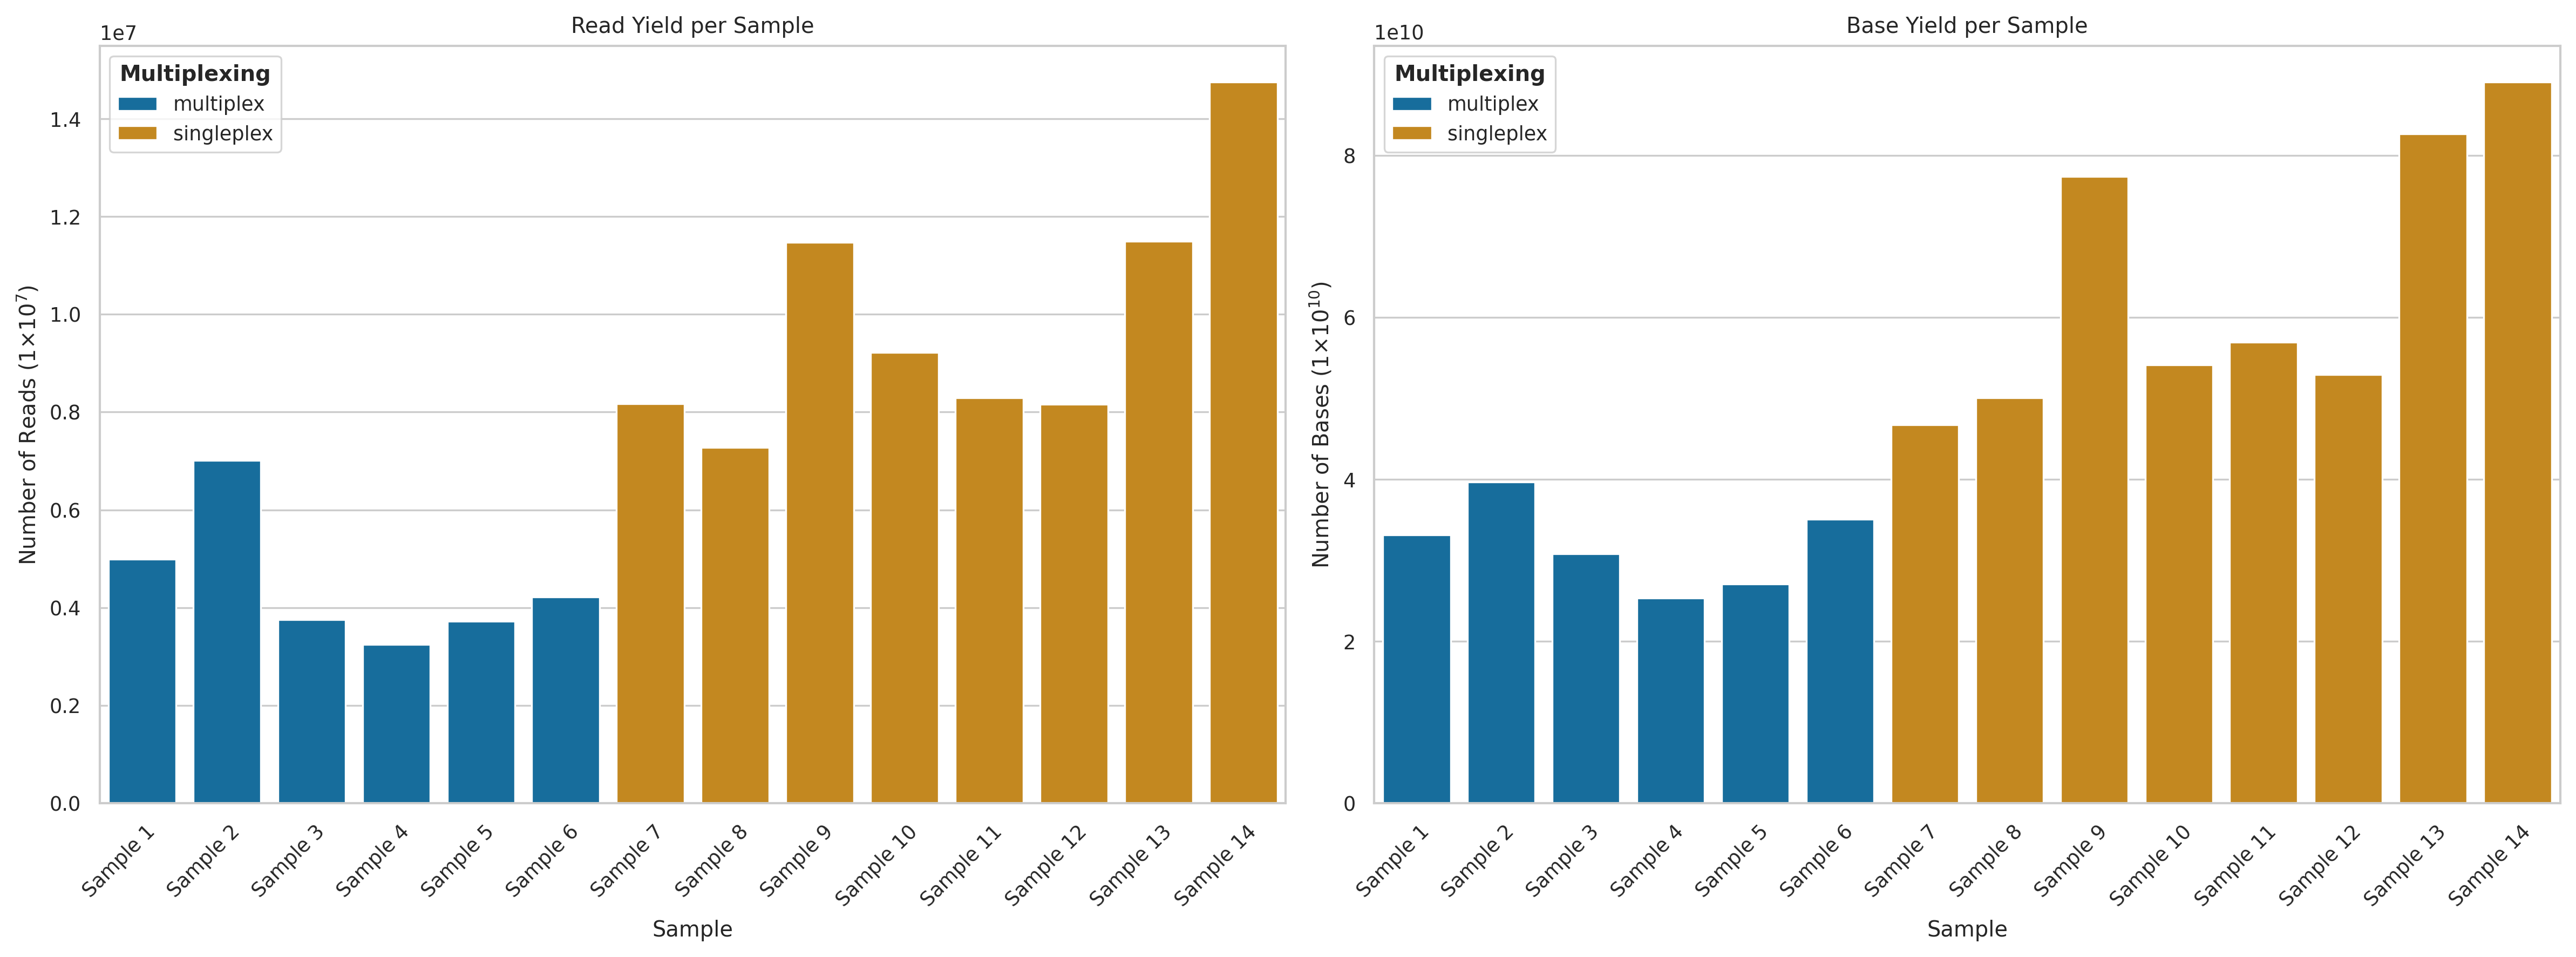

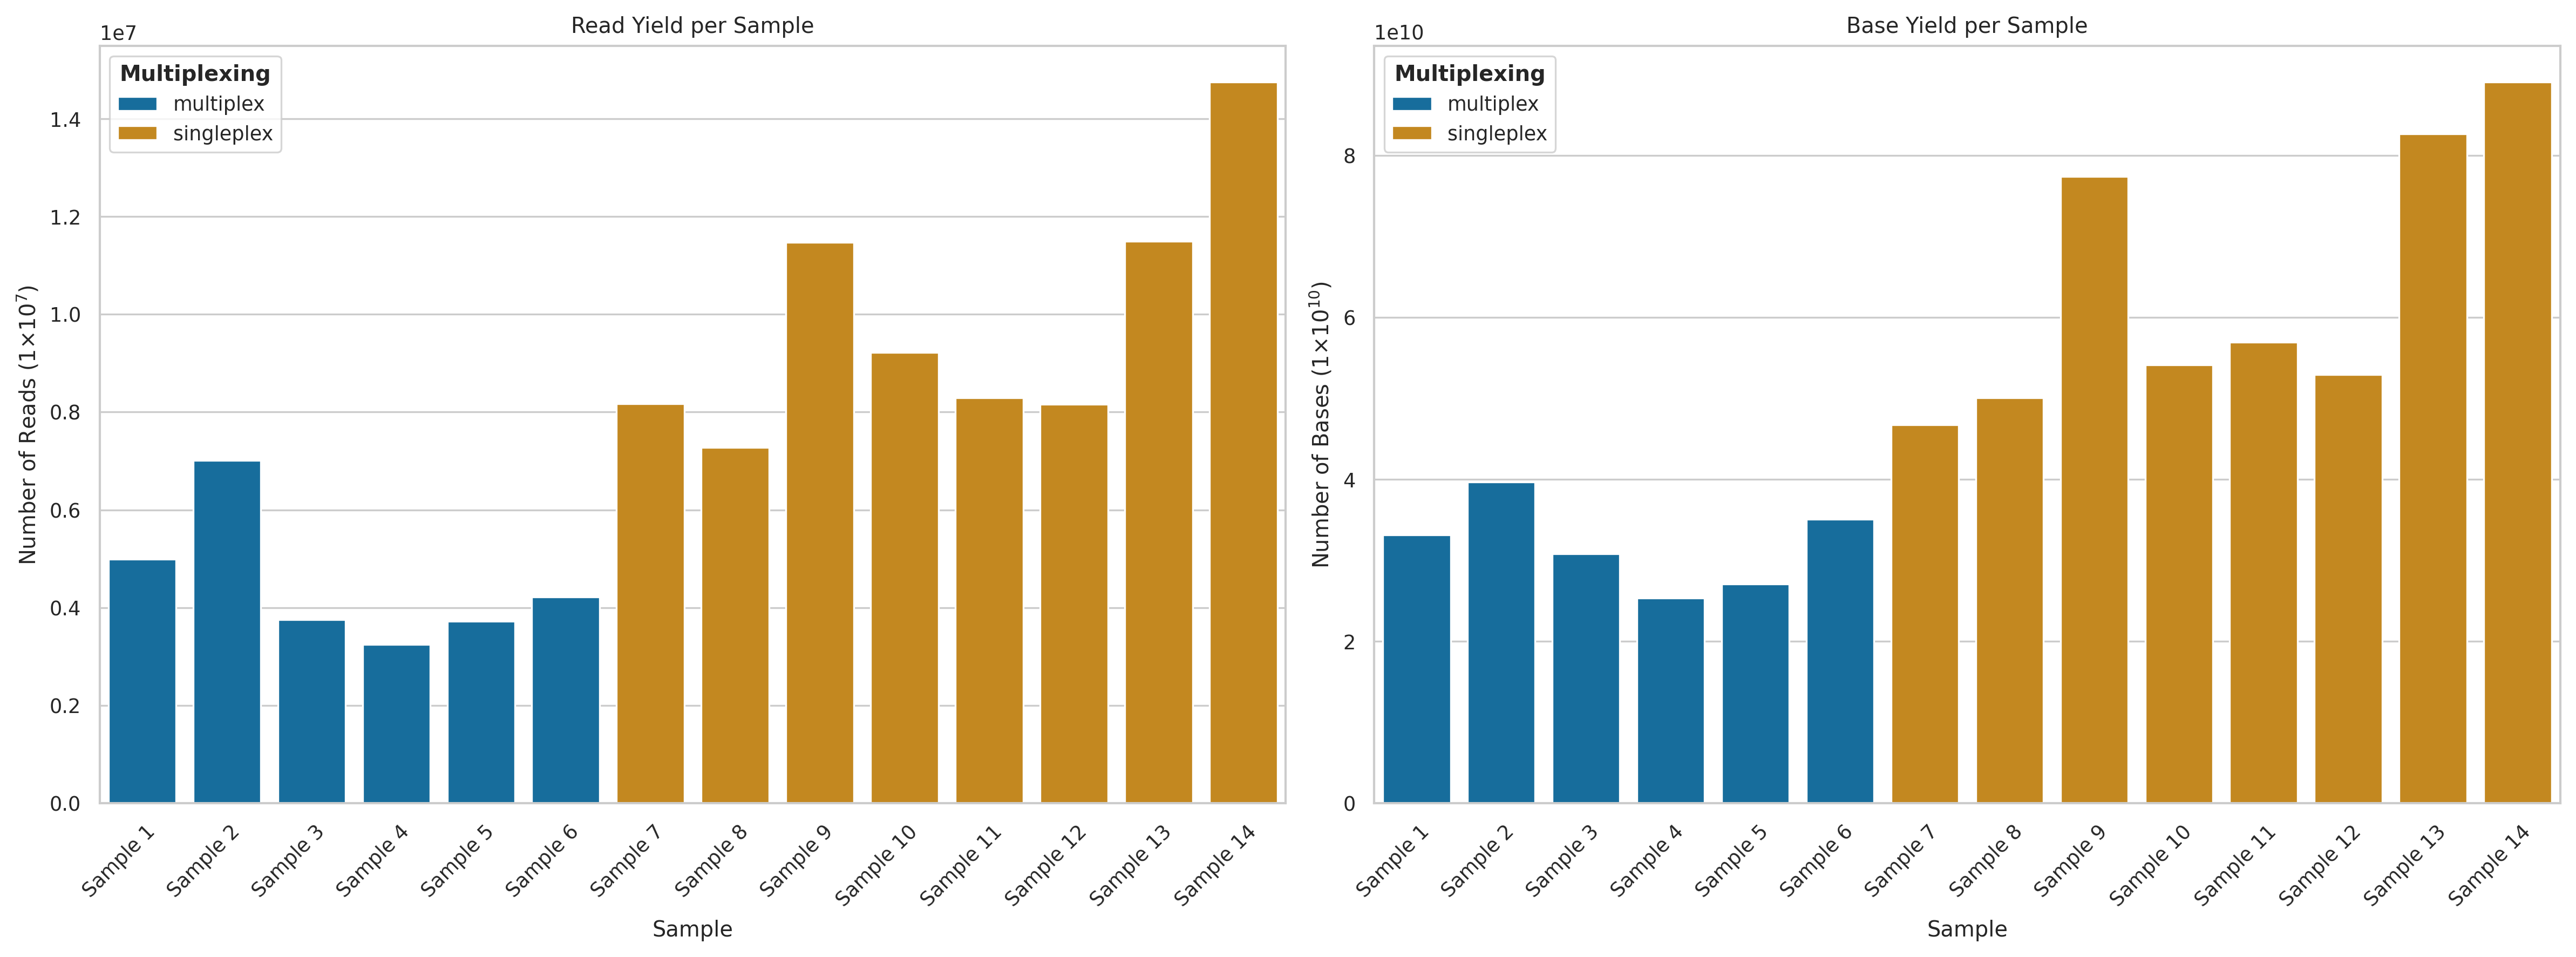

In [3]:
def _create_yield_plot(
    ax: plt.Axes,
    data: pl.DataFrame,
    x: str,
    y: str,
    hue: str,
    title: str,
    xlabel: str,
    ylabel: str,
) -> None:
    """
    Create a bar plot showing yield metrics.

    Args:
        ax (plt.Axes): Matplotlib axes object to plot on
        data (pl.DataFrame): Polars DataFrame containing the data
        x (str): Column name for x-axis
        y (str): Column name for y-axis
        hue (str): Column name for color grouping
        title (str): Plot title
        xlabel (str): X-axis label
        ylabel (str): Y-axis label

    Raises:
        ValueError: If required columns are not found in the DataFrame
    """
    try:
        # Validate input columns
        required_cols = {x, y, hue}
        if not required_cols.issubset(data.columns):
            missing = required_cols - set(data.columns)
            raise ValueError(f"Missing required columns: {missing}")

        # Create plot with sorted data
        sns.barplot(x=x, y=y, hue=hue, data=data, ax=ax)

        ax.set_title(title)
        ax.set_xlabel(xlabel)

        # Get the scale factor from the formatter
        formatter = ax.yaxis.get_major_formatter()
        if hasattr(formatter, "orderOfMagnitude"):
            scale = formatter.orderOfMagnitude
            ylabel = f"{ylabel} ($1×10^{{{scale}}}$)"

        ax.set_ylabel(ylabel)

        # Rotate x-axis labels
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
            tick.set_ha("right")

        # Adjust x-tick positions
        locs, _ = ax.get_xticks(), ax.get_xticklabels()
        ax.set_xticks([loc + 0.2 for loc in locs])

        # Create legend
        legend = ax.legend(title=hue.title())
        title_obj = legend.get_title()
        title_obj.set_weight("bold")

    except Exception as e:
        logger.error(f"Error creating yield plot: {str(e)}")
        raise


def plot_sample_yields(
    metrics_df: pl.DataFrame,
    basecall_type: str = "sup",
    figsize: Tuple[int, int] = (16, 6),
    dpi: int = 300,
    gs: Optional[gridspec.GridSpec] = None,
    gs_slice: Optional[Union[slice, Tuple[slice, slice]]] = None,
) -> Optional[plt.Figure]:
    """
    Create plots showing read and base yields for samples.

    Args:
        metrics_df (pl.DataFrame): Polars DataFrame containing metrics data
        basecall_type (str, optional): Basecall type to filter for. Defaults to "sup".
        figsize (Tuple[int, int], optional): Figure size. Defaults to (16, 6).
        dpi (int, optional): Figure DPI. Defaults to 300.
        gs (gridspec.GridSpec, optional): GridSpec for plotting within larger figure.
        gs_slice (Union[slice, Tuple[slice, slice]], optional): Slice of GridSpec to use.

    Returns:
        Optional[plt.Figure]: Figure object if created independently (no GridSpec provided)

    Raises:
        ValueError: If DataFrame doesn't contain required columns or if invalid GridSpec parameters
    """
    try:
        # Validate input data
        required_cols = {
            "basecall",
            "anonymised_sample",
            "number_of_reads",
            "number_of_bases",
            "multiplexing",
        }
        if not required_cols.issubset(metrics_df.columns):
            missing = required_cols - set(metrics_df.columns)
            raise ValueError(f"Missing required columns: {missing}")

        # Filter data
        yields_df = metrics_df.filter(pl.col("basecall") == basecall_type)

        if len(yields_df) == 0:
            raise ValueError(f"No data found for basecall_type: {basecall_type}")

        # Create figure and axes based on whether GridSpec is provided
        if gs is None:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize, dpi=dpi)
        else:
            if gs_slice is None:
                raise ValueError("gs_slice must be provided when using GridSpec")
            fig = plt.gcf()
            if isinstance(gs_slice, tuple):
                ax1 = fig.add_subplot(gs[gs_slice[0]])
                ax2 = fig.add_subplot(gs[gs_slice[1]])
            else:
                gs_subset = gs[gs_slice]
                ax1 = fig.add_subplot(gs_subset[0])
                ax2 = fig.add_subplot(gs_subset[1])

        # Create plots
        _create_yield_plot(
            ax1,
            yields_df,
            "anonymised_sample",
            "number_of_reads",
            "multiplexing",
            f"Read Yield per Sample",
            "Sample",
            "Number of Reads",
        )

        _create_yield_plot(
            ax2,
            yields_df,
            "anonymised_sample",
            "number_of_bases",
            "multiplexing",
            f"Base Yield per Sample",
            "Sample",
            "Number of Bases",
        )

        if gs is None:
            plt.tight_layout()
            return fig
        return None

    except Exception as e:
        logger.error(f"Error plotting sample yields: {str(e)}")
        raise


yields_plot = plot_sample_yields(nanoplot_qc_metrics)


#### Summary Stats


In [4]:
@dataclass
class YieldMetrics:
    """
    Data class for storing yield metrics statistics.
    """

    max: float
    min: float
    mean: float
    std: float
    median: float


@dataclass
class YieldStats:
    """
    Data class for storing read and base yield statistics.
    """

    reads: YieldMetrics
    bases: YieldMetrics


def _format_number(num: float) -> str:
    """
    Format a number with thousand separators.

    Args:
        num (float): Number to format with thousand separators

    Returns:
        str: Formatted string representation of the number with thousand separators

    Examples:
        >>> _format_number(1234567.89)
        '1,234,568'
    """
    return f"{num:,.0f}"


def _calculate_yield_stats(df: pl.DataFrame) -> YieldStats:
    """
    Calculate yield statistics from a Polars DataFrame.

    Args:
        df (pl.DataFrame): Input DataFrame containing yield metrics with columns
            'number_of_reads' and 'number_of_bases'

    Returns:
        YieldStats: Object containing read and base statistics

    Raises:
        Exception: If there's an error calculating statistics from the DataFrame
        KeyError: If required columns are missing from the DataFrame
    """
    try:
        reads_metrics = YieldMetrics(
            max=df.select(pl.col("number_of_reads").max()).item(),
            min=df.select(pl.col("number_of_reads").min()).item(),
            mean=df.select(pl.col("number_of_reads").mean()).item(),
            std=df.select(pl.col("number_of_reads").std()).item(),
            median=df.select(pl.col("number_of_reads").median()).item(),
        )

        bases_metrics = YieldMetrics(
            max=df.select(pl.col("number_of_bases").max()).item(),
            min=df.select(pl.col("number_of_bases").min()).item(),
            mean=df.select(pl.col("number_of_bases").mean()).item(),
            std=df.select(pl.col("number_of_bases").std()).item(),
            median=df.select(pl.col("number_of_bases").median()).item(),
        )

        return YieldStats(reads=reads_metrics, bases=bases_metrics)
    except Exception as e:
        logger.error(f"Error calculating yield statistics: {str(e)}")
        raise


def _print_yield_stats(stats: YieldStats, sample_type: str) -> None:
    """
    Print formatted yield statistics.

    Args:
        stats (YieldStats): YieldStats object containing statistics to print
        sample_type (str): Type of sample (Multiplexed/Singleplexed)

    Raises:
        Exception: If there's an error formatting or printing the statistics
    """
    try:
        logger.info(f"Printing statistics for {sample_type} samples")
        print(f"\n{sample_type} Samples Statistics:")
        print("=" * 40)

        # Access attributes directly instead of using subscription
        for metric_name, metrics in [("Reads", stats.reads), ("Bases", stats.bases)]:
            print(f"\n{metric_name}:")
            for stat_name, value in vars(metrics).items():
                formatted_value = _format_number(value)
                print(f"  {stat_name.capitalize():6s}: {formatted_value}")
    except Exception as e:
        logger.error(f"Error printing yield statistics: {str(e)}")
        raise


def _calculate_percentage_increase(
    singleplex_val: float, multiplex_val: float
) -> float:
    """
    Calculate percentage increase between two values.

    Args:
        singleplex_val (float): Value from singleplex samples
        multiplex_val (float): Value from multiplex samples

    Returns:
        float: Percentage increase between the two values

    Raises:
        ZeroDivisionError: If multiplex value is zero
        Exception: For other calculation errors

    Examples:
        >>> _calculate_percentage_increase(200, 100)
        100.0
    """
    try:
        return ((singleplex_val - multiplex_val) / multiplex_val) * 100
    except ZeroDivisionError:
        logger.error("Cannot calculate percentage increase: multiplex value is zero")
        raise
    except Exception as e:
        logger.error(f"Error calculating percentage increase: {str(e)}")
        raise


def analyze_yields(df: pl.DataFrame) -> None:
    """
    Analyze and print yield statistics for multiplexed and singleplexed samples.

    Args:
        df (pl.DataFrame): Input DataFrame containing yield metrics with columns:
            - multiplexing: str ('singleplex' or 'multiplex')
            - basecall: str ('sup' or other)
            - number_of_reads: int/float
            - number_of_bases: int/float

    Raises:
        Exception: If there's an error during analysis
        ValueError: If required data is missing from the DataFrame
    """
    try:
        singleplex_yields = df.filter(
            (pl.col("multiplexing") == "singleplex") & (pl.col("basecall") == "sup")
        )
        multiplex_yields = df.filter(
            (pl.col("multiplexing") == "multiplex") & (pl.col("basecall") == "sup")
        )

        if singleplex_yields.height == 0 or multiplex_yields.height == 0:
            logger.warning("No data found for either singleplex or multiplex samples")
            return

        singleplex_stats = _calculate_yield_stats(singleplex_yields)
        multiplex_stats = _calculate_yield_stats(multiplex_yields)

        _print_yield_stats(singleplex_stats, "Singleplexed")
        _print_yield_stats(multiplex_stats, "Multiplexed")

        print("\nPercentage Increase (Singleplexed vs Multiplexed):")
        print("=" * 40)

        increase_reads = _calculate_percentage_increase(
            singleplex_stats.reads.mean, multiplex_stats.reads.mean
        )
        increase_bases = _calculate_percentage_increase(
            singleplex_stats.bases.mean, multiplex_stats.bases.mean
        )

        print(f"Mean Number of Reads: {increase_reads:6.2f}%")
        print(f"Mean Number of Bases: {increase_bases:6.2f}%")

        logger.info("Yield analysis completed successfully")

    except Exception as e:
        logger.error(f"Error in yield analysis: {str(e)}")
        raise


analyze_yields(nanoplot_qc_metrics)


__main__ - INFO - Printing statistics for Singleplexed samples
__main__ - INFO - Printing statistics for Multiplexed samples
__main__ - INFO - Yield analysis completed successfully



Singleplexed Samples Statistics:

Reads:
  Max   : 14,748,981
  Min   : 7,278,922
  Mean  : 9,852,491
  Std   : 2,520,439
  Median: 8,753,088

Bases:
  Max   : 89,066,920,475
  Min   : 46,724,841,571
  Mean  : 63,738,789,433
  Std   : 16,558,552,545
  Median: 55,525,832,820

Multiplexed Samples Statistics:

Reads:
  Max   : 7,010,703
  Min   : 3,244,516
  Mean  : 4,490,539
  Std   : 1,368,722
  Median: 3,987,756

Bases:
  Max   : 39,668,379,048
  Min   : 25,309,962,961
  Mean  : 31,845,929,048
  Std   : 5,296,690,498
  Median: 31,988,887,991

Percentage Increase (Singleplexed vs Multiplexed):
Mean Number of Reads: 119.41%
Mean Number of Bases: 100.15%


### 2. Read Lengths


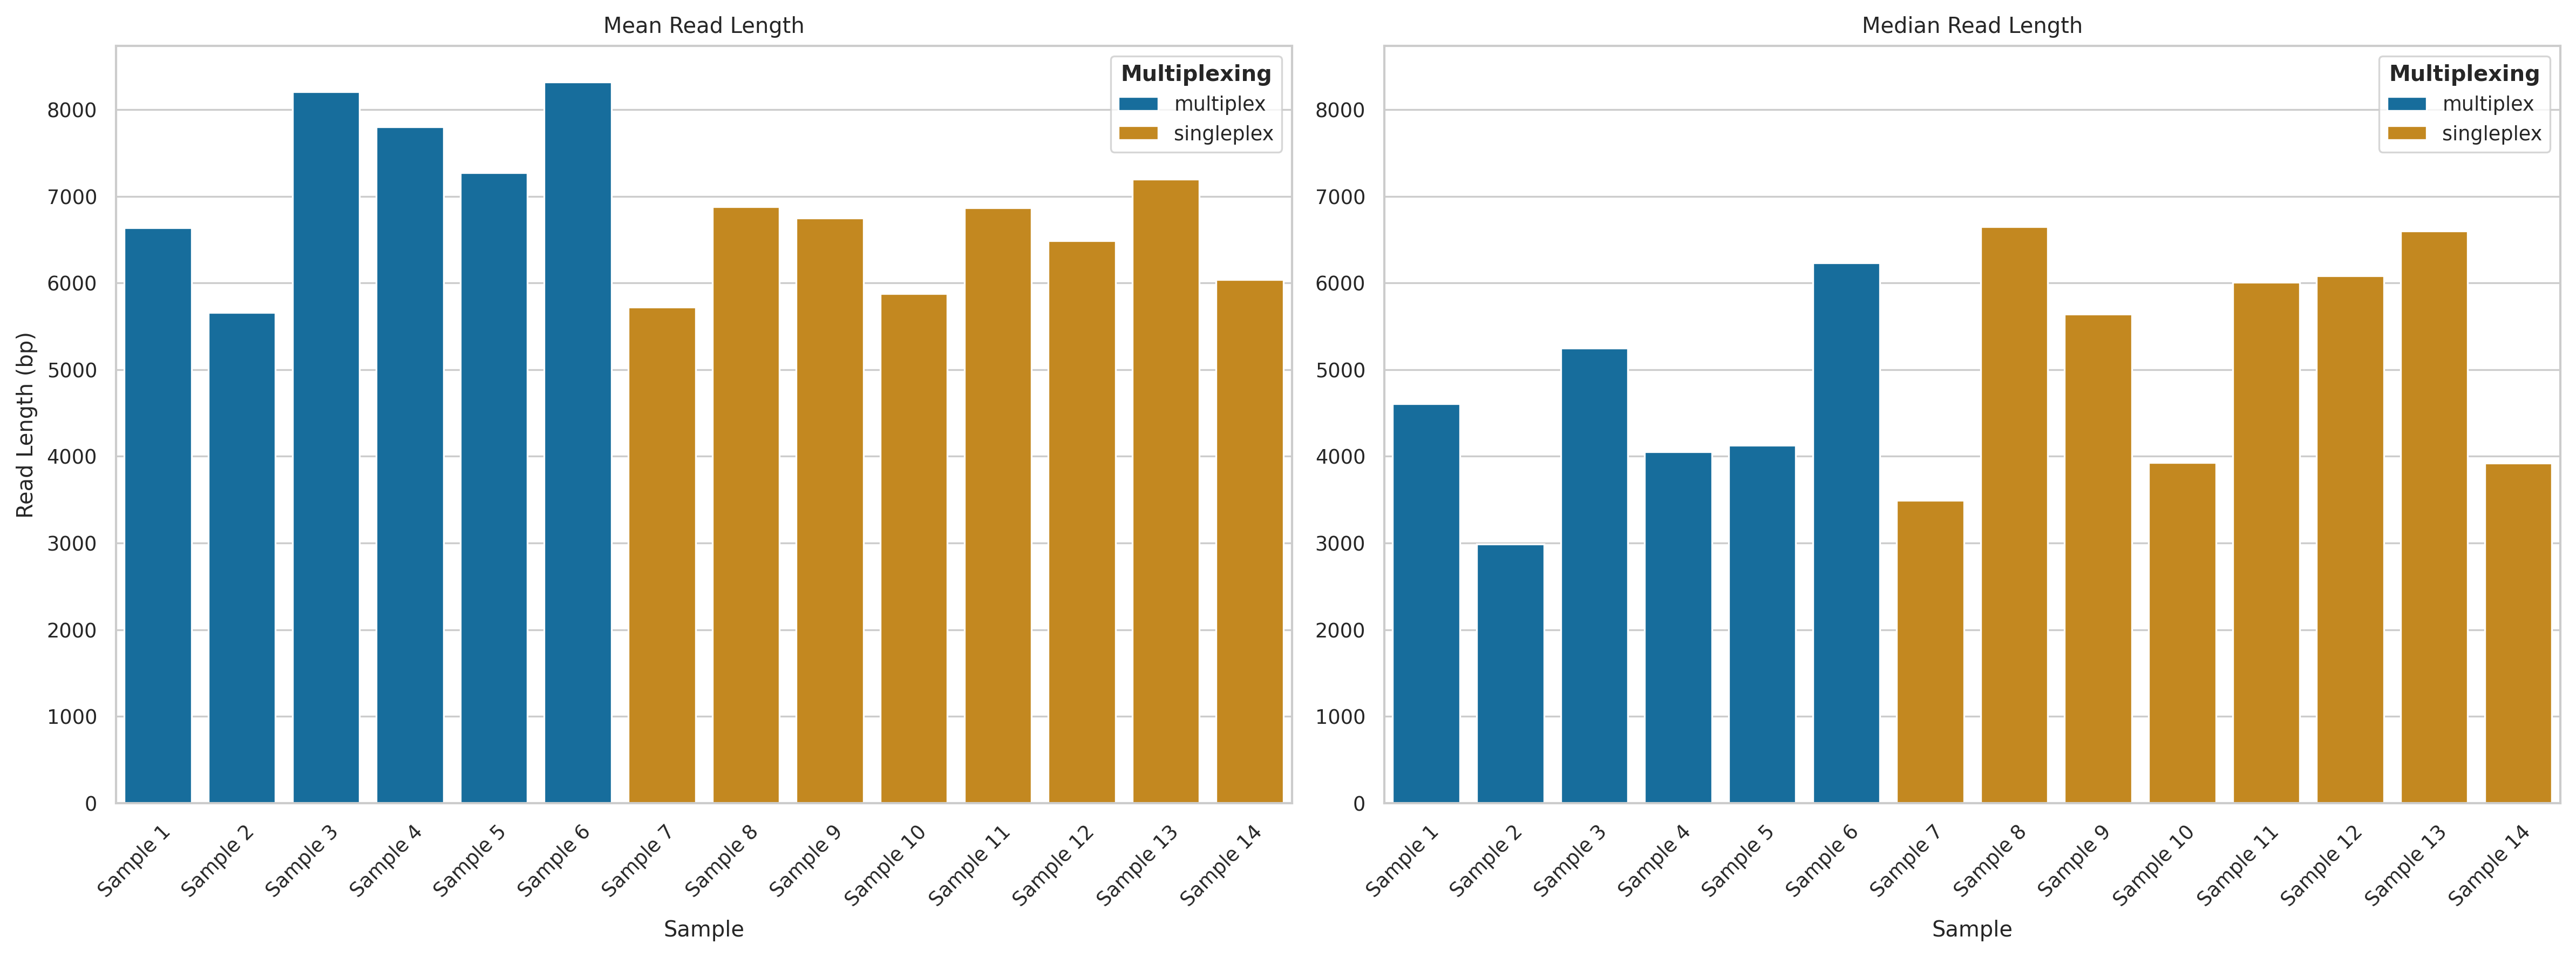

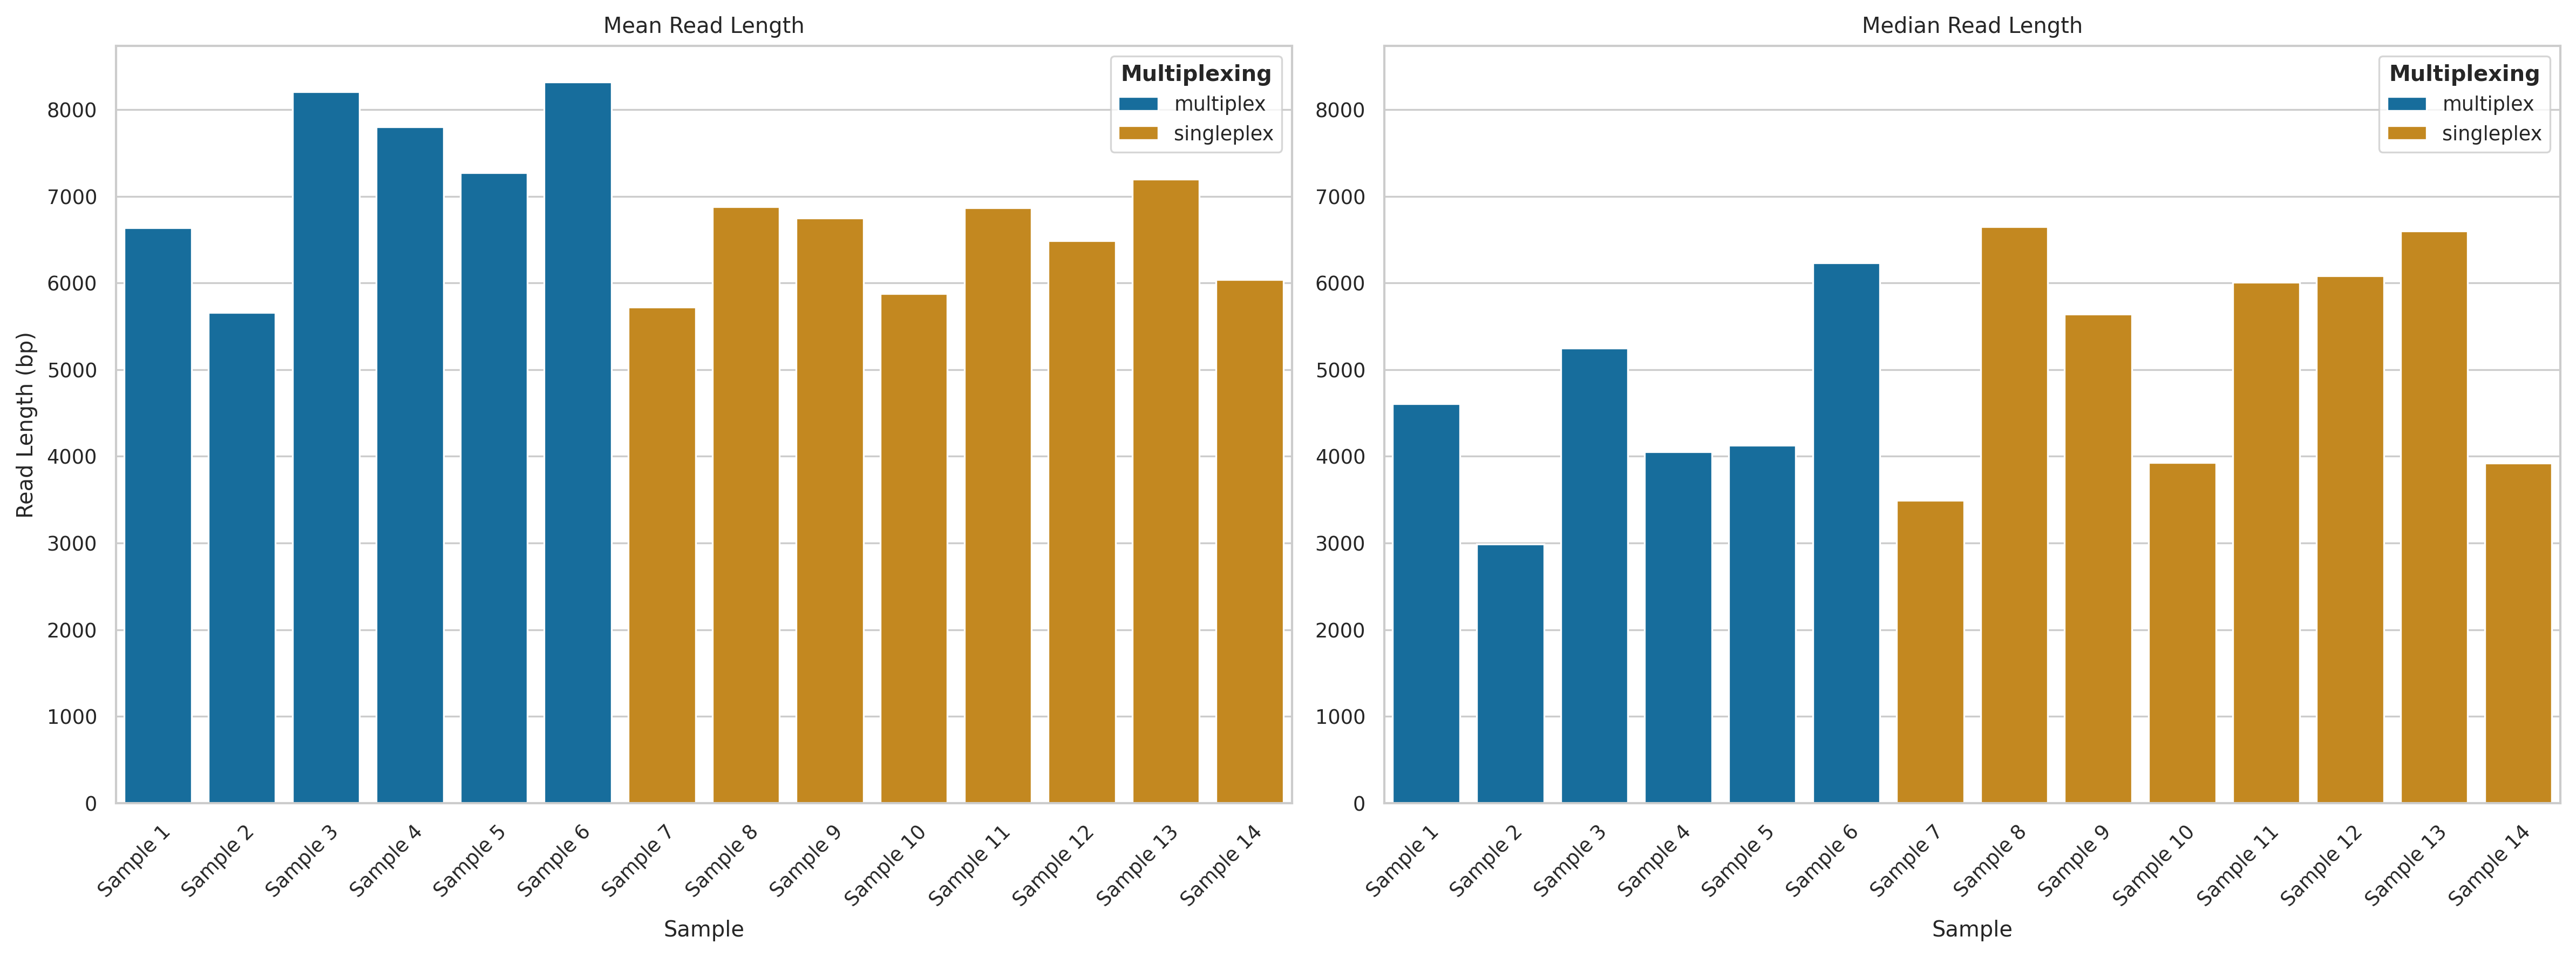

In [5]:
def _create_length_subplot(
    data: pl.DataFrame, ax: plt.Axes, title: str, hue: str
) -> None:
    """
    Create a subplot showing read length metrics.

    Args:
        data (pl.DataFrame): DataFrame containing the plot data
        ax (plt.Axes): Matplotlib axes object to plot on
        title (str): Plot title
        hue (str): Column name for color grouping

    Raises:
        ValueError: If required columns are missing from DataFrame
    """
    try:
        sns.barplot(
            x="anonymised_sample",
            y="read_length",
            hue=hue,
            data=data,
            errorbar=None,
            ax=ax,
        )

        ax.set_title(title)
        ax.set_xlabel("Sample")

        formatter = ax.yaxis.get_major_formatter()
        ylabel = "Read Length (bp)"
        ax.set_ylabel(ylabel)

        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
            tick.set_ha("right")

        locs, _ = ax.get_xticks(), ax.get_xticklabels()
        ax.set_xticks([loc + 0.2 for loc in locs])

        legend = ax.legend(title=hue.title())
        title_obj = legend.get_title()
        title_obj.set_weight("bold")

    except Exception as e:
        logger.error(f"Error creating length subplot: {str(e)}")
        raise


def plot_read_lengths(
    metrics_df: pl.DataFrame,
    figsize: Tuple[int, int] = (16, 6),
    dpi: int = 300,
    gs: Optional[gridspec.GridSpec] = None,
    gs_slice: Optional[Union[slice, Tuple[slice, slice]]] = None,
) -> Optional[plt.Figure]:
    """
    Create plots showing read length distributions for samples.

    Args:
        metrics_df (pl.DataFrame): Input DataFrame containing metrics data
        figsize (Tuple[int, int], optional): Figure size. Defaults to (16, 6)
        dpi (int, optional): Figure DPI. Defaults to 300
        gs (gridspec.GridSpec, optional): GridSpec for plotting within larger figure
        gs_slice (Union[slice, Tuple[slice, slice]], optional): Slice of GridSpec to use

    Returns:
        Optional[plt.Figure]: Figure object if created independently

    Raises:
        ValueError: If DataFrame doesn't contain required columns or invalid GridSpec parameters
    """
    try:
        required_cols = {
            "basecall",
            "sample",
            "anonymised_sample",
            "multiplexing",
            "mean_read_length",
            "median_read_length",
        }
        if not required_cols.issubset(metrics_df.columns):
            missing = required_cols - set(metrics_df.columns)
            raise ValueError(f"Missing required columns: {missing}")

        # Filter and prepare data
        plot_data = (
            metrics_df.filter(pl.col("basecall") == "sup")
            .select(
                [
                    "sample",
                    "anonymised_sample",
                    "multiplexing",
                    "mean_read_length",
                    "median_read_length",
                ]
            )
            .unpivot(
                index=["sample", "anonymised_sample", "multiplexing"],
                on=["mean_read_length", "median_read_length"],
                variable_name="read_length_type",
                value_name="read_length",
            )
        )

        if gs is None:
            fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True, dpi=dpi)
        else:
            if gs_slice is None:
                raise ValueError("gs_slice must be provided when using GridSpec")
            fig = plt.gcf()
            if isinstance(gs_slice, tuple):
                axes = [
                    fig.add_subplot(gs[gs_slice[0]]),
                    fig.add_subplot(gs[gs_slice[1]]),
                ]
            else:
                gs_subset = gs[gs_slice]
                axes = [fig.add_subplot(gs_subset[0]), fig.add_subplot(gs_subset[1])]

        for ax, read_length_type in zip(
            axes, ["mean_read_length", "median_read_length"]
        ):
            title = read_length_type.replace("_", " ").title()
            data = plot_data.filter(pl.col("read_length_type") == read_length_type)
            _create_length_subplot(data, ax, title, hue="multiplexing")

            if ax != axes[0]:
                ax.yaxis.set_tick_params(labelleft=True)

        if gs is None:
            plt.tight_layout()
            return fig
        return None

    except Exception as e:
        logger.error(f"Error plotting read lengths: {str(e)}")
        raise


read_lengths_plot = plot_read_lengths(nanoplot_qc_metrics)


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7a5a8f61dee0>>
Traceback (most recent call last):
  File "/scratch/users/k2474617/conda/jupyter/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


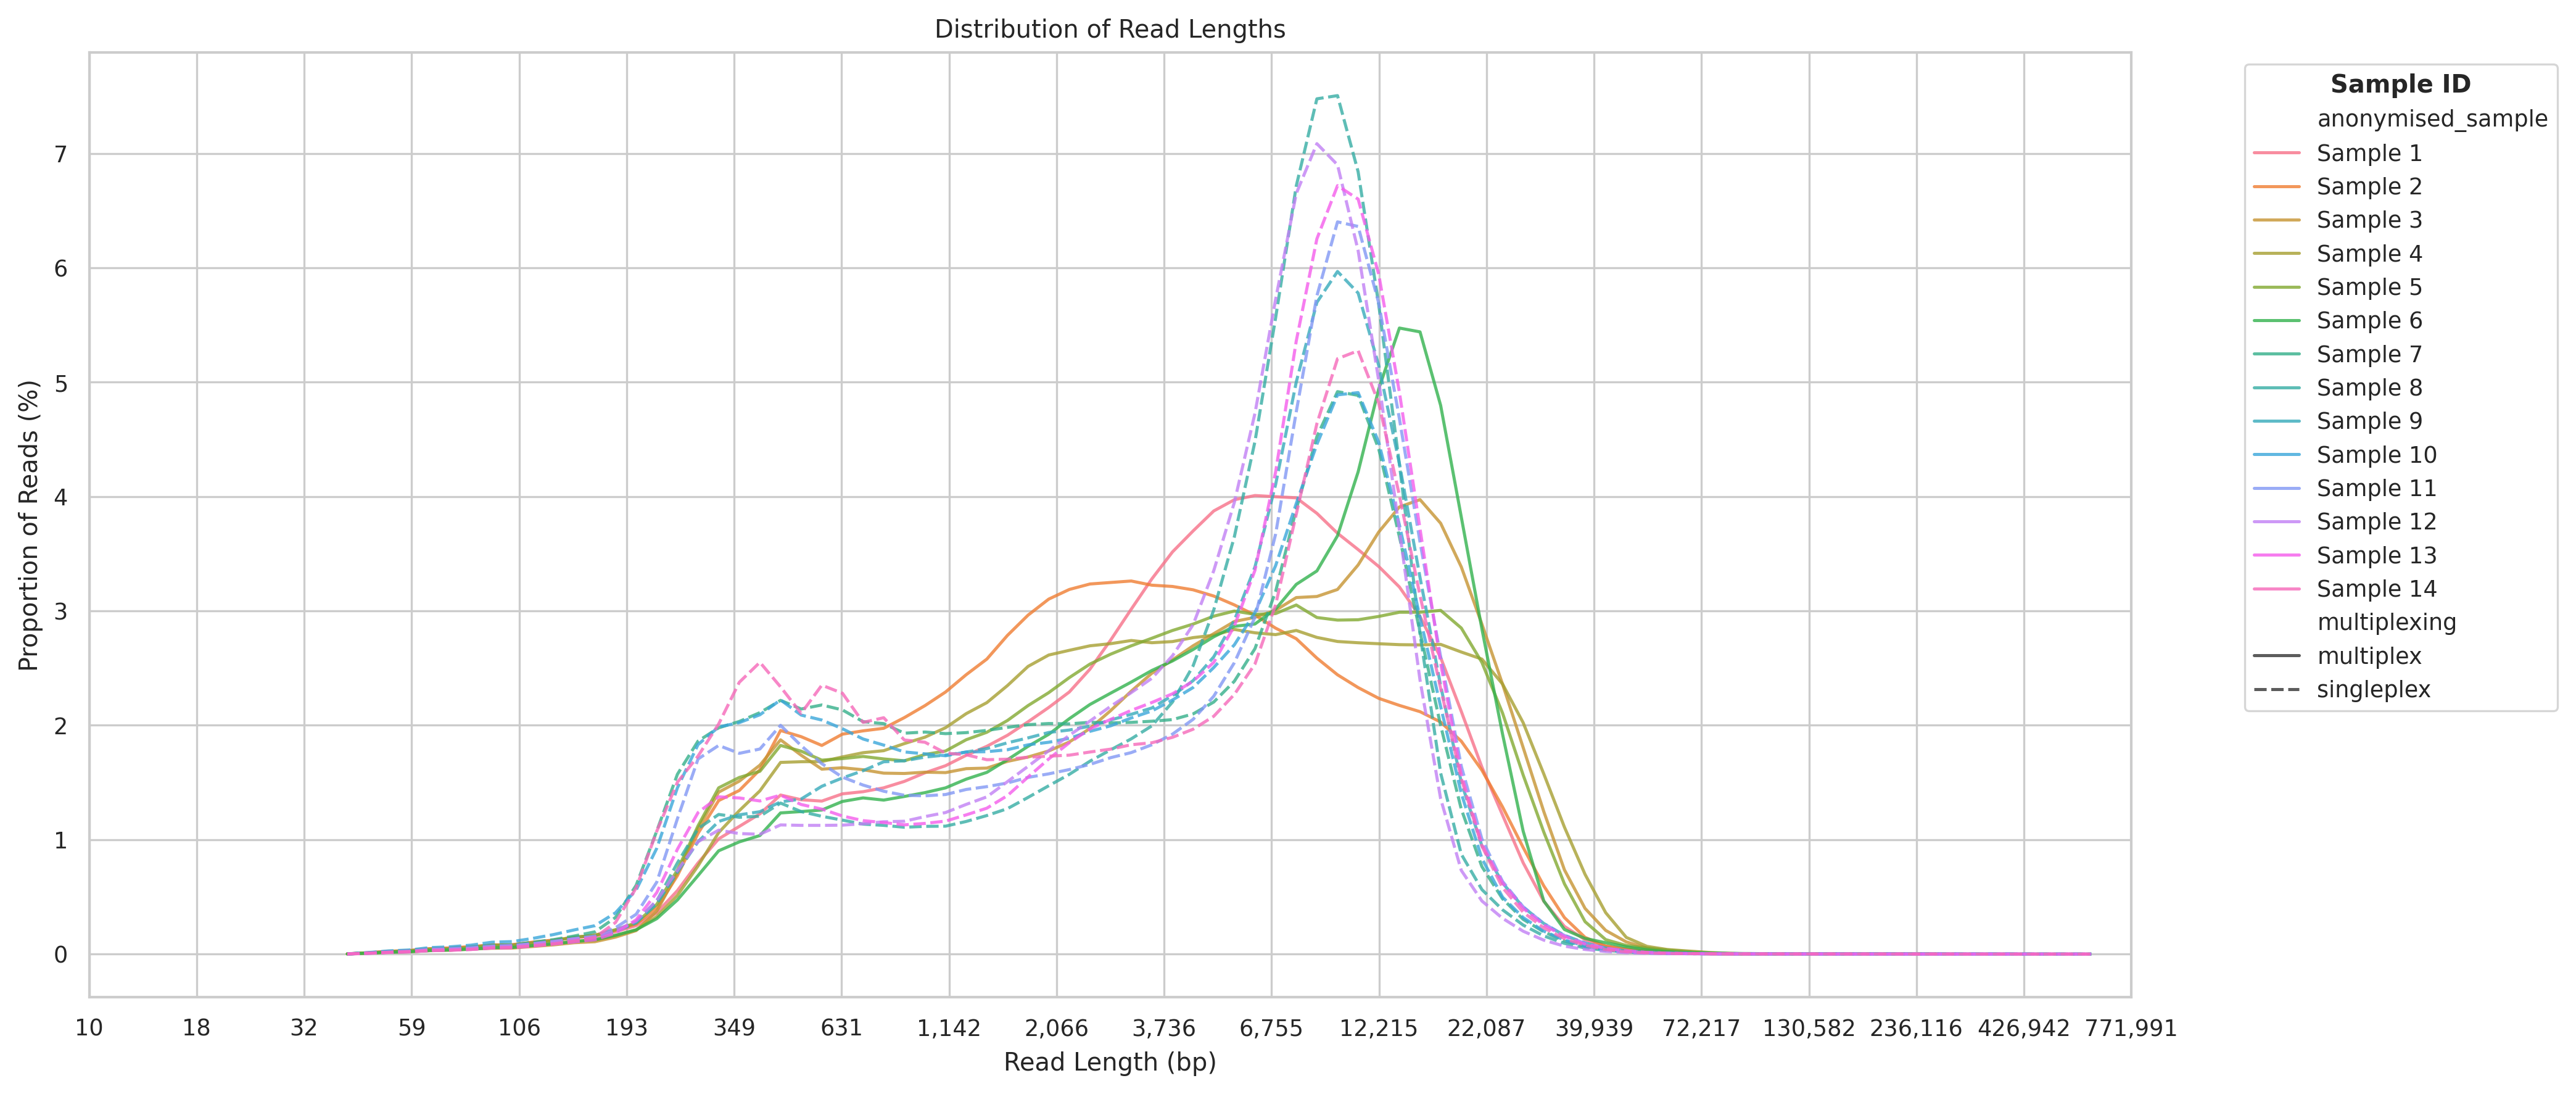

In [ ]:
def load_nanoplot_data(base_dir: Path, metrics_df: pl.DataFrame) -> pl.DataFrame:
    """
    Load NanoPlot data from pickle files and combine with metrics.

    Args:
        base_dir (Path): Base directory containing NanoPlot data files
        metrics_df (pl.DataFrame): DataFrame containing sample metrics

    Returns:
        pl.DataFrame: Combined NanoPlot data for all samples

    Raises:
        FileNotFoundError: If pickle file is not found
        ValueError: If required columns are missing
    """
    required_columns = ("readIDs", "quals", "lengths", "mapQ")
    data_list = []

    try:
        for row in metrics_df.iter_rows(named=True):
            sample_dir = f"{row['sample']}_{row['basecall']}"
            pickle_path = base_dir / sample_dir / "NanoPlot-data.pickle"

            if not pickle_path.is_file():
                logger.warning(f"Pickle file not found: {pickle_path}")
                continue

            with open(pickle_path, "rb") as file:
                nanoplot_data = pickle.load(file)

            sample_df = pl.DataFrame(nanoplot_data).select(required_columns)
            sample_df = sample_df.with_columns(
                [
                    pl.lit(row["anonymised_sample"]).alias("anonymised_sample"),
                    pl.lit(row["basecall"]).alias("basecall"),
                ]
            )
            data_list.append(sample_df)

        if not data_list:
            raise ValueError("No valid data found in any pickle files")

        return pl.concat(data_list)

    except Exception as e:
        logger.error(f"Error loading NanoPlot data: {str(e)}")
        raise


def process_nanoplot_data(
    nanoplot_data: pl.DataFrame, metrics_df: pl.DataFrame
) -> pl.DataFrame:
    """
    Process NanoPlot data by merging with metrics and binning read lengths.

    Args:
        nanoplot_data (pl.DataFrame): Raw NanoPlot data
        metrics_df (pl.DataFrame): Metrics DataFrame

    Returns:
        pl.DataFrame: Processed DataFrame with binned lengths

    Raises:
        ValueError: If required columns are missing
    """
    try:
        metrics_subset = metrics_df.select(
            ["anonymised_sample", "multiplexing", "basecall", "number_of_reads"]
        )

        processed_data = nanoplot_data.join(
            metrics_subset, on=["anonymised_sample", "basecall"]
        )

        max_length = processed_data.select(pl.col("lengths").max()).item()
        bins = np.logspace(np.log10(10), np.log10(max_length), num=100)

        processed_data = processed_data.with_columns(
            [pl.col("lengths").cut(bins).alias("length_bin")]
        )

        return processed_data

    except Exception as e:
        logger.error(f"Error processing NanoPlot data: {str(e)}")
        raise


def calculate_read_length_distribution(
    processed_data: pl.DataFrame, basecall_type: str = "sup"
) -> pl.DataFrame:
    """
    Calculate read length distribution statistics.

    Args:
        processed_data (pl.DataFrame): Processed NanoPlot data
        basecall_type (str, optional): Basecall type to filter. Defaults to "sup"

    Returns:
        pl.DataFrame: Length distribution statistics

    Raises:
        ValueError: If required columns are missing
    """
    try:
        filtered_data = processed_data.filter(pl.col("basecall") == basecall_type)

        # Extract bin edges from the categorical length_bin column
        bin_categories = filtered_data.select(pl.col("length_bin").unique()).to_series()
        bin_edges = [float(edge.split(",")[0][1:]) for edge in bin_categories]
        bin_centers = [
            (bin_edges[i] + bin_edges[i + 1]) / 2 for i in range(len(bin_edges) - 1)
        ]

        # Create a mapping DataFrame to calculate bin centers
        mapping_df = pl.DataFrame(
            {
                "length_bin": bin_categories[:-1],  # Exclude the last bin edge
                "bin_center": bin_centers,
            }
        )

        length_dist = (
            filtered_data.group_by(["anonymised_sample", "length_bin", "multiplexing"])
            .agg(pl.len().alias("count"))
            .join(
                filtered_data.select(["anonymised_sample", "number_of_reads"]).unique(),
                on="anonymised_sample",
            )
        )

        # Add percentage and join with mapping DataFrame to get bin centers
        length_dist = length_dist.with_columns(
            [(pl.col("count") / pl.col("number_of_reads") * 100).alias("percentage")]
        ).join(mapping_df, on="length_bin", how="left")

        return length_dist

    except Exception as e:
        logger.error(f"Error calculating length distribution: {str(e)}")
        raise


def plot_read_length_distribution(
    length_dist: pl.DataFrame,
    max_length: float,
    figsize: Tuple[int, int] = (14, 6),
    dpi: int = 300,
    x_scale: str = "log",
    x_min: int = 10,
    num_ticks: int = 20,
    line_alpha: float = 0.8,
    gs: Optional[gridspec.GridSpec] = None,
    gs_slice: Optional[Union[slice, Tuple[slice, slice]]] = None,
) -> Optional[plt.Figure]:
    """
    Plot the distribution of read lengths across samples.

    Args:
        length_dist (pl.DataFrame): DataFrame containing length distribution data
        max_length (float): Maximum read length for x-axis limit
        figsize (Tuple[int, int], optional): Figure size. Defaults to (14, 6)
        dpi (int, optional): Figure DPI. Defaults to 300
        x_scale (str, optional): Scale for x-axis. Defaults to "log"
        x_min (int, optional): Minimum x-axis value. Defaults to 10
        num_ticks (int, optional): Number of x-axis ticks. Defaults to 20
        line_alpha (float, optional): Line transparency. Defaults to 0.8
        gs (gridspec.GridSpec, optional): GridSpec for plotting within larger figure
        gs_slice (Union[slice, Tuple[slice, slice]], optional): Slice of GridSpec to use

    Returns:
        Optional[Figure]: Figure object if created independently

    Raises:
        ValueError: If required columns are missing or invalid GridSpec parameters
    """
    try:
        required_cols = {
            "anonymised_sample",
            "bin_center",
            "percentage",
            "multiplexing",
        }
        if not all(col in length_dist.columns for col in required_cols):
            missing = required_cols - set(length_dist.columns)
            raise ValueError(f"Missing required columns: {missing}")

        if gs is None:
            fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
        else:
            if gs_slice is None:
                raise ValueError("gs_slice must be provided when using GridSpec")
            fig = plt.gcf()
            if isinstance(gs_slice, tuple):
                ax = fig.add_subplot(gs[gs_slice[0]])
            else:
                ax = fig.add_subplot(gs[gs_slice])

        # Filter and prepare data
        non_zero_samples = (
            length_dist.group_by("anonymised_sample")
            .agg(pl.col("percentage").sum())
            .filter(pl.col("percentage") > 0)
            .select("anonymised_sample")
        )

        filtered_dist = (
            length_dist.join(non_zero_samples, on="anonymised_sample")
            .with_columns(
                [
                    pl.col("anonymised_sample")
                    .str.extract(r"(\d+)")
                    .cast(pl.Int32)
                    .alias("sample_num")
                ]
            )
            .sort("sample_num")
        )

        sns.lineplot(
            data=filtered_dist,
            x="bin_center",
            y="percentage",
            hue="anonymised_sample",
            style="multiplexing",
            alpha=line_alpha,
            ax=ax,
        )

        ax.set_xscale(x_scale)
        ax.set_xlabel("Read Length (bp)")
        ax.set_ylabel("Proportion of Reads (%)")
        ax.set_title("Distribution of Read Lengths")

        # Set x-axis ticks
        tick_positions = np.logspace(
            np.log10(x_min), np.log10(max_length), num=num_ticks
        )
        ax.set_xticks(tick_positions)
        ax.set_xticklabels([f"{int(tick):,}" for tick in tick_positions])

        # Set axis limits
        ax.set_xlim(left=x_min, right=max_length)

        # Adjust legend
        legend = ax.legend(
            title="Sample ID", bbox_to_anchor=(1.05, 1), loc="upper left"
        )
        legend.get_title().set_fontweight("bold")

        if gs is None:
            plt.tight_layout()
            return fig
        return None

    except Exception as e:
        logger.error(f"Error plotting read length distribution: {str(e)}")
        raise


nanoplot_aligned_metrics = load_nanoplot_data(np_aligned_bams_dir, nanoplot_qc_metrics)
processed_read_length_data = process_nanoplot_data(
    nanoplot_aligned_metrics, nanoplot_qc_metrics
)
max_read_length = processed_read_length_data.select(pl.col("lengths").max()).item()
read_length_distribution = calculate_read_length_distribution(
    processed_read_length_data
)
read_length_dist_plot = plot_read_length_distribution(
    read_length_distribution, max_read_length
)


In [ ]:
def format_number(num):
    return f"{num:,.2f}"


def calculate_length_stats(df):
    return {
        "max": df["lengths"].max(),
        "min": df["lengths"].min(),
        "mean": df["lengths"].mean(),
        "std": df["lengths"].std(),
        "median": df["lengths"].median(),
    }


def print_length_stats(stats, sample_type):
    print(f"\n{sample_type} Samples Statistics:")
    print("=" * 40)
    print("\nRead Lengths:")
    for stat, value in stats.items():
        formatted_value = format_number(value)
        print(f"  {stat.capitalize():6s}: {formatted_value}")


def calculate_percentage_increase(singleplex_val, multiplex_val):
    return ((singleplex_val - multiplex_val) / multiplex_val) * 100


singleplexed_reads = processed_nanoplot_data[
    (processed_nanoplot_data["multiplexing"] == "singleplex")
    & (processed_nanoplot_data["basecall"] == "sup")
]
multiplexed_reads = processed_nanoplot_data[
    (processed_nanoplot_data["multiplexing"] == "multiplex")
    & (processed_nanoplot_data["basecall"] == "sup")
]

singleplex_stats = calculate_length_stats(singleplexed_reads)
multiplex_stats = calculate_length_stats(multiplexed_reads)

print_length_stats(singleplex_stats, "Singleplexed")
print_length_stats(multiplex_stats, "Multiplexed")

print("\nPercentage Increase (Singleplexed vs Multiplexed):")
print("=" * 40)
for stat in ["mean", "median"]:
    increase = calculate_percentage_increase(
        singleplex_stats[stat], multiplex_stats[stat]
    )
    print(f"{stat.capitalize():6s} Read Length: {increase:6.2f}%")


### 3. Combined Plots


In [ ]:
def create_combined_yield_plot(metrics_df, read_length_df, length_distribution):
    fig = plt.figure(figsize=(12, 12), dpi=300)
    gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 1.2])

    def adjust_tick_labels(ax):
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
            tick.set_ha("right")
        locs, labels = ax.get_xticks(), ax.get_xticklabels()
        ax.set_xticks([loc + 0.2 for loc in locs])

    sample_order = sorted(
        metrics_df["anonymised_sample"].unique(), key=lambda x: int(x.split()[-1])
    )

    # A: Reads per Sample
    ax_a = fig.add_subplot(gs[0, 0])
    create_yield_plot(
        ax_a,
        metrics_df[metrics_df["basecall"] == "sup"],
        "anonymised_sample",
        "number_of_reads",
        "multiplexing",
        "Reads per Sample",
        "Sample",
        "Number of Reads",
    )
    ax_a.text(
        -0.10,
        1.07,
        "A",
        transform=ax_a.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
    )
    adjust_tick_labels(ax_a)

    # B: Bases per Sample
    ax_b = fig.add_subplot(gs[0, 1])
    create_yield_plot(
        ax_b,
        metrics_df[metrics_df["basecall"] == "sup"],
        "anonymised_sample",
        "number_of_bases",
        "multiplexing",
        "Bases per Sample",
        "Sample",
        "Number of Bases",
    )
    ax_b.text(
        -0.10,
        1.07,
        "B",
        transform=ax_b.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
    )
    adjust_tick_labels(ax_b)
    ax_b.get_legend().remove()

    # C: Mean Read Length
    ax_c = fig.add_subplot(gs[1, 0])
    mean_length_data = read_length_df[
        read_length_df["read_length_type"] == "Mean Read Length"
    ]
    create_length_subplot(mean_length_data, ax_c, "Mean Read Length", "multiplexing")
    ax_c.text(
        -0.10,
        1.07,
        "C",
        transform=ax_c.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
    )
    adjust_tick_labels(ax_c)
    ax_c.get_legend().remove()

    # D: Median Read Length
    ax_d = fig.add_subplot(gs[1, 1])
    median_length_data = read_length_df[
        read_length_df["read_length_type"] == "Median Read Length"
    ]
    create_length_subplot(
        median_length_data, ax_d, "Median Read Length", "multiplexing"
    )
    ax_d.text(
        -0.10,
        1.07,
        "D",
        transform=ax_d.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
    )
    adjust_tick_labels(ax_d)
    ax_d.get_legend().remove()

    # E: Distribution of Read Lengths
    ax_e = fig.add_subplot(gs[2, :])

    non_zero_samples = (
        length_distribution.groupby("anonymised_sample")["percentage"].sum() > 0
    )
    non_zero_samples = non_zero_samples[non_zero_samples].index

    filtered_length_dist = length_distribution[
        length_distribution["anonymised_sample"].isin(non_zero_samples)
    ]

    filtered_length_dist["sample_num"] = (
        filtered_length_dist["anonymised_sample"].str.split().str[-1].astype(int)
    )
    filtered_length_dist = filtered_length_dist.sort_values("sample_num")

    filtered_length_dist = filtered_length_dist.rename(
        columns={"anonymised_sample": "Sample ID"}
    )

    sns.lineplot(
        data=filtered_length_dist,
        x="bin_center",
        y="percentage",
        hue="Sample ID",
        style="multiplexing",
        ax=ax_e,
        hue_order=filtered_length_dist["Sample ID"].unique(),
    )

    ax_e.set_xscale("log")
    ax_e.set_xlabel("Read Length")
    ax_e.set_ylabel("Proportion of Reads (%)")
    ax_e.set_title("Distribution of Read Lengths")
    ax_e.text(
        -0.05,
        1.07,
        "E",
        transform=ax_e.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
    )

    max_length = filtered_length_dist["bin_center"].max()

    tick_positions = np.logspace(np.log10(10), np.log10(max_length), num=19)
    ax_e.set_xticks(tick_positions)
    ax_e.set_xticklabels([f"{int(tick):,}" for tick in tick_positions])
    ax_e.set_xlim(left=10, right=max_length)
    ax_e.set_ylim(bottom=0)

    plt.setp(ax_e.get_xticklabels(), ha="center")

    plt.tight_layout()
    plt.show()


create_combined_yield_plot(np_metrics_df, read_length_df, length_distribution)


## Read Quality

### 1. Basecalling Quality


In [ ]:
def calculate_base_quality_distribution(processed_data, basecall_type="sup"):
    qual_data = processed_data[processed_data["basecall"] == basecall_type].copy()

    qual_data["quals_bin"] = pd.cut(
        qual_data["quals"],
        bins=pd.interval_range(
            start=qual_data["quals"].min(), end=qual_data["quals"].max(), freq=0.5
        ),
    )

    qual_data["sample_num"] = (
        qual_data["anonymised_sample"].str.extract(r"(\d+)").astype(int)
    )
    qual_data = qual_data.sort_values("sample_num")

    quality_dist = (
        qual_data.groupby(
            ["anonymised_sample", "quals_bin", "multiplexing"], observed=True
        )
        .size()
        .reset_index(name="count")
    )

    total_reads = quality_dist.groupby(
        ["anonymised_sample", "multiplexing"], observed=True
    )["count"].transform("sum")

    quality_dist["percentage"] = (quality_dist["count"] / total_reads) * 100

    quality_dist["quals_bin_mid"] = quality_dist["quals_bin"].apply(lambda x: x.mid)

    quality_dist["sample_num"] = (
        quality_dist["anonymised_sample"].str.extract(r"(\d+)").astype(int)
    )
    quality_dist = quality_dist.sort_values("sample_num")

    quality_dist = quality_dist.rename(columns={"anonymised_sample": "Sample ID"})

    return quality_dist


def plot_base_quality_distribution(quality_dist):
    plt.figure(figsize=(14, 6), dpi=300)

    sample_order = quality_dist["Sample ID"].unique()

    sns.lineplot(
        data=quality_dist,
        x="quals_bin_mid",
        y="percentage",
        hue="Sample ID",
        style="multiplexing",
        hue_order=sample_order,
    )

    plt.xlabel("Quality Score")
    plt.ylabel("Percentage of Total Reads")
    plt.title("Distribution of Read Quality Scores")

    max_qual = int(quality_dist["quals_bin_mid"].max())
    tick_positions = np.arange(0, max_qual + 1, 5)
    plt.xticks(ticks=tick_positions, labels=tick_positions)

    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


quality_distribution = calculate_base_quality_distribution(processed_nanoplot_data)
plot_base_quality_distribution(quality_distribution)


In [ ]:
def prepare_qscore_data(metrics_df):
    qscore_df = pd.melt(
        metrics_df[metrics_df["basecall"] == "sup"],
        id_vars=["anonymised_sample", "multiplexing"],
        value_vars=[
            "Reads >Q5_percentage",
            "Reads >Q7_percentage",
            "Reads >Q10_percentage",
            "Reads >Q12_percentage",
            "Reads >Q15_percentage",
        ],
        var_name="Quality_Score",
        value_name="Percentage",
    )

    qscore_df["Quality_Score"] = (
        qscore_df["Quality_Score"]
        .str.replace("Reads >", "")
        .str.replace("_percentage", "")
    )

    qscore_df = qscore_df.rename(columns={"anonymised_sample": "Sample ID"})

    return qscore_df


def plot_qscore_distribution(qscore_df, figsize=(20, 6), dpi=300):
    qscore_df["sample_num"] = qscore_df["Sample ID"].str.extract(r"(\d+)").astype(int)
    qscore_df = qscore_df.sort_values("sample_num")

    quality_score_order = ["Q5", "Q7", "Q10", "Q12", "Q15"]
    qscore_df["Quality_Score"] = pd.Categorical(
        qscore_df["Quality_Score"], categories=quality_score_order, ordered=True
    )

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize, dpi=dpi)

    for ax, multiplex_type in zip([ax1, ax2], ["multiplex", "singleplex"]):
        data = qscore_df[qscore_df["multiplexing"] == multiplex_type]

        if not data.empty:
            sns.barplot(
                data=data,
                x="Sample ID",
                y="Percentage",
                hue="Quality_Score",
                errorbar=None,
                ax=ax,
                order=data["Sample ID"].unique(),
                hue_order=quality_score_order,
            )

            ax.set_xlabel("Sample ID")
            ax.set_ylabel("Percentage of Reads")
            ax.set_title(
                f"Percentage of Reads Above Quality Scores\n{multiplex_type.capitalize()} Samples"
            )
            ax.legend(title="Quality Score", loc="lower right")

            for tick in ax.get_xticklabels():
                tick.set_rotation(45)
                tick.set_ha("right")

            locs, labels = ax.get_xticks(), ax.get_xticklabels()
            ax.set_xticks([loc + 0.2 for loc in locs])
        else:
            ax.text(
                0.5,
                0.5,
                f"No {multiplex_type} samples",
                ha="center",
                va="center",
                transform=ax.transAxes,
            )
            ax.set_axis_off()

    plt.tight_layout()
    plt.show()


qscore_df = prepare_qscore_data(np_metrics_df)
plot_qscore_distribution(qscore_df)


In [ ]:
def calculate_base_quality_stats(df):
    return {
        "max": df["quals"].max(),
        "min": df["quals"].min(),
        "mean": df["quals"].mean(),
        "std": df["quals"].std(),
        "median": df["quals"].median(),
    }


def print_base_quality_stats(stats, sample_type):
    print(f"\n{sample_type} Samples Quality Statistics:")
    print("=" * 40)
    print("\nBase Qualities:")
    for stat, value in stats.items():
        formatted_value = format_number(value)
        print(f"  {stat.capitalize():6s}: {formatted_value}")


def calculate_percentage_increase(singleplex_val, multiplex_val):
    return ((singleplex_val - multiplex_val) / multiplex_val) * 100


singleplexed_quals = processed_nanoplot_data[
    (processed_nanoplot_data["multiplexing"] == "singleplex")
    & (processed_nanoplot_data["basecall"] == "sup")
]
multiplexed_quals = processed_nanoplot_data[
    (processed_nanoplot_data["multiplexing"] == "multiplex")
    & (processed_nanoplot_data["basecall"] == "sup")
]

singleplex_quality_stats = calculate_base_quality_stats(singleplexed_quals)
multiplex_quality_stats = calculate_base_quality_stats(multiplexed_quals)

print_base_quality_stats(singleplex_quality_stats, "Singleplexed")
print_base_quality_stats(multiplex_quality_stats, "Multiplexed")

print("\nPercentage Increase (Singleplexed vs Multiplexed):")
print("=" * 40)
for stat in ["mean", "median"]:
    increase = calculate_percentage_increase(
        singleplex_quality_stats[stat], multiplex_quality_stats[stat]
    )
    print(f"{stat.capitalize():6s} Base Quality: {increase:6.2f}%")


### 2. Mapping Quality


In [ ]:
def calculate_mapping_quality_distribution(processed_data, basecall_type="sup"):
    mapQ_data = processed_data[processed_data["basecall"] == basecall_type].copy()

    mapQ_data["mapQ_bin"] = pd.cut(
        mapQ_data["mapQ"],
        bins=pd.interval_range(
            start=mapQ_data["mapQ"].min(), end=mapQ_data["mapQ"].max(), freq=0.5
        ),
    )

    mapQ_data["sample_num"] = (
        mapQ_data["anonymised_sample"].str.extract(r"(\d+)").astype(int)
    )
    mapQ_data = mapQ_data.sort_values("sample_num")

    mapping_quality_dist = (
        mapQ_data.groupby(
            ["anonymised_sample", "mapQ_bin", "multiplexing"], observed=True
        )
        .size()
        .reset_index(name="count")
    )

    total_counts = mapping_quality_dist.groupby(
        ["anonymised_sample", "multiplexing"], observed=True
    )["count"].transform("sum")

    mapping_quality_dist["percentage"] = (
        mapping_quality_dist["count"] / total_counts * 100
    )

    mapping_quality_dist["mapQ_bin_mid"] = mapping_quality_dist["mapQ_bin"].apply(
        lambda x: x.mid
    )

    mapping_quality_dist["sample_num"] = (
        mapping_quality_dist["anonymised_sample"].str.extract(r"(\d+)").astype(int)
    )
    mapping_quality_dist = mapping_quality_dist.sort_values("sample_num")

    mapping_quality_dist = mapping_quality_dist.rename(
        columns={"anonymised_sample": "Sample ID"}
    )

    return mapping_quality_dist


def plot_mapping_quality_distribution(mapping_quality_dist):
    plt.figure(figsize=(14, 6), dpi=300)

    sample_order = mapping_quality_dist["Sample ID"].unique()

    sns.lineplot(
        data=mapping_quality_dist,
        x="mapQ_bin_mid",
        y="percentage",
        hue="Sample ID",
        style="multiplexing",
        hue_order=sample_order,
        legend="full",
    )

    plt.xlabel("Mapping Quality Score")
    plt.ylabel("Percentage of Total Reads")
    plt.title("Distribution of Mapping Quality Scores")

    max_mapQ = int(mapping_quality_dist["mapQ_bin_mid"].max())
    tick_positions = np.arange(0, max_mapQ + 1, 5)
    plt.xticks(ticks=tick_positions, labels=tick_positions)

    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


mapping_quality_distribution = calculate_mapping_quality_distribution(
    processed_nanoplot_data
)

plot_mapping_quality_distribution(mapping_quality_distribution)


In [ ]:
def calculate_mapQ_stats(df):
    return {
        "max": df["mapQ"].max(),
        "min": df["mapQ"].min(),
        "mean": df["mapQ"].mean(),
        "std": df["mapQ"].std(),
        "median": df["mapQ"].median(),
    }


def print_mapQ_stats(stats, sample_type):
    print(f"\n{sample_type} Samples Statistics:")
    print("=" * 40)
    print("\nMapping Quality:")
    for stat, value in stats.items():
        formatted_value = format_number(value)
        print(f"  {stat.capitalize():6s}: {formatted_value}")


def calculate_percentage_increase(singleplex_val, multiplex_val):
    return ((singleplex_val - multiplex_val) / multiplex_val) * 100


singleplex_mapQ_stats = calculate_mapQ_stats(singleplexed_quals)
multiplex_mapQ_stats = calculate_mapQ_stats(multiplexed_quals)

print_mapQ_stats(singleplex_mapQ_stats, "Singleplexed")
print_mapQ_stats(multiplex_mapQ_stats, "Multiplexed")

print("\nPercentage Increase (Singleplexed vs Multiplexed):")
print("=" * 40)
for stat in ["mean", "median"]:
    increase = calculate_percentage_increase(
        singleplex_mapQ_stats[stat], multiplex_mapQ_stats[stat]
    )
    print(f"{stat.capitalize():6s} Mapping Quality: {increase:6.2f}%")


### 3. Combined Plots


In [ ]:
def create_combined_sequencing_metrics_plot(
    quality_distribution, mapping_quality_distribution, qscore_df
):
    fig = plt.figure(figsize=(12, 8), dpi=300)
    gs = fig.add_gridspec(2, 2)

    def adjust_tick_labels(ax):
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
            tick.set_ha("right")
        locs, labels = ax.get_xticks(), ax.get_xticklabels()
        ax.set_xticks([loc + 0.2 for loc in locs])

    # A: Base Quality Distribution
    ax_a = fig.add_subplot(gs[0, 0])
    sns.lineplot(
        data=quality_distribution,
        x="quals_bin_mid",
        y="percentage",
        hue="Sample ID",
        style="multiplexing",
        ax=ax_a,
        legend=False,
    )
    ax_a.set_xlabel("Quality Score")
    ax_a.set_ylabel("Percentage of Total Reads")
    ax_a.set_title("Distribution of Read Quality Scores")
    max_qual = int(quality_distribution["quals_bin_mid"].max())
    tick_positions = np.arange(0, max_qual + 1, 5)
    ax_a.set_xticks(ticks=tick_positions, labels=tick_positions)
    ax_a.text(
        -0.1,
        1.05,
        "A",
        transform=ax_a.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
    )

    # B: Mapping Quality Distribution
    ax_b = fig.add_subplot(gs[0, 1])
    sns.lineplot(
        data=mapping_quality_distribution,
        x="mapQ_bin_mid",
        y="percentage",
        hue="Sample ID",
        style="multiplexing",
        ax=ax_b,
    )
    ax_b.set_xlabel("Mapping Quality Score")
    ax_b.set_ylabel("Percentage of Total Reads")
    ax_b.set_title("Distribution of Mapping Quality Scores")
    max_mapQ = int(mapping_quality_distribution["mapQ_bin_mid"].max())
    tick_positions = np.arange(0, max_mapQ + 1, 5)
    ax_b.set_xticks(ticks=tick_positions, labels=tick_positions)
    ax_b.text(
        -0.1,
        1.05,
        "B",
        transform=ax_b.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
    )
    ax_b.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

    # C and D: Q-Score Distribution
    ax_c = fig.add_subplot(gs[1, 0])
    ax_d = fig.add_subplot(gs[1, 1])
    for ax, multiplex_type, letter in zip(
        [ax_c, ax_d], ["multiplex", "singleplex"], ["C", "D"]
    ):
        data = qscore_df[qscore_df["multiplexing"] == multiplex_type]
        if not data.empty:
            sns.barplot(
                data=data,
                x="Sample ID",
                y="Percentage",
                hue="Quality_Score",
                errorbar=None,
                ax=ax,
                order=data["Sample ID"].unique(),
            )
            ax.set_xlabel("Sample ID")
            ax.set_ylabel("Percentage of Reads")
            ax.set_title(
                f"Percentage of Reads Above Quality Scores\n{multiplex_type.capitalize()} Samples"
            )
            adjust_tick_labels(ax)
            ax.text(
                -0.1,
                1.05,
                letter,
                transform=ax.transAxes,
                fontsize=12,
                fontweight="bold",
                va="top",
            )
        else:
            ax.text(
                0.5,
                0.5,
                f"No {multiplex_type} samples",
                ha="center",
                va="center",
                transform=ax.transAxes,
            )
            ax.set_axis_off()

    if not ax_c.get_legend() is None:
        ax_c.get_legend().remove()
    if not ax_d.get_legend() is None:
        ax_d.legend(title="Quality Score", bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.tight_layout()
    plt.show()


create_combined_sequencing_metrics_plot(
    quality_distribution, mapping_quality_distribution, qscore_df
)


## Sequencing Depth

### 1. Depth per Chromosome


In [ ]:
def process_mosdepth_file(file_path, suffix):
    sample_name = os.path.basename(file_path).split(".")[0].replace(suffix, "")
    df = pd.read_csv(file_path, sep="\t")
    chromosomes = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]
    df = df[df["chrom"].isin(chromosomes + ["total"])]
    df = df[~df["chrom"].str.endswith("_region")]
    df = df[["chrom", "mean"]]
    df["sample"] = sample_name
    return df


def process_per_base_file(file_path, suffix):
    sample_name = os.path.basename(file_path).split(".")[0].replace(suffix, "")
    df = pd.read_csv(
        file_path, sep="\t", header=None, names=["chrom", "start", "end", "depth"]
    )
    df["chrom"] = df["chrom"].astype(str)
    chromosomes = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]
    df = df[df["chrom"].isin(chromosomes)]
    df_grouped = df.groupby("chrom")["depth"]
    df = df_grouped.agg(
        mean="mean", sem=lambda x: np.std(x, ddof=1) / np.sqrt(len(x))
    ).reset_index()
    df["sample"] = sample_name
    return df


def analyze_mosdepth_data(np_metrics_df, suffix="_sup"):
    path_to_mosdepth_summary = f"/scratch/prj/ppn_als_longread/qc/mosdepth/*{suffix}/*{suffix}.mosdepth.summary.txt"
    mosdepth_summary_files = glob.glob(path_to_mosdepth_summary)

    path_to_per_base = (
        f"/scratch/prj/ppn_als_longread/qc/mosdepth/*{suffix}/*{suffix}.per-base.bed.gz"
    )
    per_base_files = glob.glob(path_to_per_base)

    all_dfs = [process_mosdepth_file(file, suffix) for file in mosdepth_summary_files]
    depth_df = pd.concat(all_dfs)

    all_per_base_dfs = [process_per_base_file(file, suffix) for file in per_base_files]
    per_base_df = pd.concat(all_per_base_dfs)

    depth_df = depth_df.merge(
        per_base_df.rename(columns={"mean": "per_base_mean", "sem": "per_base_sem"}),
        on=["chrom", "sample"],
        how="left",
    )

    total_depth_df = (
        depth_df[depth_df["chrom"] == "total"].copy().drop_duplicates(subset="sample")
    )
    total_depth_df = total_depth_df[["sample", "mean"]]

    total_depth_df = total_depth_df.rename(columns={"mean": "mean_depth"}).merge(
        np_metrics_df[["sample", "multiplexing", "anonymised_sample"]], on="sample"
    )

    total_depth_df = total_depth_df.sort_values(by=["multiplexing", "sample"])

    depth_df = depth_df[depth_df["chrom"] != "total"]

    chromosome_order = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]
    depth_df["chrom"] = pd.Categorical(
        depth_df["chrom"], categories=chromosome_order, ordered=True
    )

    depth_df = depth_df.merge(
        np_metrics_df[["sample", "multiplexing", "anonymised_sample"]],
        on="sample",
        how="left",
    )

    depth_df["sample_num"] = (
        depth_df["anonymised_sample"].str.extract(r"(\d+)").astype(int)
    )
    depth_df = depth_df.sort_values(by="sample_num")
    depth_df = depth_df.rename(columns={"anonymised_sample": "Sample ID"})

    depth_df = depth_df.drop_duplicates(subset=["chrom", "Sample ID"]).sort_values(
        by=["Sample ID", "multiplexing"]
    )

    wg_depth_df = depth_df[depth_df["chrom"].isin(chromosome_order)]

    return wg_depth_df, total_depth_df


def plot_mean_depth_per_chromosome_with_sem(wg_depth_df):
    plt.figure(figsize=(14, 6), dpi=300)

    wg_depth_df["sample_num"] = (
        wg_depth_df["Sample ID"].str.extract(r"(\d+)").astype(int)
    )
    wg_depth_df = wg_depth_df.sort_values(["sample_num", "chrom"])

    unique_samples = wg_depth_df["Sample ID"].unique()
    color_palette = sns.color_palette("husl", n_colors=len(unique_samples))
    color_dict = dict(zip(unique_samples, color_palette))

    line_plot = sns.lineplot(
        data=wg_depth_df,
        x="chrom",
        y="mean",
        hue="Sample ID",
        style="multiplexing",
        palette=color_dict,
        legend="full",
        hue_order=unique_samples,
    )

    for sample_id in unique_samples:
        sample_df = wg_depth_df[wg_depth_df["Sample ID"] == sample_id].sort_values(
            "chrom"
        )
        color = color_dict[sample_id]
        plt.fill_between(
            sample_df["chrom"],
            sample_df["mean"] - sample_df["per_base_sem"],
            sample_df["mean"] + sample_df["per_base_sem"],
            alpha=0.2,
            color=color,
        )

    plt.title("Mean Depth per Chromosome (with SEM)")
    plt.xlabel("Chromosome")
    plt.ylabel("Mean Depth")

    locs, labels = plt.xticks()
    new_locs = [loc + 0.01 for loc in locs]

    plt.xticks(new_locs, labels, rotation=45, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


wg_depth_df, total_depth_df = analyze_mosdepth_data(np_metrics_df)

plot_mean_depth_per_chromosome_with_sem(wg_depth_df)


### 2. Mean Whole Genome Depth


In [ ]:
def plot_mean_whole_genome_depth(total_depth_df):
    total_depth_df["sample_num"] = (
        total_depth_df["anonymised_sample"].str.extract(r"(\d+)").astype(int)
    )

    total_depth_df = total_depth_df.sort_values("sample_num")

    plt.figure(figsize=(14, 6), dpi=300)
    sns.barplot(
        data=total_depth_df,
        x="anonymised_sample",
        y="mean_depth",
        hue="multiplexing",
        dodge=False,
        order=total_depth_df["anonymised_sample"],
    )

    plt.title("Mean Whole Genome Depth per Sample")
    plt.xlabel("Sample ID")
    plt.ylabel("Depth")
    locs, labels = plt.xticks()
    plt.xticks([loc - 0.2 for loc in locs], labels, rotation=45, ha="right")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


plot_mean_whole_genome_depth(total_depth_df)


In [ ]:
def calculate_depth_stats(df, column_name):
    return {
        "max": df[column_name].max(),
        "min": df[column_name].min(),
        "mean": df[column_name].mean(),
        "std": df[column_name].std(),
        "median": df[column_name].median(),
    }


def print_depth_stats(stats, sample_type):
    print(f"\n{sample_type} Samples Statistics:")
    print("=" * 40)
    print("\nDepth:")
    for stat, value in stats.items():
        formatted_value = f"{value:.2f}"
        print(f"  {stat.capitalize():6s}: {formatted_value}")


def calculate_percentage_increase(singleplex_val, multiplex_val):
    return ((singleplex_val - multiplex_val) / multiplex_val) * 100


# Calculate stats for per-chromosome depth
singleplexed_depth = wg_depth_df[wg_depth_df["multiplexing"] == "singleplex"]
multiplexed_depth = wg_depth_df[wg_depth_df["multiplexing"] == "multiplex"]

singleplex_depth_stats = calculate_depth_stats(singleplexed_depth, "mean")
multiplex_depth_stats = calculate_depth_stats(multiplexed_depth, "mean")

print("\nPer-Chromosome Depth Statistics:")
print_depth_stats(singleplex_depth_stats, "Singleplexed")
print_depth_stats(multiplex_depth_stats, "Multiplexed")

print("\nPercentage Increase (Singleplexed vs Multiplexed):")
print("=" * 40)
for stat in ["mean", "median"]:
    increase = calculate_percentage_increase(
        singleplex_depth_stats[stat], multiplex_depth_stats[stat]
    )
    print(f"{stat.capitalize():6s} Depth: {increase:6.2f}%")

# Calculate stats for whole genome depth
singleplexed_wg = total_depth_df[total_depth_df["multiplexing"] == "singleplex"]
multiplexed_wg = total_depth_df[total_depth_df["multiplexing"] == "multiplex"]

singleplex_wg_stats = calculate_depth_stats(singleplexed_wg, "mean_depth")
multiplex_wg_stats = calculate_depth_stats(multiplexed_wg, "mean_depth")

print("\nWhole Genome Depth Statistics:")
print_depth_stats(singleplex_wg_stats, "Singleplexed")
print_depth_stats(multiplex_wg_stats, "Multiplexed")

print("\nPercentage Increase (Singleplexed vs Multiplexed):")
print("=" * 40)
for stat in ["mean", "median"]:
    increase = calculate_percentage_increase(
        singleplex_wg_stats[stat], multiplex_wg_stats[stat]
    )
    print(f"{stat.capitalize():6s} Depth: {increase:6.2f}%")


### 3. Flowcell Quality


In [ ]:
def read_seq_stats(file_path):
    df = pd.read_csv(file_path)
    df["multiplexing"] = df["flowcell_id"].apply(
        lambda x: "multiplex" if "__" in str(x) else "singleplex"
    )
    df["flowcell_id"] = df["flowcell_id"].astype(str)

    df = df.sort_values(["multiplexing", "flowcell_id"])

    multiplex_count = 1
    singleplex_count = 1
    new_names = []

    for _, row in df.iterrows():
        if row["multiplexing"] == "multiplex":
            new_names.append(f"Multiplex Flowcell {multiplex_count}")
            multiplex_count += 1
        else:
            new_names.append(f"Singleplex Flowcell {singleplex_count}")
            singleplex_count += 1

    df["new_flowcell_name"] = new_names
    return df


def plot_pores_at_start(df):
    df["multiplexing"] = df["multiplexing"].astype("category")

    plt.figure(figsize=(14, 6), dpi=300)
    sns.lineplot(
        data=df,
        x="new_flowcell_name",
        y="number_pores_start",
        hue="multiplexing",
        marker="o",
        style="multiplexing",
    )

    plt.title("Number of Pores Available at the Start of Sequencing")
    plt.xlabel("Flowcell ID")
    plt.ylabel("Number of Pores")
    plt.xticks(rotation=45, ha="right")
    plt.legend(title="Multiplexing", bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.ylim(bottom=0)
    plt.tight_layout()
    plt.show()


SEQ_STATS_PATH = "/scratch/prj/ppn_als_longread/seq_stats.csv"
seq_stats_df = read_seq_stats(SEQ_STATS_PATH)

plot_pores_at_start(seq_stats_df)


In [ ]:
def calculate_pore_stats(df, multiplexing_type):
    subset = df[df["multiplexing"] == multiplexing_type]
    return {
        "max": subset["number_pores_start"].max(),
        "min": subset["number_pores_start"].min(),
        "mean": subset["number_pores_start"].mean(),
        "std": subset["number_pores_start"].std(),
        "median": subset["number_pores_start"].median(),
    }


def print_pore_stats(stats, sample_type):
    print(f"\n{sample_type} Flowcells Statistics:")
    print("=" * 40)
    print("\nNumber of Pores at Start:")
    for stat, value in stats.items():
        formatted_value = f"{value:.2f}" if isinstance(value, float) else f"{value}"
        print(f"  {stat.capitalize():6s}: {formatted_value}")


def calculate_percentage_increase(singleplex_val, multiplex_val):
    return ((singleplex_val - multiplex_val) / multiplex_val) * 100


singleplex_pore_stats = calculate_pore_stats(seq_stats_df, "singleplex")
multiplex_pore_stats = calculate_pore_stats(seq_stats_df, "multiplex")

print_pore_stats(singleplex_pore_stats, "Singleplexed")
print_pore_stats(multiplex_pore_stats, "Multiplexed")

print("\nPercentage Increase (Singleplexed vs Multiplexed):")
print("=" * 40)
for stat in ["mean", "median"]:
    increase = calculate_percentage_increase(
        singleplex_pore_stats[stat], multiplex_pore_stats[stat]
    )
    print(f"{stat.capitalize():6s} Number of Pores: {increase:6.2f}%")


### 4. Relation between Flowcell Quality and Mean Whole Genome Depth


In [ ]:
def parse_seq_stats_data(seq_stats_df, total_depth_df):
    sample_to_flowcell = {}
    sample_to_multiplexing = {}

    for _, row in seq_stats_df.iterrows():
        flowcell = row["flow_cell_id"]
        multiplexing = row["multiplexing"]

        if multiplexing == "multiplex":
            samples = row["flowcell_id"].split("__")
        else:
            samples = [row["flowcell_id"]]

        for sample in samples:
            sample_to_flowcell[sample] = flowcell
            sample_to_multiplexing[sample] = multiplexing

    total_depth_df["flowcell_id"] = total_depth_df["sample"].map(sample_to_flowcell)
    total_depth_df["multiplexing"] = total_depth_df["sample"].map(
        sample_to_multiplexing
    )

    total_depth_df["flowcell_id"] = total_depth_df["flowcell_id"].astype(str)

    grouped_depth_df = (
        total_depth_df.groupby("flowcell_id")
        .agg({"mean_depth": "sum", "multiplexing": "first"})
        .reset_index()
    )

    grouped_depth_df = grouped_depth_df.rename(
        columns={"flowcell_id": "flow_cell_id", "mean_depth": "total_mean_depth"}
    )

    merged_df = pd.merge(
        seq_stats_df,
        grouped_depth_df,
        on="flow_cell_id",
        how="inner",
        suffixes=(None, "_y"),
    )

    merged_df = merged_df.drop(columns=["multiplexing_y"])

    return merged_df


def plot_pores_vs_depth(grouped_seq_stats_df):
    palette = sns.color_palette("colorblind")
    main_color = palette[0]

    plt.figure(figsize=(12, 8), dpi=300)
    sns.scatterplot(
        data=grouped_seq_stats_df,
        x="number_pores_start",
        y="total_mean_depth",
        hue="multiplexing",
        s=100,
    )

    x = grouped_seq_stats_df["number_pores_start"]
    y = grouped_seq_stats_df["total_mean_depth"]

    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    x_line = np.linspace(x.min(), x.max(), 100)
    y_line = slope * x_line + intercept

    plt.plot(
        x_line,
        y_line,
        color=main_color,
        linestyle="-",
        linewidth=2,
        label="line of best fit",
    )

    n = len(x)
    y_pred = slope * x + intercept
    s_err = np.sqrt(np.sum((y - y_pred) ** 2) / (n - 2))
    t = stats.t.ppf(0.975, n - 2)
    ci = (
        t
        * s_err
        * np.sqrt(1 / n + (x_line - np.mean(x)) ** 2 / np.sum((x - np.mean(x)) ** 2))
    )

    plt.fill_between(
        x_line,
        y_line - ci,
        y_line + ci,
        color=main_color,
        alpha=0.2,
        label="95% Confidence Interval",
    )

    plt.title("Number of Pores at Start vs Total Mean Whole Genome Depth")
    plt.xlabel("Number of Pores at Start")
    plt.ylabel("Mean Whole Genome Depth")
    plt.legend(title="", bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.tight_layout()
    plt.show()

    return slope, intercept, r_value, p_value


SEQ_STATS_PATH = "/scratch/prj/ppn_als_longread/seq_stats.csv"
seq_stats_df = read_seq_stats(SEQ_STATS_PATH)

grouped_seq_stats_df = parse_seq_stats_data(seq_stats_df, total_depth_df)
slope, intercept, r_value, p_value = plot_pores_vs_depth(grouped_seq_stats_df)

print(f"Slope: {slope:.4f}")
print(f"Intercept: {intercept:.4f}")
print(f"R-value: {r_value:.4f}")
print(f"Linear regression p-value: {p_value:.4e}")


### 5. Barcoding Quality


In [ ]:
def get_sample_barcode_mapping():
    return {
        "A046_12": "barcode01",
        "A079_07": "barcode02",
        "A081_91": "barcode03",
        "A048_09": "barcode04",
        "A097_92": "barcode05",
        "A085_00": "barcode06",
    }


def parse_nanostats_barcoded(file_path):
    metrics = {}
    with open(file_path, "r") as f:
        header = f.readline().strip().split("\t")
        values = f.readline().strip().split("\t")

        for barcode, value in zip(
            header[1:], values[1:]
        ):  # Skip the first column (Metrics)
            if barcode == "unclassified" or barcode.startswith("barcode"):
                metrics[barcode] = int(value)

    return metrics


def plot_multiplexed_flowcell_reads(seq_summaries_dir, ax=None):
    sample_barcode_mapping = get_sample_barcode_mapping()
    barcode_sample_mapping = {v: k for k, v in sample_barcode_mapping.items()}

    flowcell_samples = {
        "A046_12__A079_07": ["A046_12", "A079_07"],
        "A081_91__A048_09": ["A081_91", "A048_09"],
        "A097_92__A085_00": ["A097_92", "A085_00"],
    }

    flowcell_rename = {
        name: f"Multiplex Flowcell {i+1}"
        for i, name in enumerate(flowcell_samples.keys())
    }

    sample_rename = {
        sample: f"Sample {i+1 if i != 1 and i != 2 else 3 if i == 1 else 2}"
        for i, sample in enumerate(sorted(set(sum(flowcell_samples.values(), []))))
    }
    sample_rename["Unclassified"] = "Unclassified"

    data = []
    flowcell_total_reads = {}
    flowcell_unclassified_reads = {}

    for subdir in os.listdir(seq_summaries_dir):
        if "__" in subdir:
            flowcell_name = subdir
            nanostats_path = os.path.join(
                seq_summaries_dir, subdir, "NanoStats_barcoded.txt"
            )
            if os.path.exists(nanostats_path):
                metrics = parse_nanostats_barcoded(nanostats_path)
                flowcell_total_reads[flowcell_name] = 0
                flowcell_unclassified_reads[flowcell_name] = 0

                for barcode, read_count in metrics.items():
                    flowcell_total_reads[flowcell_name] += read_count
                    if barcode in barcode_sample_mapping:
                        sample = barcode_sample_mapping[barcode]
                        if sample in flowcell_samples[flowcell_name]:
                            data.append(
                                {
                                    "Flowcell": flowcell_rename[flowcell_name],
                                    "Sample": sample_rename[sample],
                                    "Read Count": read_count,
                                }
                            )
                    elif barcode == "unclassified":
                        flowcell_unclassified_reads[flowcell_name] = read_count
                        data.append(
                            {
                                "Flowcell": flowcell_rename[flowcell_name],
                                "Sample": "Unclassified",
                                "Read Count": read_count,
                            }
                        )

    df = pd.DataFrame(data)
    df["Flowcell"] = pd.Categorical(
        df["Flowcell"], categories=list(flowcell_rename.values()), ordered=True
    )
    df["Sample"] = pd.Categorical(
        df["Sample"],
        categories=[f"Sample {i+1}" for i in range(len(sample_rename) - 1)]
        + ["Unclassified"],
        ordered=True,
    )
    df = df.sort_values(["Flowcell", "Sample"])

    cv_per_flowcell = {}
    for flowcell in df["Flowcell"].unique():
        flowcell_data = df[
            (df["Flowcell"] == flowcell) & (df["Sample"] != "Unclassified")
        ]
        read_counts = flowcell_data["Read Count"].values
        cv = np.std(read_counts) / np.mean(read_counts) * 100
        cv_per_flowcell[flowcell] = cv

    all_read_counts = df[df["Sample"] != "Unclassified"]["Read Count"].values
    overall_cv = np.std(all_read_counts) / np.mean(all_read_counts) * 100

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6), dpi=300)
        standalone = True
    else:
        standalone = False

    color = sns.color_palette("colorblind")[0]

    flowcells = df["Flowcell"].unique()
    width = 0.25
    x = range(len(flowcells) * 3)

    bars = ax.bar(x, df["Read Count"], width, color=color)

    ax.set_ylabel("Number of reads")
    ax.set_title("Number of barcoded reads")

    ax.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)

    ax.xaxis.grid(False)

    for i, bar in enumerate(bars):
        sample = df.iloc[i]["Sample"]
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            -2e6,
            sample,
            ha="center",
            va="bottom",
            rotation=45,
        )

    for i, flowcell in enumerate(flowcells):
        ax.text(
            i * 3 + 1,
            -2.4e6,
            flowcell,
            ha="center",
        )

    for i in range(1, len(flowcells)):
        ax.axvline(x=i * 3 - 0.5, color="gray", linestyle="-", linewidth=0.5)

    if standalone:
        plt.tight_layout()
        plt.show()

    unclassified_percentages = {
        flowcell_rename[flowcell]: (unclassified / flowcell_total_reads[flowcell]) * 100
        for flowcell, unclassified in flowcell_unclassified_reads.items()
    }
    avg_unclassified_percentage = mean(unclassified_percentages.values())

    print(
        f"Average percentage of unclassified reads across all flowcells: {avg_unclassified_percentage:.2f}%"
    )

    print(f"Coefficient of Variation (CV) for each flowcell:")
    for flowcell, cv in cv_per_flowcell.items():
        print(f"{flowcell}: {cv:.2f}%")
    print(f"Overall CV across all flowcells: {overall_cv:.2f}%")

    return ax, cv_per_flowcell, overall_cv


ax, cv_per_flowcell, overall_cv = plot_multiplexed_flowcell_reads(NP_SEQ_SUMMARIES_DIR)


### 6. Combined Plots


In [ ]:
def create_combined_sequencing_plots(
    wg_depth_df, total_depth_df, seq_stats_df, grouped_seq_stats_df, seq_summaries_dir
):

    palette = sns.color_palette("colorblind")
    main_color = palette[0]

    fig = plt.figure(figsize=(14, 16), dpi=300)
    gs = fig.add_gridspec(4, 2, height_ratios=[1, 1, 1, 1])

    def adjust_tick_labels(ax):
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
            tick.set_ha("right")
        locs, labels = ax.get_xticks(), ax.get_xticklabels()
        ax.set_xticks([loc + 0.2 for loc in locs])

    # A: Mean Depth per Chromosome
    ax_a = fig.add_subplot(gs[0, :])
    wg_depth_df["Sample ID"] = wg_depth_df["Sample ID"].astype(str)
    wg_depth_df["sample_num"] = (
        wg_depth_df["Sample ID"].str.extract(r"(\d+)").astype(int)
    )
    wg_depth_df = wg_depth_df.sort_values(["sample_num", "chrom"])

    unique_samples = wg_depth_df["Sample ID"].unique()
    color_palette = sns.color_palette("husl", n_colors=len(unique_samples))
    color_dict = dict(zip(unique_samples, color_palette))

    line_plot = sns.lineplot(
        data=wg_depth_df,
        x="chrom",
        y="mean",
        hue="Sample ID",
        style="multiplexing",
        palette=color_dict,
        legend="full",
        hue_order=unique_samples,
        ax=ax_a,
    )

    for sample_id in unique_samples:
        sample_df = wg_depth_df[wg_depth_df["Sample ID"] == sample_id].sort_values(
            "chrom"
        )
        color = color_dict[sample_id]
        ax_a.fill_between(
            sample_df["chrom"],
            sample_df["mean"] - sample_df["per_base_sem"],
            sample_df["mean"] + sample_df["per_base_sem"],
            alpha=0.2,
            color=color,
        )

    ax_a.set_title("Mean Depth per Chromosome (with SEM)")
    ax_a.set_xlabel("Chromosome")
    ax_a.set_ylabel("Mean Depth")

    locs, labels = ax_a.get_xticks(), ax_a.get_xticklabels()
    new_locs = [loc + 0.01 for loc in locs]
    ax_a.set_xticks(new_locs)
    ax_a.set_xticklabels(labels, rotation=45, ha="right")

    ax_a.grid(axis="y", linestyle="--", alpha=0.7)
    ax_a.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    ax_a.text(
        -0.05,
        1.05,
        "A",
        transform=ax_a.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
    )

    # B: Mean Whole Genome Depth per Sample
    ax_b = fig.add_subplot(gs[1, 0])
    total_depth_df["sample_num"] = (
        total_depth_df["anonymised_sample"].str.extract(r"(\d+)").astype(int)
    )
    total_depth_df = total_depth_df.sort_values("sample_num")
    sns.barplot(
        data=total_depth_df,
        x="anonymised_sample",
        y="mean_depth",
        hue="multiplexing",
        dodge=False,
        order=total_depth_df["anonymised_sample"],
        ax=ax_b,
    )
    ax_b.set_title("Mean Whole Genome Depth per Sample")
    ax_b.set_xlabel("Sample ID")
    ax_b.set_ylabel("Depth")
    adjust_tick_labels(ax_b)
    ax_b.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    ax_b.text(
        -0.05,
        1.05,
        "B",
        transform=ax_b.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
    )

    # C: Number of Pores Available at the Start of Sequencing
    ax_c = fig.add_subplot(gs[1, 1])
    sns.lineplot(
        data=seq_stats_df,
        x="new_flowcell_name",
        y="number_pores_start",
        hue="multiplexing",
        marker="o",
        style="multiplexing",
        ax=ax_c,
    )
    ax_c.set_title("Number of Pores Available at the Start of Sequencing")
    ax_c.set_xlabel("Flowcell ID")
    ax_c.set_ylabel("Number of Pores")
    adjust_tick_labels(ax_c)
    ax_c.legend(title="Multiplexing", bbox_to_anchor=(1.05, 1), loc="upper left")
    ax_c.set_ylim(bottom=0)
    ax_c.text(
        -0.05,
        1.05,
        "C",
        transform=ax_c.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
    )

    # D: Number of Pores at Start vs Total Mean Whole Genome Depth
    ax_d = fig.add_subplot(gs[2, 0])
    sns.scatterplot(
        data=grouped_seq_stats_df,
        x="number_pores_start",
        y="total_mean_depth",
        hue="multiplexing",
        s=100,
        ax=ax_d,
    )

    x = grouped_seq_stats_df["number_pores_start"]
    y = grouped_seq_stats_df["total_mean_depth"]

    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    x_line = np.linspace(x.min(), x.max(), 100)
    y_line = slope * x_line + intercept

    ax_d.plot(
        x_line,
        y_line,
        color=main_color,
        linestyle="-",
        linewidth=2,
        alpha=0.5,
        label="line of best fit",
    )

    n = len(x)
    y_pred = slope * x + intercept
    s_err = np.sqrt(np.sum((y - y_pred) ** 2) / (n - 2))
    t = stats.t.ppf(0.975, n - 2)
    ci = (
        t
        * s_err
        * np.sqrt(1 / n + (x_line - np.mean(x)) ** 2 / np.sum((x - np.mean(x)) ** 2))
    )

    ax_d.fill_between(
        x_line,
        y_line - ci,
        y_line + ci,
        color=main_color,
        alpha=0.2,
        label="95% confidence interval",
    )

    ax_d.set_title("Number of Pores at Start vs Total Mean Whole Genome Depth")
    ax_d.set_xlabel("Number of Pores at Start")
    ax_d.set_ylabel("Mean Whole Genome Depth")
    ax_d.legend(title="", bbox_to_anchor=(1.05, 1), loc="upper left")
    ax_d.text(
        -0.05,
        1.05,
        "D",
        transform=ax_d.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
    )

    stats_text = f"slope: {slope:.4f}\nintercept: {intercept:.4f}\nr-value: {r_value:.4f}\np-value: {p_value:.4e}"
    ax_d.text(
        0.05,
        0.95,
        stats_text,
        transform=ax_d.transAxes,
        fontsize=8,
        verticalalignment="top",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.7),
    )

    # E: Number of barcoded reads
    ax_e = fig.add_subplot(gs[2, 1])
    plot_multiplexed_flowcell_reads(seq_summaries_dir, ax=ax_e)
    ax_e.text(
        -0.05,
        1.05,
        "E",
        transform=ax_e.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
    )

    plt.tight_layout()
    plt.show()


combined_fig = create_combined_sequencing_plots(
    wg_depth_df,
    total_depth_df,
    seq_stats_df,
    grouped_seq_stats_df,
    NP_SEQ_SUMMARIES_DIR,
)


# SNV Benchmark

## Comparative analysis

### 1. Sensitivity, Precision, and F1


In [ ]:
def read_summary(file_path):
    try:
        with open(file_path, "r") as f:
            lines = f.readlines()

        none_line = next(
            (line for line in lines if line.strip().startswith("None")), None
        )

        if none_line:
            values = none_line.split()
            metrics = {
                "True-pos-baseline": int(values[1]),
                "True-pos-call": int(values[2]),
                "False-pos": int(values[3]),
                "False-neg": int(values[4]),
                "Precision": float(values[5]),
                "Sensitivity": float(values[6]),
                "F-measure": float(values[7]),
            }
            return metrics
        else:
            print(f"No 'None' threshold line found in {file_path}")
            return {}
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return {}
    except Exception as e:
        print(f"Error reading file {file_path}: {str(e)}")
        return {}


def calculate_rtg_statistics(df):
    return df.groupby("complexity").agg(
        {
            "Precision": ["mean", "std", "median", "min", "max"],
            "Sensitivity": ["mean", "std", "median", "min", "max"],
            "F-measure": ["mean", "std", "median", "min", "max"],
        }
    )


def collect_snv_metrics(sample_ids, technologies, complexities):
    snv_metrics = {"ont": {"hc": [], "lc": []}, "illumina": {"hc": [], "lc": []}}

    for _, row in sample_ids.iterrows():
        ont_id = row["ont_id"]
        lp_id = row["lp_id"]

        for tech in technologies:
            for complexity in complexities:
                sample_id = ont_id if tech == "ont" else lp_id
                summary_file = (
                    f"output/snv/rtg_vcfeval/{complexity}/{sample_id}.snv/summary.txt"
                )
                summary = read_summary(summary_file)

                if summary:
                    metrics_entry = {
                        "sample_id": sample_id,
                        "complexity": complexity,
                        **summary,
                    }
                    snv_metrics[tech][complexity].append(metrics_entry)
                else:
                    print(
                        f"Skipping empty summary for {sample_id}, {tech}, {complexity}"
                    )

    return snv_metrics


def process_snv_metrics(snv_metrics):
    snv_ont_metrics_df = pd.DataFrame(
        snv_metrics["ont"]["hc"] + snv_metrics["ont"]["lc"]
    )
    snv_illumina_metrics_df = pd.DataFrame(
        snv_metrics["illumina"]["hc"] + snv_metrics["illumina"]["lc"]
    )

    snv_ont_stats = calculate_rtg_statistics(snv_ont_metrics_df)
    snv_illumina_stats = calculate_rtg_statistics(snv_illumina_metrics_df)

    return (
        snv_ont_metrics_df,
        snv_illumina_metrics_df,
        snv_ont_stats,
        snv_illumina_stats,
    )


def perform_ttest(ont_data, illumina_data, metric):
    ont_values = ont_data[metric]
    illumina_data = illumina_data[metric]
    t_stat, p_value = stats.ttest_ind(ont_values, illumina_data)
    return t_stat, p_value


def prepare_stats_dataframe(df, metrics):
    for metric in metrics:
        df[(metric, "t_statistic")] = None
        df[(metric, "p_value")] = None
        df[(metric, "adjusted_p_value")] = None
    return df


def perform_statistical_tests(
    ont_metrics_df,
    illumina_metrics_df,
    ont_stats,
    illumina_stats,
    complexities,
    metrics,
):
    all_p_values = []

    for complexity in complexities:
        ont_data = ont_metrics_df[ont_metrics_df["complexity"] == complexity]
        illumina_data = illumina_metrics_df[
            illumina_metrics_df["complexity"] == complexity
        ]

        for metric in metrics:
            t_stat, p_value = perform_ttest(ont_data, illumina_data, metric)

            ont_stats.loc[complexity, (metric, "t_statistic")] = t_stat
            ont_stats.loc[complexity, (metric, "p_value")] = p_value

            illumina_stats.loc[complexity, (metric, "t_statistic")] = t_stat
            illumina_stats.loc[complexity, (metric, "p_value")] = p_value

            all_p_values.append(p_value)

    return all_p_values, ont_stats, illumina_stats


def apply_fdr_correction(
    all_p_values, ont_stats, illumina_stats, complexities, metrics
):
    _, adjusted_p_values, _, _ = multipletests(all_p_values, method="fdr_bh")

    adjusted_p_value_index = 0
    for complexity in complexities:
        for metric in metrics:
            adjusted_p_value = adjusted_p_values[adjusted_p_value_index]
            ont_stats.loc[complexity, (metric, "adjusted_p_value")] = adjusted_p_value
            illumina_stats.loc[complexity, (metric, "adjusted_p_value")] = (
                adjusted_p_value
            )
            adjusted_p_value_index += 1

    return ont_stats, illumina_stats


def run_statistical_analysis(
    snv_ont_metrics_df,
    snv_illumina_metrics_df,
    snv_ont_stats,
    snv_illumina_stats,
    complexities,
):
    metrics_to_test = ["Precision", "Sensitivity", "F-measure"]

    snv_ont_stats = prepare_stats_dataframe(snv_ont_stats, metrics_to_test)
    snv_illumina_stats = prepare_stats_dataframe(snv_illumina_stats, metrics_to_test)

    all_p_values, snv_ont_stats, snv_illumina_stats = perform_statistical_tests(
        snv_ont_metrics_df,
        snv_illumina_metrics_df,
        snv_ont_stats,
        snv_illumina_stats,
        complexities,
        metrics_to_test,
    )

    snv_ont_stats, snv_illumina_stats = apply_fdr_correction(
        all_p_values, snv_ont_stats, snv_illumina_stats, complexities, metrics_to_test
    )

    return snv_ont_stats, snv_illumina_stats


sample_ids = pd.read_csv("sample_ids.csv")
technologies = ["ont", "illumina"]
complexities = ["hc", "lc"]

snv_metrics = collect_snv_metrics(sample_ids, technologies, complexities)
snv_ont_metrics_df, snv_illumina_metrics_df, snv_ont_stats, snv_illumina_stats = (
    process_snv_metrics(snv_metrics)
)

snv_ont_stats, snv_illumina_stats = run_statistical_analysis(
    snv_ont_metrics_df,
    snv_illumina_metrics_df,
    snv_ont_stats,
    snv_illumina_stats,
    complexities,
)

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    print("ONT SNV Stats:")
    display(snv_ont_stats)


In [ ]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    print("\nIllumina SNV Stats:")
    display(snv_illumina_stats)


In [ ]:
def prepare_snv_performance_data(ont_stats, illumina_stats, metrics, complexities):
    plot_data = []
    for complexity in complexities:
        for metric in metrics:
            ont_value = ont_stats.loc[complexity, (metric, "mean")]
            illumina_value = illumina_stats.loc[complexity, (metric, "mean")]
            adjusted_p_value = ont_stats.loc[complexity, (metric, "adjusted_p_value")]

            significance = get_significance(adjusted_p_value)

            plot_data.extend(
                [
                    {
                        "Complexity": complexity.upper(),
                        "Metric": metric,
                        "Technology": "long-read",
                        "Value": ont_value,
                        "Significance": significance,
                    },
                    {
                        "Complexity": complexity.upper(),
                        "Metric": metric,
                        "Technology": "short-read",
                        "Value": illumina_value,
                        "Significance": significance,
                    },
                ]
            )

    return pd.DataFrame(plot_data)


def get_significance(p_value):
    if p_value < 0.001:
        return "***"
    elif p_value < 0.01:
        return "**"
    elif p_value < 0.05:
        return "*"
    else:
        return ""


def add_significance(ax, data, y_offset=0.02):
    for i, metric in enumerate(data["Metric"].unique()):
        metric_data = data[data["Metric"] == metric]
        significance = metric_data["Significance"].iloc[0]
        if significance:
            y = max(metric_data["Value"]) + y_offset
            ax.text(
                i,
                y,
                significance,
                ha="center",
                va="bottom",
                color="black",
                fontweight="bold",
            )


def plot_performance_bars(ax, data, x, y, hue, **kwargs):
    sns.barplot(x=x, y=y, hue=hue, data=data, errorbar=None, ax=ax, **kwargs)
    for container in ax.containers:
        ax.bar_label(container, fmt="%.3f", padding=3)


def create_performance_plot(
    df,
    metrics,
    complexities,
    ax=None,
    figsize=(14, 6),
    dpi=300,
    ylim=(0, 1.05),
    title="Performance Comparison",
):
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=figsize, dpi=dpi)
    else:
        fig = ax[0, 0].figure

    for i, complexity in enumerate(complexities):
        plot_performance_bars(
            ax[i],
            df[df["Complexity"] == complexity.upper()],
            x="Metric",
            y="Value",
            hue="Technology",
        )
        ax[i].set_title(
            f"{'High' if complexity == 'hc' else 'Low'} Complexity", fontsize=14
        )
        ax[i].set_ylim(ylim)
        add_significance(ax[i], df[df["Complexity"] == complexity.upper()])

        ax[i].set_xlabel("")
        ax[i].set_ylabel("Performance", fontsize=12)

        if i == 0:
            ax[i].legend_.remove()
        else:
            ax[i].legend(title="Technology", bbox_to_anchor=(1, 0.5))

    if title:
        fig.suptitle(title, fontsize=16)

    plt.tight_layout()
    return fig, ax


def plot_snv_performance_metrics(ont_stats, illumina_stats, ax=None, **kwargs):
    metrics = ["Precision", "Sensitivity", "F-measure"]
    complexities = ["hc", "lc"]

    plot_data = prepare_snv_performance_data(
        ont_stats, illumina_stats, metrics, complexities
    )
    return create_performance_plot(plot_data, metrics, complexities, ax=ax, **kwargs)


plot_snv_performance_metrics(snv_ont_stats, snv_illumina_stats)
plt.show()


### 2. Error Analysis


In [ ]:
def calculate_snv_error_rates(sample_ids, technologies, complexities):
    snv_error_rates = {
        tech: {comp: {"FP": {}, "FN": {}} for comp in complexities}
        for tech in technologies
    }
    snv_types = [
        "A>C",
        "A>G",
        "A>T",
        "C>A",
        "C>G",
        "C>T",
        "G>A",
        "G>C",
        "G>T",
        "T>A",
        "T>C",
        "T>G",
    ]

    sample_counts = {tech: {comp: 0 for comp in complexities} for tech in technologies}

    for _, row in sample_ids.iterrows():
        ont_id = row["ont_id"]
        lp_id = row["lp_id"]

        for tech in technologies:
            for complexity in complexities:
                sample_id = ont_id if tech == "long-read" else lp_id
                fp_vcf = (
                    f"output/snv/rtg_vcfeval/{complexity}/{sample_id}.snv/fp.vcf.gz"
                )
                fn_vcf = (
                    f"output/snv/rtg_vcfeval/{complexity}/{sample_id}.snv/fn.vcf.gz"
                )
                query_vcf = (
                    f"output/snv/rtg_vcfeval/{complexity}/{sample_id}.snv/query.vcf.gz"
                )

                if not (
                    os.path.exists(fp_vcf)
                    and os.path.exists(fn_vcf)
                    and os.path.exists(query_vcf)
                ):
                    print(f"VCF files not found for {sample_id}, {tech}, {complexity}")
                    continue

                sample_counts[tech][complexity] += 1

                fp_counts = count_snv_types(fp_vcf)
                fn_counts = count_snv_types(fn_vcf)
                total_variants = count_total_variants(query_vcf)

                for snv_type in snv_types:
                    if snv_type not in snv_error_rates[tech][complexity]["FP"]:
                        snv_error_rates[tech][complexity]["FP"][snv_type] = []
                        snv_error_rates[tech][complexity]["FN"][snv_type] = []

                    fp_rate = (
                        fp_counts.get(snv_type, 0) / total_variants
                        if total_variants > 0
                        else 0
                    )
                    fn_rate = (
                        fn_counts.get(snv_type, 0) / total_variants
                        if total_variants > 0
                        else 0
                    )

                    snv_error_rates[tech][complexity]["FP"][snv_type].append(fp_rate)
                    snv_error_rates[tech][complexity]["FN"][snv_type].append(fn_rate)

    return snv_error_rates, sample_counts


def count_snv_types(vcf_file):
    snv_counts = {}
    with pysam.VariantFile(vcf_file) as vcf:
        for record in vcf:
            ref = record.ref
            alt = record.alts[0]
            if len(ref) == 1 and len(alt) == 1:
                snv_type = f"{ref}>{alt}"
                snv_counts[snv_type] = snv_counts.get(snv_type, 0) + 1
    return snv_counts


def count_total_variants(vcf_file):
    total_count = 0
    with pysam.VariantFile(vcf_file) as vcf:
        for _ in vcf:
            total_count += 1
    return total_count


def prepare_snv_error_data(snv_error_rates):
    plot_data = []
    for tech in snv_error_rates:
        for complexity in snv_error_rates[tech]:
            for error_type in snv_error_rates[tech][complexity]:
                for snv_type, rates in snv_error_rates[tech][complexity][
                    error_type
                ].items():
                    plot_data.append(
                        {
                            "Technology": tech,
                            "Complexity": complexity,
                            "Error Type": error_type,
                            "SNV Type": snv_type,
                            "Error Rate": np.mean(rates),
                        }
                    )
    return pd.DataFrame(plot_data)


def perform_statistical_tests(snv_error_rates, sample_counts):
    results = []
    p_values = []

    for complexity in snv_error_rates["long-read"]:
        for error_type in ["FP", "FN"]:
            for snv_type in snv_error_rates["long-read"][complexity][error_type]:
                long_read_rates = snv_error_rates["long-read"][complexity][error_type][
                    snv_type
                ]
                short_read_rates = snv_error_rates["short-read"][complexity][
                    error_type
                ][snv_type]

                n = min(len(long_read_rates), len(short_read_rates))

                t_statistic, p_value = stats.ttest_rel(
                    long_read_rates[:n], short_read_rates[:n]
                )

                results.append(
                    {
                        "Complexity": complexity,
                        "Error Type": error_type,
                        "SNV Type": snv_type,
                        "t-statistic": t_statistic,
                        "p-value": p_value,
                        "n": n,
                    }
                )
                p_values.append(p_value)

    rejected, p_values_corrected, _, _ = multipletests(p_values, method="fdr_bh")

    for result, p_corrected, is_rejected in zip(results, p_values_corrected, rejected):
        result["p-value (FDR corrected)"] = p_corrected
        result["Significance"] = get_significance(p_corrected)
        result["Rejected (FDR)"] = is_rejected

    return pd.DataFrame(results)


def get_significance(p_value):
    if p_value < 0.001:
        return "***"
    elif p_value < 0.01:
        return "**"
    elif p_value < 0.05:
        return "*"
    else:
        return ""


def plot_error_rates(plot_data, statistical_results, fig=None, axes=None):
    if fig is None and axes is None:
        fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    elif fig is None or axes is None:
        raise ValueError("Both fig and axes must be provided if one is provided")

    complexities = ["hc", "lc"]
    error_types = ["FP", "FN"]

    for i, complexity in enumerate(complexities):
        for j, error_type in enumerate(error_types):
            ax = axes[i, j]
            subset = plot_data[
                (plot_data["Complexity"] == complexity)
                & (plot_data["Error Type"] == error_type)
            ]

            sns.barplot(
                x="SNV Type", y="Error Rate", hue="Technology", data=subset, ax=ax
            )

            ax.set_title(
                f"{'High' if complexity == 'hc' else 'Low'} Complexity - {error_type}"
            )
            ax.set_xlabel("SNV Type")
            ax.set_ylabel("Error Rate")

            for idx, snv_type in enumerate(subset["SNV Type"].unique()):
                result = statistical_results[
                    (statistical_results["Complexity"] == complexity)
                    & (statistical_results["Error Type"] == error_type)
                    & (statistical_results["SNV Type"] == snv_type)
                ]
                if not result.empty:
                    significance = result["Significance"].values[0]
                    max_height = subset[subset["SNV Type"] == snv_type][
                        "Error Rate"
                    ].max()
                    ax.text(
                        idx,
                        max_height,
                        significance,
                        ha="center",
                        va="bottom",
                        fontweight="bold",
                    )

    plt.tight_layout()
    return fig, axes


sample_ids = pd.read_csv("sample_ids.csv")
technologies = ["long-read", "short-read"]
complexities = ["hc", "lc"]

snv_error_rates, sample_counts = calculate_snv_error_rates(
    sample_ids, technologies, complexities
)
plot_data = prepare_snv_error_data(snv_error_rates)
statistical_results = perform_statistical_tests(snv_error_rates, sample_counts)

plot_error_rates(plot_data, statistical_results)
plt.show()


In [ ]:
statistical_results


### 3. Combined Plots


In [ ]:
def create_combined_snv_metrics_plot(
    snv_ont_stats, snv_illumina_stats, plot_data, statistical_results
):
    fig = plt.figure(figsize=(12, 14), dpi=300)
    gs = fig.add_gridspec(3, 2)

    def add_significance(ax, data, y_offset=0.02):
        for i, metric in enumerate(data["Metric"].unique()):
            metric_data = data[data["Metric"] == metric]
            significance = metric_data["Significance"].iloc[0]
            if significance:
                y = max(metric_data["Value"]) + y_offset
                ax.text(
                    i,
                    y,
                    significance,
                    ha="center",
                    va="bottom",
                    color="black",
                    fontweight="bold",
                )

    # A and B: SNV Performance Metrics
    fig.text(0.5, 1.00, "SNV Performance", fontsize=12, ha="center")
    metrics = ["Precision", "Sensitivity", "F-measure"]
    complexities = ["hc", "lc"]

    for i, complexity in enumerate(complexities):
        ax = fig.add_subplot(gs[0, i])

        data = []
        for metric in metrics:
            ont_value = snv_ont_stats.loc[complexity, (metric, "mean")]
            illumina_value = snv_illumina_stats.loc[complexity, (metric, "mean")]
            p_value = snv_ont_stats.loc[complexity, (metric, "adjusted_p_value")]
            significance = (
                "***"
                if p_value < 0.001
                else ("**" if p_value < 0.01 else ("*" if p_value < 0.05 else ""))
            )

            data.extend(
                [
                    {
                        "Complexity": complexity.upper(),
                        "Metric": metric,
                        "Technology": "long-read",
                        "Value": ont_value,
                        "Significance": significance,
                    },
                    {
                        "Complexity": complexity.upper(),
                        "Metric": metric,
                        "Technology": "short-read",
                        "Value": illumina_value,
                        "Significance": significance,
                    },
                ]
            )

        df = pd.DataFrame(data)
        sns.barplot(x="Metric", y="Value", hue="Technology", data=df, ax=ax)
        ax.set_ylim(0, 1.05)
        ax.set_title(
            f"{'High' if complexity == 'hc' else 'Low'} Complexity",  # fontsize=14
        )
        ax.set_xlabel("")
        ax.set_ylabel("Performance" if i == 0 else "")

        if i == 1:
            ax.legend(title="Technology", loc="upper right")
        else:
            ax.get_legend().remove()

        add_significance(ax, df)
        ax.text(
            -0.05,
            1.05,
            "AB"[i],
            transform=ax.transAxes,
            fontsize=16,
            fontweight="bold",
            va="top",
        )

    # C, D, E, F: Error Rates
    fig.text(0.5, 0.665, "SNV Error Analysis", fontsize=12, ha="center")
    complexities = ["hc", "lc"]
    error_types = ["FP", "FN"]

    for i, complexity in enumerate(complexities):
        for j, error_type in enumerate(error_types):
            ax = fig.add_subplot(gs[i + 1, j])

            subset = plot_data[
                (plot_data["Complexity"] == complexity)
                & (plot_data["Error Type"] == error_type)
            ]
            sns.barplot(
                x="SNV Type", y="Error Rate", hue="Technology", data=subset, ax=ax
            )

            ax.set_title(
                f"{'High' if complexity == 'hc' else 'Low'} Complexity - {error_type}"
            )
            ax.set_xlabel("SNV Type")
            ax.set_ylabel("Error Rate")
            ax.get_legend().remove()

            for idx, snv_type in enumerate(subset["SNV Type"].unique()):
                result = statistical_results[
                    (statistical_results["Complexity"] == complexity)
                    & (statistical_results["Error Type"] == error_type)
                    & (statistical_results["SNV Type"] == snv_type)
                ]
                if not result.empty:
                    significance = result["Significance"].values[0]
                    max_height = subset[subset["SNV Type"] == snv_type][
                        "Error Rate"
                    ].max()
                    ax.text(
                        idx,
                        max_height,
                        significance,
                        ha="center",
                        va="bottom",
                        fontweight="bold",
                    )

            ax.text(
                -0.05,
                1.05,
                chr(ord("C") + i * 2 + j),
                transform=ax.transAxes,
                fontsize=16,
                fontweight="bold",
                va="top",
            )

    plt.tight_layout()

    return fig


combined_fig = create_combined_snv_metrics_plot(
    snv_ont_stats, snv_illumina_stats, plot_data, statistical_results
)

plt.show()


# Indel Benchmark

## Comparative analysis

### 1. Sensitivity, Precision, and F1


In [ ]:
def collect_indel_metrics(indel_sample_ids, indel_complexities):
    indel_metrics_collection = {"ont": {"hc": [], "lc": []}}

    for _, row in indel_sample_ids.iterrows():
        indel_ont_id = row["ont_id"]

        for indel_complexity in indel_complexities:
            indel_summary_file = f"output/indel/rtg_vcfeval/{indel_complexity}/{indel_ont_id}.indel/summary.txt"
            indel_summary = read_summary(indel_summary_file)

            if indel_summary:
                indel_metrics_entry = {
                    "sample_id": indel_ont_id,
                    "complexity": indel_complexity,
                    **indel_summary,
                }
                indel_metrics_collection["ont"][indel_complexity].append(
                    indel_metrics_entry
                )
            else:
                print(f"Skipping empty summary for {indel_ont_id}, {indel_complexity}")

    return indel_metrics_collection


def process_indel_metrics(indel_metrics_collection):
    indel_ont_metrics_df = pd.DataFrame(
        indel_metrics_collection["ont"]["hc"] + indel_metrics_collection["ont"]["lc"]
    )
    indel_ont_stats = calculate_rtg_statistics(indel_ont_metrics_df)
    return indel_ont_metrics_df, indel_ont_stats


def plot_indel_performance_metrics(indel_ont_stats):
    indel_metrics_list = ["Precision", "Sensitivity", "F-measure"]
    indel_complexities_list = ["hc", "lc"]

    indel_plot_data = []
    for indel_complexity in indel_complexities_list:
        for indel_metric in indel_metrics_list:
            indel_value = indel_ont_stats.loc[indel_complexity, (indel_metric, "mean")]
            indel_plot_data.append(
                {
                    "Complexity": indel_complexity.upper(),
                    "Metric": indel_metric,
                    "Value": indel_value,
                }
            )

    indel_df = pd.DataFrame(indel_plot_data)

    indel_fig, (indel_ax1, indel_ax2) = plt.subplots(1, 2, figsize=(16, 6))

    for indel_ax, indel_comp in zip([indel_ax1, indel_ax2], ["HC", "LC"]):
        sns.barplot(
            x="Metric",
            y="Value",
            data=indel_df[indel_df["Complexity"] == indel_comp],
            ax=indel_ax,
        )
        indel_ax.set_title(
            f"{'High' if indel_comp == 'HC' else 'Low'} Complexity", fontsize=14
        )
        indel_ax.set_ylim(0, 1.05)
        indel_ax.set_xlabel("")
        indel_ax.set_ylabel("Performance (%)", fontsize=12)

        for container in indel_ax.containers:
            indel_ax.bar_label(container, fmt="%.3f", padding=3)

    indel_fig.suptitle("Indel Performance for ONT", fontsize=16)
    plt.tight_layout()
    plt.show()


indel_sample_ids = pd.read_csv("sample_ids.csv")
indel_complexities = ["hc", "lc"]

indel_metrics = collect_indel_metrics(indel_sample_ids, indel_complexities)
indel_ont_metrics_df, indel_ont_stats = process_indel_metrics(indel_metrics)

print("ONT Indel Stats:")
indel_ont_stats


In [ ]:
plot_indel_performance_metrics(indel_ont_stats)


### 2. Error Analysis


In [ ]:
def collect_indel_error_metrics(indel_sample_ids, indel_complexities):
    indel_error_metrics = {
        comp: defaultdict(lambda: defaultdict(int)) for comp in indel_complexities
    }
    indel_total_variants = {comp: 0 for comp in indel_complexities}

    for _, row in indel_sample_ids.iterrows():
        indel_ont_id = row["ont_id"]

        for indel_complexity in indel_complexities:
            base_path = (
                f"output/indel/rtg_vcfeval/{indel_complexity}/{indel_ont_id}.indel"
            )
            fp_file = os.path.join(base_path, "fp.vcf.gz")
            fn_file = os.path.join(base_path, "fn.vcf.gz")
            tp_file = os.path.join(base_path, "tp.vcf.gz")

            with pysam.VariantFile(tp_file) as vcf:
                indel_total_variants[indel_complexity] += sum(1 for _ in vcf)

            with pysam.VariantFile(fp_file) as vcf:
                for record in vcf:
                    indel_type = (
                        "insertion"
                        if len(record.alts[0]) > len(record.ref)
                        else "deletion"
                    )
                    indel_length = abs(len(record.alts[0]) - len(record.ref))
                    indel_error_metrics[indel_complexity]["FP"][
                        f"{indel_type}_{indel_length}"
                    ] += 1
                    indel_total_variants[indel_complexity] += 1

            with pysam.VariantFile(fn_file) as vcf:
                for record in vcf:
                    indel_type = (
                        "insertion"
                        if len(record.alts[0]) > len(record.ref)
                        else "deletion"
                    )
                    indel_length = abs(len(record.alts[0]) - len(record.ref))
                    indel_error_metrics[indel_complexity]["FN"][
                        f"{indel_type}_{indel_length}"
                    ] += 1
                    indel_total_variants[indel_complexity] += 1

    return indel_error_metrics, indel_total_variants


def process_indel_error_metrics(indel_error_metrics, indel_total_variants):
    indel_error_plot_data = []
    for indel_complexity, error_data in indel_error_metrics.items():
        total_variants = indel_total_variants[indel_complexity]
        for error_type, indel_types in error_data.items():
            for indel_type, count in indel_types.items():
                error_rate = (count / total_variants) * 100
                indel_error_plot_data.append(
                    {
                        "Complexity": indel_complexity,
                        "Error Type": error_type,
                        "Indel Type": indel_type,
                        "Error Rate (%)": error_rate,
                    }
                )

    indel_error_df = pd.DataFrame(indel_error_plot_data)
    indel_error_df["Indel Length"] = (
        indel_error_df["Indel Type"].str.split("_").str[-1].astype(int)
    )
    indel_error_df["Indel Category"] = (
        indel_error_df["Indel Type"].str.split("_").str[0]
    )
    indel_error_df = indel_error_df.sort_values(
        ["Indel Category", "Indel Length", "Complexity"]
    )

    return indel_error_df


def plot_indel_error_metrics(indel_error_df):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    for i, error_type in enumerate(["FP", "FN"]):
        for j, indel_category in enumerate(["insertion", "deletion"]):
            data = indel_error_df[
                (indel_error_df["Error Type"] == error_type)
                & (indel_error_df["Indel Category"] == indel_category)
            ]

            sns.barplot(
                data=data,
                x="Indel Length",
                y="Error Rate (%)",
                hue="Complexity",
                hue_order=["hc", "lc"],
                ax=axes[j, i],
            )

            axes[j, i].set_title(f"{error_type} - {indel_category.capitalize()}s")
            axes[j, i].set_xlabel(f"{indel_category.capitalize()} Length")
            axes[j, i].set_ylabel("Error Rate (%)")

            unique_lengths = sorted(data["Indel Length"].unique())
            axes[j, i].set_xticks(range(len(unique_lengths)))
            axes[j, i].set_xticklabels(unique_lengths)

            axes[j, i].tick_params(axis="x", rotation=90)
            axes[j, i].legend(title="Complexity")

    plt.tight_layout()
    plt.show()


def perform_indel_statistical_test(
    hc_data, lc_data, hc_total, lc_total, error_type, indel_type
):
    hc_error = hc_data[error_type].get(indel_type, 0)
    lc_error = lc_data[error_type].get(indel_type, 0)

    contingency_table = [
        [hc_error, hc_total - hc_error],
        [lc_error, lc_total - lc_error],
    ]

    if any(any(cell < 5 for cell in row) for row in contingency_table):
        _, p_value = stats.fisher_exact(contingency_table)
    else:
        _, p_value, _, _ = stats.chi2_contingency(contingency_table)

    return p_value


def analyze_indel_error_statistics(indel_error_metrics, indel_total_variants):
    hc_data = indel_error_metrics["hc"]
    lc_data = indel_error_metrics["lc"]
    hc_total = indel_total_variants["hc"]
    lc_total = indel_total_variants["lc"]

    indel_stat_results = []

    for error_type in ["FP", "FN"]:
        indel_types = set(hc_data[error_type].keys()) | set(lc_data[error_type].keys())

        for indel_type in indel_types:
            p_value = perform_indel_statistical_test(
                hc_data, lc_data, hc_total, lc_total, error_type, indel_type
            )
            hc_rate = hc_data[error_type].get(indel_type, 0) / hc_total * 100
            lc_rate = lc_data[error_type].get(indel_type, 0) / lc_total * 100

            indel_stat_results.append(
                {
                    "Error Type": error_type,
                    "Indel Type": indel_type,
                    "HC Rate (%)": hc_rate,
                    "LC Rate (%)": lc_rate,
                    "p-value": p_value,
                }
            )

    indel_stat_df = pd.DataFrame(indel_stat_results)

    # Perform FDR correction
    _, p_values_corrected, _, _ = multipletests(
        indel_stat_df["p-value"], method="fdr_bh"
    )
    indel_stat_df["Adjusted p-value"] = p_values_corrected

    indel_stat_df = indel_stat_df.sort_values(["Error Type", "Indel Type"])

    indel_stat_df["HC Rate (%)"] = indel_stat_df["HC Rate (%)"].map("{:.4f}".format)
    indel_stat_df["LC Rate (%)"] = indel_stat_df["LC Rate (%)"].map("{:.4f}".format)
    indel_stat_df["p-value"] = indel_stat_df["p-value"].map("{:.4e}".format)
    indel_stat_df["Adjusted p-value"] = indel_stat_df["Adjusted p-value"].map(
        "{:.4e}".format
    )

    indel_stat_df["Significance"] = indel_stat_df["Adjusted p-value"].apply(
        lambda x: (
            "***"
            if float(x) < 0.001
            else ("**" if float(x) < 0.01 else ("*" if float(x) < 0.05 else ""))
        )
    )

    return indel_stat_df


indel_sample_ids = pd.read_csv("sample_ids.csv")
indel_complexities = ["hc", "lc"]

indel_error_metrics, indel_total_variants = collect_indel_error_metrics(
    indel_sample_ids, indel_complexities
)
indel_error_df = process_indel_error_metrics(indel_error_metrics, indel_total_variants)

plot_indel_error_metrics(indel_error_df)

indel_stat_df = analyze_indel_error_statistics(
    indel_error_metrics, indel_total_variants
)


In [ ]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    print("Indel Error Analysis DataFrame:")
    display(indel_error_df)


### 3. Size Distribution Analysis


In [ ]:
def analyze_indel_size_distribution(indel_complexity, indel_sample_ids):
    indel_ont_sizes = defaultdict(lambda: defaultdict(int))
    indel_illumina_sizes = defaultdict(lambda: defaultdict(int))

    for _, row in indel_sample_ids.iterrows():
        indel_sample_id = row["ont_id"]
        indel_base_path = (
            f"output/indel/rtg_vcfeval/{indel_complexity}/{indel_sample_id}.indel"
        )

        indel_query_file = os.path.join(indel_base_path, "query.vcf.gz")
        indel_truth_file = os.path.join(indel_base_path, "truth.vcf.gz")

        with pysam.VariantFile(indel_query_file) as vcf:
            for record in vcf:
                indel_type = (
                    "insertion" if len(record.alts[0]) > len(record.ref) else "deletion"
                )
                indel_length = abs(len(record.alts[0]) - len(record.ref))
                indel_ont_sizes[indel_type][indel_length] += 1

        with pysam.VariantFile(indel_truth_file) as vcf:
            for record in vcf:
                indel_type = (
                    "insertion" if len(record.alts[0]) > len(record.ref) else "deletion"
                )
                indel_length = abs(len(record.alts[0]) - len(record.ref))
                indel_illumina_sizes[indel_type][indel_length] += 1

    return indel_ont_sizes, indel_illumina_sizes


def prepare_indel_plot_data(indel_ont_sizes, indel_illumina_sizes, indel_complexity):
    indel_plot_data = []
    for indel_type in ["insertion", "deletion"]:
        indel_ont_total = sum(indel_ont_sizes[indel_type].values())
        indel_illumina_total = sum(indel_illumina_sizes[indel_type].values())
        indel_max_size = max(
            max(indel_ont_sizes[indel_type].keys()),
            max(indel_illumina_sizes[indel_type].keys()),
        )

        for indel_size in range(1, indel_max_size + 1):
            indel_ont_percent = (
                (indel_ont_sizes[indel_type][indel_size] / indel_ont_total) * 100
                if indel_ont_total > 0
                else 0
            )
            indel_illumina_percent = (
                (indel_illumina_sizes[indel_type][indel_size] / indel_illumina_total)
                * 100
                if indel_illumina_total > 0
                else 0
            )

            indel_plot_data.append(
                {
                    "Indel Type": indel_type,
                    "Size": indel_size,
                    "Percentage": indel_ont_percent,
                    "Platform": "ONT",
                    "Complexity": indel_complexity,
                }
            )
            indel_plot_data.append(
                {
                    "Indel Type": indel_type,
                    "Size": indel_size,
                    "Percentage": indel_illumina_percent,
                    "Platform": "Illumina",
                    "Complexity": indel_complexity,
                }
            )
    return indel_plot_data


def plot_indel_size_distribution(indel_plot_data):
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    indel_types = ["insertion", "deletion"]
    indel_complexities = ["High Complexity", "Low Complexity"]

    for i, indel_type in enumerate(indel_types):
        for j, indel_complexity in enumerate(indel_complexities):
            data = indel_plot_data[
                (indel_plot_data["Indel Type"] == indel_type)
                & (indel_plot_data["Complexity"] == indel_complexity)
            ]

            sns.lineplot(
                data=data,
                x="Size",
                y="Percentage",
                hue="Platform",
                ax=axes[i, j],
                marker="o",
            )

            axes[i, j].set_title(f"{indel_complexity} - {indel_type.capitalize()}s")
            axes[i, j].set_xlabel("Indel Size")
            axes[i, j].set_ylabel("Percentage")
            axes[i, j].legend(title="Platform")

    plt.tight_layout()
    plt.show()


def calculate_indel_summary_stats(indel_sizes):
    indel_total = sum(indel_sizes.values())
    if indel_total == 0:
        return {"total": 0, "mean": 0, "median": 0, "std": 0}

    indel_sizes_array = np.array([(k, v) for k, v in indel_sizes.items()])
    indel_mean = np.average(indel_sizes_array[:, 0], weights=indel_sizes_array[:, 1])
    indel_median = np.median(
        np.repeat(indel_sizes_array[:, 0], indel_sizes_array[:, 1].astype(int))
    )
    indel_std = np.sqrt(
        np.average(
            (indel_sizes_array[:, 0] - indel_mean) ** 2, weights=indel_sizes_array[:, 1]
        )
    )

    return {
        "total": indel_total,
        "mean": indel_mean,
        "median": indel_median,
        "std": indel_std,
    }


def print_indel_summary_stats(indel_ont_sizes, indel_illumina_sizes, indel_complexity):
    print(f"\n{indel_complexity}")
    for indel_type in ["insertion", "deletion"]:
        indel_ont_stats = calculate_indel_summary_stats(indel_ont_sizes[indel_type])
        indel_illumina_stats = calculate_indel_summary_stats(
            indel_illumina_sizes[indel_type]
        )

        print(f"  {indel_type.capitalize()}s:")
        print(
            f"    ONT     - Total: {indel_ont_stats['total']}, Mean Size: {indel_ont_stats['mean']:.2f}, Std Dev: {indel_ont_stats['std']:.2f}, Median Size: {indel_ont_stats['median']}"
        )
        print(
            f"    Illumina - Total: {indel_illumina_stats['total']}, Mean Size: {indel_illumina_stats['mean']:.2f}, Std Dev: {indel_illumina_stats['std']:.2f}, Median Size: {indel_illumina_stats['median']}"
        )


def compare_indel_distributions(indel_ont_sizes, indel_illumina_sizes):
    indel_ont_dist = [
        size for size, count in indel_ont_sizes.items() for _ in range(count)
    ]
    indel_illumina_dist = [
        size for size, count in indel_illumina_sizes.items() for _ in range(count)
    ]

    ks_statistic, p_value = stats.ks_2samp(indel_ont_dist, indel_illumina_dist)
    return ks_statistic, p_value


def perform_indel_statistical_tests(
    indel_hc_ont_sizes,
    indel_hc_illumina_sizes,
    indel_lc_ont_sizes,
    indel_lc_illumina_sizes,
):
    indel_all_p_values = []
    indel_test_results = []

    for indel_complexity, (indel_ont_sizes, indel_illumina_sizes) in [
        ("High Complexity", (indel_hc_ont_sizes, indel_hc_illumina_sizes)),
        ("Low Complexity", (indel_lc_ont_sizes, indel_lc_illumina_sizes)),
    ]:
        for indel_type in ["insertion", "deletion"]:
            ks_statistic, p_value = compare_indel_distributions(
                indel_ont_sizes[indel_type], indel_illumina_sizes[indel_type]
            )
            indel_all_p_values.append(p_value)
            indel_test_results.append(
                (indel_complexity, indel_type, ks_statistic, p_value)
            )

    _, indel_corrected_p_values, _, _ = multipletests(
        indel_all_p_values, method="fdr_bh"
    )

    print("\nStatistical Test Results (Kolmogorov-Smirnov test with FDR correction):")
    for (indel_complexity, indel_type, ks_statistic, p_value), corrected_p_value in zip(
        indel_test_results, indel_corrected_p_values
    ):
        print(f"\n{indel_complexity} - {indel_type.capitalize()}s:")
        print(f"    KS statistic: {ks_statistic:.4f}")
        print(f"    Original p-value: {p_value:.4e}")
        print(f"    Corrected p-value: {corrected_p_value:.4e}")


indel_sample_ids = pd.read_csv("sample_ids.csv")
indel_complexities = ["hc", "lc"]

indel_hc_ont_sizes, indel_hc_illumina_sizes = analyze_indel_size_distribution(
    "hc", indel_sample_ids
)
indel_lc_ont_sizes, indel_lc_illumina_sizes = analyze_indel_size_distribution(
    "lc", indel_sample_ids
)

indel_hc_plot_data = prepare_indel_plot_data(
    indel_hc_ont_sizes, indel_hc_illumina_sizes, "High Complexity"
)
indel_lc_plot_data = prepare_indel_plot_data(
    indel_lc_ont_sizes, indel_lc_illumina_sizes, "Low Complexity"
)

indel_plot_data = pd.DataFrame(indel_hc_plot_data + indel_lc_plot_data)

plot_indel_size_distribution(indel_plot_data)

print("\nIndel Size Distribution Summary Statistics:")
print_indel_summary_stats(
    indel_hc_ont_sizes, indel_hc_illumina_sizes, "High Complexity"
)
print_indel_summary_stats(indel_lc_ont_sizes, indel_lc_illumina_sizes, "Low Complexity")

perform_indel_statistical_tests(
    indel_hc_ont_sizes,
    indel_hc_illumina_sizes,
    indel_lc_ont_sizes,
    indel_lc_illumina_sizes,
)


### 4. Combined Plots


In [ ]:
def create_combined_indel_plot(indel_ont_stats, indel_error_df, indel_plot_data):
    fig = plt.figure(figsize=(12, 16), dpi=300)
    gs = fig.add_gridspec(5, 2)

    def add_significance(ax, data, y_offset=0.02):
        for i, metric in enumerate(data["Metric"].unique()):
            metric_data = data[data["Metric"] == metric]
            significance = metric_data["Significance"].iloc[0]
            if significance:
                y = max(metric_data["Value"]) + y_offset
                ax.text(
                    i,
                    y,
                    significance,
                    ha="center",
                    va="bottom",
                    color="black",
                    fontweight="bold",
                )

    # A and B: Indel Performance for ONT
    fig.text(0.5, 1.00, "ONT Indel Performance", fontsize=12, ha="center")

    complexities = ["hc", "lc"]
    metrics = ["Precision", "Sensitivity", "F-measure"]

    for i, complexity in enumerate(complexities):
        ax = fig.add_subplot(gs[0, i])

        data = []
        for metric in metrics:
            value = indel_ont_stats.loc[complexity, (metric, "mean")]
            data.append(
                {"Complexity": complexity.upper(), "Metric": metric, "Value": value}
            )

        df = pd.DataFrame(data)
        sns.barplot(x="Metric", y="Value", data=df, ax=ax, legend=False)
        ax.set_ylim(0, 1.05)
        ax.set_title(f"{'High' if complexity == 'hc' else 'Low'} Complexity")
        ax.set_xlabel("")
        ax.set_ylabel("Performance" if i == 0 else "")

        ax.text(
            -0.05,
            1.1,
            "AB"[i],
            transform=ax.transAxes,
            fontsize=16,
            fontweight="bold",
            va="top",
        )

    # C, D, E, F: Indel Size Distribution
    fig.text(0.5, 0.80, "Indel Size Distribution", fontsize=12, ha="center")

    indel_types = ["insertion", "deletion"]
    complexities = ["High Complexity", "Low Complexity"]

    plot_data = indel_plot_data.copy()
    plot_data["Platform"] = plot_data["Platform"].replace(
        {"ONT": "long-read", "Illumina": "short-read"}
    )

    for i, indel_type in enumerate(indel_types):
        for j, complexity in enumerate(complexities):
            ax = fig.add_subplot(gs[i + 1, j])

            data = plot_data[
                (plot_data["Indel Type"] == indel_type)
                & (plot_data["Complexity"] == complexity)
            ]

            sns.lineplot(
                data=data,
                x="Size",
                y="Percentage",
                hue="Platform",
                ax=ax,
                marker="o",
                legend=(i == 0 and j == 1),  # Only show legend for plot D
            )

            ax.set_title(f"{complexity} - {indel_type.capitalize()}s")
            ax.set_xlabel("Indel Size")
            ax.set_ylabel("Percentage")

            if i == 0 and j == 1:  # Only keep legend for plot D
                ax.legend(title="Platform")
            else:
                ax.get_legend().remove() if ax.get_legend() else None

            ax.text(
                -0.05,
                1.1,
                chr(ord("C") + i * 2 + j),
                transform=ax.transAxes,
                fontsize=16,
                fontweight="bold",
                va="top",
            )

    # G, H, I, J: Indel Error Analysis
    fig.text(0.5, 0.405, "Indel Error Analysis", fontsize=12, ha="center")

    error_types = ["FP", "FN"]
    indel_categories = ["insertion", "deletion"]

    error_data = indel_error_df.copy()
    error_data["Complexity"] = error_data["Complexity"].replace(
        {"hc": "high complexity", "lc": "low complexity"}
    )

    for i, error_type in enumerate(error_types):
        for j, indel_category in enumerate(indel_categories):
            ax = fig.add_subplot(gs[i + 3, j])

            data = error_data[
                (error_data["Error Type"] == error_type)
                & (error_data["Indel Category"] == indel_category)
            ]

            sns.barplot(
                data=data,
                x="Indel Length",
                y="Error Rate (%)",
                hue="Complexity",
                hue_order=["high complexity", "low complexity"],
                ax=ax,
                legend=(i == 0 and j == 1),  # Only show legend for plot H
            )

            ax.set_title(f"{error_type} - {indel_category.capitalize()}s")
            ax.set_xlabel(f"{indel_category.capitalize()} Length")
            ax.set_ylabel("Error Rate (%)")

            unique_lengths = sorted(data["Indel Length"].unique())
            ax.set_xticks(range(len(unique_lengths)))
            ax.set_xticklabels(unique_lengths)

            ax.tick_params(axis="x", rotation=90)

            if i == 0 and j == 1:  # Only keep legend for plot H
                ax.legend(title="Complexity")
            else:
                ax.get_legend().remove() if ax.get_legend() else None

            ax.text(
                -0.05,
                1.1,
                chr(ord("G") + i * 2 + j),
                transform=ax.transAxes,
                fontsize=16,
                fontweight="bold",
                va="top",
            )

    plt.tight_layout()
    return fig


combined_indel_fig = create_combined_indel_plot(
    indel_ont_stats, indel_error_df, indel_plot_data
)

plt.show()


## Impacts of sequencing on SNV and Indel variant calling

### 1. Impact of multiplexing on variant calling


In [ ]:
def create_performance_comparison_plot(metrics_df, multiplexing_df):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(
        "Performance Metrics: Multiplexed vs Singleplexed Samples",
        fontsize=16,
    )

    metrics = ["Precision", "Sensitivity", "F-measure"]
    complexities = ["hc", "lc"]

    for row, complexity in enumerate(complexities):
        merged_df = pd.merge(
            metrics_df[metrics_df["complexity"] == complexity],
            multiplexing_df[["sample", "multiplexing"]],
            left_on="sample_id",
            right_on="sample",
        )

        for col, metric in enumerate(metrics):
            ax = axes[row, col]
            sns.violinplot(x="multiplexing", y=metric, data=merged_df, ax=ax)
            ax.set_title(f"{metric} ({complexity.upper()})")
            ax.set_xlabel("Multiplexing")
            ax.set_ylabel(metric)

    plt.tight_layout()
    return fig


performance_comparison_fig = create_performance_comparison_plot(
    snv_ont_metrics_df, np_metrics_df
)


In [ ]:
def create_indel_performance_comparison_plot(indel_metrics_df, multiplexing_df):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(
        "Indel Performance Metrics: Multiplexed vs Singleplexed Samples",
        fontsize=16,
    )

    metrics = ["Precision", "Sensitivity", "F-measure"]
    complexities = ["hc", "lc"]

    for row, complexity in enumerate(complexities):
        merged_df = pd.merge(
            indel_metrics_df[indel_metrics_df["complexity"] == complexity],
            multiplexing_df[["sample", "multiplexing"]],
            left_on="sample_id",
            right_on="sample",
        )

        for col, metric in enumerate(metrics):
            ax = axes[row, col]
            sns.violinplot(x="multiplexing", y=metric, data=merged_df, ax=ax)
            ax.set_title(f"{metric} ({complexity.upper()})")
            ax.set_xlabel("Multiplexing")
            ax.set_ylabel(metric)

    plt.tight_layout()
    return fig


indel_performance_comparison_fig = create_indel_performance_comparison_plot(
    indel_ont_metrics_df, np_metrics_df
)


In [ ]:
def create_combined_performance_comparison_plot(
    snv_metrics_df, indel_metrics_df, multiplexing_df
):
    fig, axes = plt.subplots(4, 3, figsize=(14, 16), dpi=300)
    fig.suptitle("Performance Metrics vs Multiplexing", fontsize=16, y=0.99)

    metrics = ["Precision", "Sensitivity", "F-measure"]
    complexities = ["hc", "lc"]
    data_types = ["SNV", "Indel"]

    for data_type_idx, (data_type, metrics_df) in enumerate(
        zip(data_types, [snv_metrics_df, indel_metrics_df])
    ):
        for complexity_idx, complexity in enumerate(complexities):
            row = data_type_idx * 2 + complexity_idx
            merged_df = pd.merge(
                metrics_df[metrics_df["complexity"] == complexity],
                multiplexing_df[["sample", "multiplexing"]],
                left_on="sample_id",
                right_on="sample",
            )

            y_min = min(merged_df[metric].min() for metric in metrics)
            y_max = max(merged_df[metric].max() for metric in metrics)

            y_range = y_max - y_min
            y_min -= 0.4 * y_range
            y_max += 0.2 * y_range

            row_title = f"{data_type} {complexity.upper()}"
            fig.text(
                -0.01,
                0.853 - row * 0.242,
                row_title,
                va="center",
                ha="left",
                fontsize=12,
                rotation=90,
            )

            axes[row, 0].text(
                -0.15,
                1.1,
                chr(65 + row),
                transform=axes[row, 0].transAxes,
                fontsize=16,
                fontweight="bold",
                va="top",
            )

            for col, metric in enumerate(metrics):
                ax = axes[row, col]
                sns.violinplot(x="multiplexing", y=metric, data=merged_df, ax=ax)
                ax.set_title(metric)
                ax.set_xlabel("")

                if col == 0:
                    ax.set_ylabel("Performance")
                else:
                    ax.set_ylabel("")

                ax.set_ylim(y_min, y_max)

    plt.tight_layout()
    plt.show()
    return fig


combined_performance_comparison_fig = create_combined_performance_comparison_plot(
    snv_ont_metrics_df, indel_ont_metrics_df, np_metrics_df
)


In [ ]:
def create_variant_multiplexing_stats(snv_df, indel_df, multiplexing_df):
    def calculate_stats(df, variant_type, complexity):
        merged_df = pd.merge(
            df[df["complexity"] == complexity],
            multiplexing_df[["sample", "multiplexing"]],
            left_on="sample_id",
            right_on="sample",
        )

        stats = merged_df.groupby("multiplexing", observed=True).agg(
            {
                "Precision": ["mean", "std", "median"],
                "Sensitivity": ["mean", "std", "median"],
                "F-measure": ["mean", "std", "median"],
            }
        )

        stats.columns = [f"{col[0]}_{col[1]}" for col in stats.columns]
        stats["variant_type"] = variant_type
        stats["complexity"] = complexity
        return stats.reset_index()

    stats_list = []
    for variant_type, df in [("SNV", snv_df), ("Indel", indel_df)]:
        for complexity in ["hc", "lc"]:
            stats_list.append(calculate_stats(df, variant_type, complexity))

    combined_stats = pd.concat(stats_list, ignore_index=True)

    column_order = ["variant_type", "complexity", "multiplexing"] + [
        col
        for col in combined_stats.columns
        if col not in ["variant_type", "complexity", "multiplexing"]
    ]
    combined_stats = combined_stats[column_order]

    return combined_stats


def format_number(num):
    return f"{num:.4f}"


def calculate_percentage_increase(singleplex_val, multiplex_val):
    return ((singleplex_val - multiplex_val) / multiplex_val) * 100


def summarize_variant_stats(stats_df):
    for variant_type in ["SNV", "Indel"]:
        for complexity in ["hc", "lc"]:
            print(f"\n{variant_type} Statistics ({complexity.upper()}):")
            print("=" * 40)

            variant_stats = stats_df[
                (stats_df["variant_type"] == variant_type)
                & (stats_df["complexity"] == complexity)
            ]
            singleplex_stats = variant_stats[
                variant_stats["multiplexing"] == "singleplex"
            ].iloc[0]
            multiplex_stats = variant_stats[
                variant_stats["multiplexing"] == "multiplex"
            ].iloc[0]

            metrics = ["Precision", "Sensitivity", "F-measure"]

            for metric in metrics:
                print(f"\n{metric}:")
                for stat in ["mean", "std", "median"]:
                    singleplex_val = singleplex_stats[f"{metric}_{stat}"]
                    multiplex_val = multiplex_stats[f"{metric}_{stat}"]
                    print(
                        f"  {stat.capitalize():6s}: Singleplex: {format_number(singleplex_val)}, "
                        f"Multiplex: {format_number(multiplex_val)}"
                    )

                increase = calculate_percentage_increase(
                    singleplex_stats[f"{metric}_mean"],
                    multiplex_stats[f"{metric}_mean"],
                )
                print(
                    f"  Mean Percentage Increase (Singleplex vs Multiplex): {increase:6.2f}%"
                )


variant_multiplexing_stats = create_variant_multiplexing_stats(
    snv_ont_metrics_df, indel_ont_metrics_df, np_metrics_df
)

summarize_variant_stats(variant_multiplexing_stats)


### 2. Impact of sequencing depth on variant calling


In [ ]:
def plot_depth_vs_performance(
    wg_depth_df, snv_metrics_df, indel_metrics_df, np_metrics_df
):
    depth_data = wg_depth_df[wg_depth_df["chrom"] == "chr1"][["sample", "mean"]]
    depth_data = depth_data.rename(columns={"mean": "wg_mean_depth"})

    def asymptotic_func(x, a, b, c):
        return a - b * np.exp(-c * x)

    def plot_correlation(data, variant_type, complexity):
        metrics = ["Precision", "Sensitivity", "F-measure"]
        fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=300)
        fig.suptitle(
            f"{variant_type} Performance Metrics vs Whole Genome Mean Depth ({complexity.upper()})",
            fontsize=16,
        )

        palette = sns.color_palette("colorblind")
        main_color = palette[0]

        correlations = {}

        for ax, metric in zip(axes, metrics):
            sns.scatterplot(
                data=data, x="wg_mean_depth", y=metric, hue="multiplexing", ax=ax, s=100
            )

            x = data["wg_mean_depth"]
            y = data[metric]

            popt, pcov = curve_fit(
                asymptotic_func, x, y, p0=[1, 0.1, 0.1], bounds=([0, 0, 0], [2, 1, 1])
            )

            x_range = np.linspace(x.min(), x.max(), 100)
            y_fit = asymptotic_func(x_range, *popt)
            ax.plot(
                x_range,
                y_fit,
                color=main_color,
                linestyle="-",
                linewidth=2,
                label="Line of best fit",
            )

            perr = np.sqrt(np.diag(pcov))
            n = len(x)
            dof = max(0, n - len(popt))
            t = stats.t.ppf(0.975, dof)
            y_err = np.sqrt(np.sum((y - asymptotic_func(x, *popt)) ** 2) / dof)

            ci = (
                t
                * y_err
                * np.sqrt(
                    1 / n + (x_range - np.mean(x)) ** 2 / np.sum((x - np.mean(x)) ** 2)
                )
            )
            ax.fill_between(
                x_range,
                y_fit - ci,
                y_fit + ci,
                color=main_color,
                alpha=0.2,
                label="95% Confidence Interval",
            )

            r_value, p_value = stats.pearsonr(x, y)
            correlations[metric] = (r_value, p_value)

            ax.set_title(metric)
            ax.set_xlabel("Whole Genome Mean Depth")
            ax.set_ylabel(metric)
            ax.legend(title="")

        plt.tight_layout()
        plt.show()

        print(f"\nPearson Correlations for {variant_type} ({complexity.upper()}):")
        for metric, (r_value, p_value) in correlations.items():
            print(f"{metric}:")
            print(f"  Correlation coefficient: {r_value:.4f}")
            print(f"  p-value: {p_value:.4e}")
            print()

    for variant_type, metrics_df in [
        ("SNV", snv_metrics_df),
        ("Indel", indel_metrics_df),
    ]:
        for complexity in ["hc", "lc"]:
            data = pd.merge(
                metrics_df[metrics_df["complexity"] == complexity],
                np_metrics_df[["sample", "multiplexing"]],
                left_on="sample_id",
                right_on="sample",
            )
            data = pd.merge(data, depth_data, on="sample")
            plot_correlation(data, variant_type, complexity)


plot_depth_vs_performance(
    wg_depth_df, snv_ont_metrics_df, indel_ont_metrics_df, np_metrics_df
)


In [ ]:
def create_combined_depth_vs_performance_plot(
    wg_depth_df, snv_metrics_df, indel_metrics_df, np_metrics_df
):
    depth_data = wg_depth_df[wg_depth_df["chrom"] == "chr1"][["sample", "mean"]]
    depth_data = depth_data.rename(columns={"mean": "wg_mean_depth"})

    def asymptotic_func(x, a, b, c):
        return a - b * np.exp(-c * x)

    fig, axes = plt.subplots(4, 3, figsize=(18, 20), dpi=300)
    fig.suptitle("Performance Metrics vs Whole Genome Mean Depth", fontsize=16, y=0.99)

    metrics = ["Precision", "Sensitivity", "F-measure"]
    complexities = ["hc", "lc"]
    data_types = ["SNV", "Indel"]

    palette = sns.color_palette("colorblind")
    main_color = palette[0]

    for data_type_idx, (data_type, metrics_df) in enumerate(
        zip(data_types, [snv_metrics_df, indel_metrics_df])
    ):
        for complexity_idx, complexity in enumerate(complexities):
            row = data_type_idx * 2 + complexity_idx

            axes[row, 0].text(
                -0.15,
                1.1,
                chr(65 + row),
                transform=axes[row, 0].transAxes,
                fontsize=16,
                fontweight="bold",
                va="top",
            )

            merged_df = pd.merge(
                metrics_df[metrics_df["complexity"] == complexity],
                np_metrics_df[["sample", "multiplexing"]],
                left_on="sample_id",
                right_on="sample",
            )
            merged_df = pd.merge(merged_df, depth_data, on="sample")

            y_min = min(merged_df[metric].min() for metric in metrics)
            y_max = max(merged_df[metric].max() for metric in metrics)

            y_range = y_max - y_min
            y_min -= 0.4 * y_range
            y_max += 0.2 * y_range

            row_title = f"{data_type} {complexity.upper()}"
            fig.text(
                -0.01,
                0.855 - row * 0.244,
                row_title,
                va="center",
                ha="left",
                fontsize=12,
                rotation=90,
            )

            for col, metric in enumerate(metrics):
                ax = axes[row, col]
                sns.scatterplot(
                    data=merged_df,
                    x="wg_mean_depth",
                    y=metric,
                    hue="multiplexing",
                    ax=ax,
                    legend=row == 0 and col == 0,
                    s=100,
                )

                x = merged_df["wg_mean_depth"]
                y = merged_df[metric]

                popt, pcov = curve_fit(
                    asymptotic_func,
                    x,
                    y,
                    p0=[1, 0.1, 0.1],
                    bounds=([0, 0, 0], [2, 1, 1]),
                )

                x_range = np.linspace(x.min(), x.max(), 100)
                y_fit = asymptotic_func(x_range, *popt)
                ax.plot(
                    x_range,
                    y_fit,
                    color=main_color,
                    linestyle="-",
                    linewidth=2,
                    label="Line of best fit",
                )

                perr = np.sqrt(np.diag(pcov))
                n = len(x)
                dof = max(0, n - len(popt))
                t = stats.t.ppf(0.975, dof)
                y_err = np.sqrt(np.sum((y - asymptotic_func(x, *popt)) ** 2) / dof)

                ci = (
                    t
                    * y_err
                    * np.sqrt(
                        1 / n
                        + (x_range - np.mean(x)) ** 2 / np.sum((x - np.mean(x)) ** 2)
                    )
                )
                ax.fill_between(
                    x_range,
                    y_fit - ci,
                    y_fit + ci,
                    color=main_color,
                    alpha=0.2,
                    label="95% Confidence Interval",
                )

                r_value, p_value = stats.pearsonr(x, y)

                ax.set_title(f"{metric}\nr={r_value:.2f}, p={p_value:.2e}")
                ax.set_xlabel("")

                if col == 0:
                    ax.set_ylabel("Performance")
                else:
                    ax.set_ylabel("")
                    ax.set_yticklabels([])

                ax.set_ylim(y_min, y_max)

                if row == 0 and col == 0:
                    handles, labels = ax.get_legend_handles_labels()
                    ax.legend(
                        handles=handles[:2] + handles[-2:],
                        labels=labels[:2] + labels[-2:],
                        bbox_to_anchor=(1, 0.3),
                    )

    plt.tight_layout()
    plt.show()
    return fig


combined_depth_performance_fig = create_combined_depth_vs_performance_plot(
    wg_depth_df, snv_ont_metrics_df, indel_ont_metrics_df, np_metrics_df
)


### 3. Impact of read length on variant calling


In [ ]:
def plot_read_length_vs_performance(
    read_length_df, snv_metrics_df, indel_metrics_df, np_metrics_df
):
    mean_read_length_data = read_length_df[
        read_length_df["read_length_type"] == "Mean Read Length"
    ]
    mean_read_length_data = mean_read_length_data[["anonymised_sample", "read_length"]]
    mean_read_length_data = mean_read_length_data.rename(
        columns={"read_length": "mean_read_length"}
    )

    def plot_correlation(data, variant_type, complexity):
        metrics = ["Precision", "Sensitivity", "F-measure"]
        fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=300)
        fig.suptitle(
            f"{variant_type} Performance Metrics vs Mean Read Length ({complexity.upper()})",
            fontsize=16,
        )

        palette = sns.color_palette("colorblind")
        main_color = palette[0]
        correlations = {}

        for ax, metric in zip(axes, metrics):
            sns.scatterplot(
                data=data,
                x="mean_read_length",
                y=metric,
                hue="multiplexing",
                ax=ax,
                s=100,
            )

            x = data["mean_read_length"]
            y = data[metric]

            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
            x_range = np.linspace(x.min(), x.max(), 100)
            y_fit = slope * x_range + intercept

            ax.plot(
                x_range,
                y_fit,
                color=main_color,
                linestyle="-",
                linewidth=2,
                label="Line of best fit",
            )

            n = len(x)
            y_err = np.sqrt(np.sum((y - (slope * x + intercept)) ** 2) / (n - 2))
            ci = (
                stats.t.ppf(0.975, n - 2)
                * y_err
                * np.sqrt(
                    1 / n + (x_range - np.mean(x)) ** 2 / np.sum((x - np.mean(x)) ** 2)
                )
            )
            ax.fill_between(
                x_range,
                y_fit - ci,
                y_fit + ci,
                color=main_color,
                alpha=0.2,
                label="95% Confidence Interval",
            )

            r_value, p_value = stats.pearsonr(x, y)
            correlations[metric] = (r_value, p_value)

            ax.set_title(metric)
            ax.set_xlabel("Mean Read Length")
            ax.set_ylabel(metric)
            ax.legend(title="")

        plt.tight_layout()
        plt.show()

        print(f"\nPearson Correlations for {variant_type} ({complexity.upper()}):")
        for metric, (r_value, p_value) in correlations.items():
            print(f"{metric}:")
            print(f"  Correlation coefficient: {r_value:.4f}")
            print(f"  p-value: {p_value:.4e}")
            print()

    for variant_type, metrics_df in [
        ("SNV", snv_metrics_df),
        ("Indel", indel_metrics_df),
    ]:
        for complexity in ["hc", "lc"]:
            metrics_df["sample_id"] = metrics_df["sample_id"]

            filtered_metrics = metrics_df[metrics_df["complexity"] == complexity]

            data = pd.merge(
                filtered_metrics,
                np_metrics_df[["sample", "anonymised_sample", "multiplexing"]],
                left_on="sample_id",
                right_on="sample",
            )

            data = pd.merge(data, mean_read_length_data, on="anonymised_sample")

            if data.empty:
                print(f"No data after merging for {variant_type} ({complexity})")
                continue

            plot_correlation(data, variant_type, complexity)


plot_read_length_vs_performance(
    read_length_df, snv_ont_metrics_df, indel_ont_metrics_df, np_metrics_df
)


In [ ]:
def plot_combined_read_length_vs_performance(
    read_length_df, snv_metrics_df, indel_metrics_df, np_metrics_df
):
    mean_read_length_data = read_length_df[
        read_length_df["read_length_type"] == "Mean Read Length"
    ]
    mean_read_length_data = mean_read_length_data[["sample", "read_length"]]
    mean_read_length_data = mean_read_length_data.rename(
        columns={"read_length": "mean_read_length"}
    )

    fig, axes = plt.subplots(4, 3, figsize=(14, 16), dpi=300)
    fig.suptitle("Performance Metrics vs Mean Read Length", fontsize=16, y=0.99)

    metrics = ["Precision", "Sensitivity", "F-measure"]
    complexities = ["hc", "lc"]
    data_types = ["SNV", "Indel"]

    def plot_correlation(data, variant_type, complexity, row):
        y_min = min(data[metric].min() for metric in metrics)
        y_max = max(data[metric].max() for metric in metrics)

        y_range = y_max - y_min
        y_min -= 0.4 * y_range
        y_max += 0.2 * y_range

        row_title = f"{variant_type} {complexity.upper()}"
        fig.text(
            -0.01,
            0.85 - row * 0.242,
            row_title,
            va="center",
            ha="left",
            fontsize=12,
            rotation=90,
        )

        # Add letter label to each row
        axes[row, 0].text(
            -0.15,
            1.1,
            chr(65 + row),
            transform=axes[row, 0].transAxes,
            fontsize=16,
            fontweight="bold",
            va="top",
        )

        palette = sns.color_palette("colorblind")
        main_color = palette[0]

        for col, metric in enumerate(metrics):
            ax = axes[row, col]
            sns.scatterplot(
                data=data,
                x="mean_read_length",
                y=metric,
                hue="multiplexing",
                ax=ax,
                legend=row == 0 and col == 0,
            )

            x = data["mean_read_length"]
            y = data[metric]

            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
            x_range = np.linspace(x.min(), x.max(), 100)
            y_fit = slope * x_range + intercept

            ax.plot(
                x_range,
                y_fit,
                color=main_color,
                linestyle="-",
                linewidth=2,
                label="Line of best fit" if row == 0 and col == 0 else None,
            )

            n = len(x)
            y_err = np.sqrt(np.sum((y - (slope * x + intercept)) ** 2) / (n - 2))
            ci = (
                stats.t.ppf(0.975, n - 2)
                * y_err
                * np.sqrt(
                    1 / n + (x_range - np.mean(x)) ** 2 / np.sum((x - np.mean(x)) ** 2)
                )
            )
            ax.fill_between(
                x_range,
                y_fit - ci,
                y_fit + ci,
                color=main_color,
                alpha=0.2,
                label="95% Confidence Interval" if row == 0 and col == 0 else None,
            )

            r_value, p_value = stats.pearsonr(x, y)

            ax.set_title(f"{metric}\nr={r_value:.2f}, p={p_value:.2e}")
            ax.set_xlabel("")

            if col == 0:
                ax.set_ylabel("Performance")
            else:
                ax.set_ylabel("")
                ax.set_yticklabels([])

            ax.set_ylim(y_min, y_max)

            if row == 0 and col == 0:
                handles, labels = ax.get_legend_handles_labels()
                ax.legend(handles=handles, labels=labels, title="")

    for variant_type_idx, (variant_type, metrics_df) in enumerate(
        zip(data_types, [snv_metrics_df, indel_metrics_df])
    ):
        for complexity_idx, complexity in enumerate(complexities):
            row = variant_type_idx * 2 + complexity_idx
            data = pd.merge(
                metrics_df[metrics_df["complexity"] == complexity],
                np_metrics_df[["sample", "multiplexing"]],
                left_on="sample_id",
                right_on="sample",
            )
            data = pd.merge(data, mean_read_length_data, on="sample")
            plot_correlation(data, variant_type, complexity, row)

    plt.tight_layout()
    plt.show()
    return fig


combined_read_length_performance_fig = plot_combined_read_length_vs_performance(
    read_length_df, snv_ont_metrics_df, indel_ont_metrics_df, np_metrics_df
)


# SV Benchmark

## 1. SV Consensus Calls


In [ ]:
def read_sv_vcf_file(file_path):
    svs = []
    with pysam.VariantFile(file_path) as vcf:
        for record in vcf:
            for alt_idx, alt in enumerate(record.alts):
                sv_info = extract_sv_info(record, alt, alt_idx)
                if sv_info:
                    sv_info["allele_idx"] = alt_idx
                    svs.append(sv_info)
    return pd.DataFrame(svs)


def extract_sv_info(record, alt, alt_idx):
    chrom = record.chrom
    start = record.pos
    end = record.info.get("END", start)
    sv_type = record.info.get("SVTYPE", "Unknown")

    if sv_type == "STR" or (isinstance(alt, str) and alt.startswith("<STR")):
        return handle_str(record, alt, chrom, start, end, alt_idx)
    elif isinstance(alt, str) and alt.startswith("<") and alt.endswith(">"):
        return handle_symbolic_allele(record, alt, chrom, start, end, sv_type, alt_idx)
    else:
        return handle_standard_sv(record, alt, chrom, start, end, sv_type, alt_idx)


def handle_str(record, alt, chrom, start, end, alt_idx):
    def parse_int_or_first(value):
        if isinstance(value, (int, float)):
            return int(value)
        elif isinstance(value, str):
            return int(value.split("/")[0])
        elif isinstance(value, tuple):
            return int(value[0])
        else:
            raise ValueError(f"Unexpected value type: {type(value)}")

    repcn = record.samples[0].get("REPCN")

    if repcn is not None:
        if isinstance(repcn, tuple):
            repeat_count = parse_int_or_first(repcn[alt_idx])
        else:
            repeat_count = parse_int_or_first(repcn)
    elif alt.startswith("<STR"):
        str_alleles = record.alts
        current_alt = str_alleles[alt_idx]
        repeat_count = int(current_alt[4:-1])
    else:
        return None

    ru = record.info.get("RU", "")

    sv_len = repeat_count * len(ru)

    return {
        "type": "STR",
        "length": sv_len,
        "chrom": chrom,
        "start": start,
        "end": end,
    }


def handle_symbolic_allele(record, alt, chrom, start, end, sv_type, alt_idx):
    sv_len = None

    if sv_type == "INV" and "SVINSLEN" in record.info:
        sv_len = record.info.get("SVINSLEN")
        if isinstance(sv_len, tuple):
            sv_len = sv_len[alt_idx] if len(sv_len) > alt_idx else sv_len[0]

    if sv_len is None:
        sv_len = record.info.get("SVLEN")
        if isinstance(sv_len, tuple):
            sv_len = sv_len[alt_idx] if len(sv_len) > alt_idx else sv_len[0]

    if sv_len is None and sv_type == "INS":
        left_seq = record.info.get("LEFT_SVINSSEQ", "")
        right_seq = record.info.get("RIGHT_SVINSSEQ", "")
        sv_len = len(left_seq) + len(right_seq)

    if sv_len is None:
        sv_len = end - start

    return {
        "type": sv_type,
        "length": abs(sv_len) if sv_len is not None else None,
        "chrom": chrom,
        "start": start,
        "end": end,
    }


def handle_standard_sv(record, alt, chrom, start, end, sv_type, alt_idx):
    if "SVLEN" in record.info:
        sv_len = record.info["SVLEN"]
        if isinstance(sv_len, tuple):
            sv_len = sv_len[alt_idx] if len(sv_len) > alt_idx else sv_len[0]
    elif sv_type == "INS":
        left_seq = record.info.get("LEFT_SVINSSEQ", "")
        right_seq = record.info.get("RIGHT_SVINSSEQ", "")
        sv_len = len(left_seq) + len(right_seq)
    else:
        ref_len = len(record.ref)
        alt_len = len(alt)
        sv_len = alt_len - ref_len if sv_type == "INS" else ref_len - alt_len

    return {
        "type": sv_type,
        "length": abs(sv_len),
        "chrom": chrom,
        "start": start,
        "end": end,
    }


def analyze_sv_calls(sample_id, ont_id, illumina_id):
    ont_file = f"output/sv/survivor/{ont_id}/{ont_id}.ont.sv_str.filtered.vcf"
    illumina_file = (
        f"output/sv/survivor/{ont_id}/{illumina_id}.illumina.sv.filtered.vcf"
    )
    merged_file = f"output/sv/survivor/{ont_id}/{ont_id}_{illumina_id}_merged.vcf"

    ont_svs = read_sv_vcf_file(ont_file)
    illumina_svs = read_sv_vcf_file(illumina_file)
    merged_svs = read_sv_vcf_file(merged_file)

    ont_svs["sv_id"] = ont_svs.apply(
        lambda row: f"{row['chrom']}_{row['start']}_{row['end']}_{row['type']}", axis=1
    )
    illumina_svs["sv_id"] = illumina_svs.apply(
        lambda row: f"{row['chrom']}_{row['start']}_{row['end']}_{row['type']}", axis=1
    )
    merged_svs["sv_id"] = merged_svs.apply(
        lambda row: f"{row['chrom']}_{row['start']}_{row['end']}_{row['type']}", axis=1
    )

    all_svs = pd.concat([ont_svs, illumina_svs]).drop_duplicates(subset="sv_id")

    all_svs["ONT"] = all_svs["sv_id"].isin(ont_svs["sv_id"])
    all_svs["Illumina"] = all_svs["sv_id"].isin(illumina_svs["sv_id"])
    all_svs["Merged"] = all_svs["sv_id"].isin(merged_svs["sv_id"])

    all_svs["sample_id"] = sample_id

    all_svs = all_svs.drop("sv_id", axis=1)

    return all_svs


sv_data_list = []

for _, row in sample_ids.iterrows():
    sample_data = analyze_sv_calls(row["ont_id"], row["ont_id"], row["lp_id"])
    sv_data_list.append(sample_data)

sv_data_df = pd.concat(sv_data_list, ignore_index=True)

sv_data_df


In [ ]:
def compare_sv_counts(sv_data_df):
    counts = []
    for sample_id in sv_data_df["sample_id"].unique():
        sample_data = sv_data_df[sv_data_df["sample_id"] == sample_id]
        counts.append(
            {
                "Sample": sample_id,
                "ONT": sample_data["ONT"].sum(),
                "Illumina": sample_data["Illumina"].sum(),
                "Consensus": sample_data["Merged"].sum(),
            }
        )

    counts_df = pd.DataFrame(counts)

    counts_df = counts_df.sort_values("Sample")

    counts_df["anonymised_sample"] = [f"Sample {i+1}" for i in range(len(counts_df))]

    return counts_df[["anonymised_sample", "ONT", "Illumina", "Consensus"]]


def plot_sv_counts(sv_counts_df, figsize=(12, 6), dpi=300):
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    sv_counts_melted = sv_counts_df.melt(
        id_vars=["anonymised_sample"], var_name="Platform", value_name="Count"
    )

    sns.barplot(
        x="anonymised_sample", y="Count", hue="Platform", data=sv_counts_melted, ax=ax
    )

    ax.set_title("SV Call Counts by Sample and Platform")
    ax.set_xlabel("Sample")
    ax.set_ylabel("Number of SV Calls")

    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
        tick.set_ha("right")

    plt.tight_layout()
    plt.show()


sv_counts_df = compare_sv_counts(sv_data_df)
print("SV call counts:")
print(sv_counts_df)

plot_sv_counts(sv_counts_df)


In [ ]:
def calculate_consensus_percentages(sv_counts_df):
    sv_counts_df["ONT_Consensus_Percent"] = (
        sv_counts_df["Consensus"] / sv_counts_df["ONT"] * 100
    ).fillna(0)
    sv_counts_df["Illumina_Consensus_Percent"] = (
        sv_counts_df["Consensus"] / sv_counts_df["Illumina"] * 100
    ).fillna(0)

    avg_ont_percent = np.mean(sv_counts_df["ONT_Consensus_Percent"])
    sd_ont_percent = np.std(sv_counts_df["ONT_Consensus_Percent"])
    avg_illumina_percent = np.mean(sv_counts_df["Illumina_Consensus_Percent"])
    sd_illumina_percent = np.std(sv_counts_df["Illumina_Consensus_Percent"])

    print(
        f"Average consensus percentage for ONT: {avg_ont_percent:.2f}% ± {sd_ont_percent:.2f}% (mean ± SD)"
    )
    print(
        f"Average consensus percentage for Illumina: {avg_illumina_percent:.2f}% ± {sd_illumina_percent:.2f}% (mean ± SD)"
    )

    return sv_counts_df


calculate_consensus_percentages(sv_counts_df)


In [ ]:
def calculate_average_difference(sv_counts_df):
    sv_counts_df["ONT_Illumina_Ratio"] = (
        sv_counts_df["ONT"] / sv_counts_df["Illumina"]
    ).fillna(0)
    average_difference = sv_counts_df["ONT_Illumina_Ratio"].mean()
    sd_difference = sv_counts_df["ONT_Illumina_Ratio"].std()

    print(
        f"Average ratio of SV counts between ONT and Illumina: {average_difference:.2f} ± {sd_difference:.2f} (mean ± SD)"
    )

    return None


calculate_average_difference(sv_counts_df)


## 2. SV Size Distribution


In [ ]:
def plot_sv_length_distributions(sv_data_df, figsize=(12, 6), dpi=300):
    ont_lengths = (
        sv_data_df[sv_data_df["ONT"]]["length"]
        .replace([np.inf, -np.inf], np.nan)
        .dropna()
        .tolist()
    )
    illumina_lengths = (
        sv_data_df[sv_data_df["Illumina"]]["length"]
        .replace([np.inf, -np.inf], np.nan)
        .dropna()
        .tolist()
    )

    plt.figure(figsize=figsize, dpi=dpi)

    sns.histplot(
        ont_lengths,
        log_scale=True,
        bins=50,
        stat="density",
        kde=True,
        alpha=0.5,
        label="long-read",
    )
    sns.histplot(
        illumina_lengths,
        log_scale=True,
        bins=50,
        stat="density",
        kde=True,
        alpha=0.5,
        label="short-read",
    )

    plt.title("Aggregated ONT and Illumina SV Size Distribution")
    plt.xlabel("SV Size (log scale)")
    plt.ylabel("Density")
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_sv_length_distributions(sv_data_df)


In [ ]:
def calculate_sv_length_stats(lengths):
    return {
        "max": np.max(lengths),
        "min": np.min(lengths),
        "mean": np.mean(lengths),
        "std": np.std(lengths),
        "median": np.median(lengths),
    }


def format_number(num):
    if isinstance(num, (int, np.integer)):
        return f"{num:,d}"
    elif isinstance(num, float):
        return f"{num:,.2f}"
    return str(num)


def print_sv_length_stats(stats, sample_type):
    print(f"\n{sample_type} SV Length Statistics:")
    print("=" * 40)
    for stat, value in stats.items():
        formatted_value = format_number(value)
        print(f"  {stat.capitalize():6s}: {formatted_value}")


def analyze_sv_length_distributions(sv_data_df):
    ont_lengths = (
        sv_data_df[sv_data_df["ONT"]]["length"]
        .replace([np.inf, -np.inf], np.nan)
        .dropna()
        .tolist()
    )
    illumina_lengths = (
        sv_data_df[sv_data_df["Illumina"]]["length"]
        .replace([np.inf, -np.inf], np.nan)
        .dropna()
        .tolist()
    )

    ont_stats = calculate_sv_length_stats(ont_lengths)
    illumina_stats = calculate_sv_length_stats(illumina_lengths)

    print_sv_length_stats(ont_stats, "ONT")
    print_sv_length_stats(illumina_stats, "Illumina")


analyze_sv_length_distributions(sv_data_df)


## 3. SV Types


In [ ]:
def analyze_sv_types(sv_data_df):
    type_counts = defaultdict(lambda: defaultdict(int))
    type_stats = defaultdict(lambda: defaultdict(list))

    for sample_id in sv_data_df["sample_id"].unique():
        sample_data = sv_data_df[sv_data_df["sample_id"] == sample_id]

        for platform in ["ONT", "Illumina"]:
            platform_data = sample_data[sample_data[platform]]
            type_counts_series = platform_data["type"].value_counts()

            for sv_type, count in type_counts_series.items():
                type_counts[(sample_id, platform.lower())][sv_type] = count
                type_stats[platform.lower()][sv_type].append(count)

    df_sv_type_counts = pd.DataFrame(type_counts).T

    sv_type_stats = {}
    for platform, sv_types in type_stats.items():
        for sv_type, counts in sv_types.items():
            sv_type_stats[(platform, sv_type)] = {
                "mean": np.mean(counts),
                "median": np.median(counts),
                "std_dev": np.std(counts),
            }

    df_sv_type_stats = pd.DataFrame(sv_type_stats).T
    df_sv_type_stats.index.names = ["Platform", "SV Type"]

    return df_sv_type_counts, df_sv_type_stats


sv_type_counts_df, sv_type_stats_df = analyze_sv_types(sv_data_df)

print("\nSV type counts:")
print(sv_type_counts_df)


In [ ]:
print("\nSV type statistics:")
print(sv_type_stats_df)


In [ ]:
def plot_sv_types(sv_data_df, figsize=(15, 10), dpi=300):
    plt.figure(figsize=figsize, dpi=dpi)

    platform_names = {"ONT": "Long-read", "Illumina": "Short-read"}

    unique_samples = sorted(sv_data_df["sample_id"].unique())
    sample_map = {sample: f"Sample {i+1}" for i, sample in enumerate(unique_samples)}
    sv_data_df["anonymised_sample"] = sv_data_df["sample_id"].map(sample_map)

    for i, platform in enumerate(["ONT", "Illumina"]):
        ax = plt.subplot(2, 1, i + 1)

        platform_data = sv_data_df[sv_data_df[platform]]

        sv_type_counts = platform_data.pivot_table(
            index="anonymised_sample", columns="type", values=platform, aggfunc="sum"
        ).fillna(0)

        sv_type_counts = sv_type_counts.reindex(
            [f"Sample {i+1}" for i in range(len(unique_samples))]
        )

        sv_type_counts.plot(kind="bar", stacked=True, ax=ax)

        plt.title(f"SV Types by Sample - {platform_names[platform]}")
        plt.xlabel("Sample")
        plt.ylabel("Number of SVs")
        plt.xticks(rotation=45, ha="right")

        if i == 0:
            handles, labels = ax.get_legend_handles_labels()

        ax.legend().remove()

    plt.legend(
        handles, labels, title="SV Type", bbox_to_anchor=(1.05, 1), loc="upper left"
    )

    plt.tight_layout()
    plt.show()


plot_sv_types(sv_data_df)


In [ ]:
def plot_sv_size_distribution_by_type(sv_data_df, figsize=(20, 15), dpi=300):
    sv_types = ["INS", "DEL", "DUP", "INV", "BND", "STR"]
    sv_full_names = {
        "INS": "Insertion",
        "DEL": "Deletion",
        "DUP": "Duplication",
        "INV": "Inversion",
        "BND": "Breakend",
        "STR": "Short Tandem Repeat",
    }

    fig, axes = plt.subplots(3, 2, figsize=figsize, dpi=dpi)
    axes = axes.flatten()

    for idx, sv_type in enumerate(sv_types):
        ax = axes[idx]

        for platform, alpha, label in [
            ("ONT", 0.7, "long-read"),
            ("Illumina", 0.7, "short-read"),
        ]:
            sv_data = sv_data_df[
                (sv_data_df["type"] == sv_type) & (sv_data_df[platform])
            ]

            if not sv_data.empty:
                sns.histplot(
                    data=sv_data,
                    x="length",
                    kde=True,
                    log_scale=(sv_type not in ["BND", "STR"]),
                    stat="density",
                    ax=ax,
                    alpha=alpha,
                    label=label,
                )

        ax.set_title(f"{sv_full_names[sv_type]} Size Distribution")
        ax.set_xlabel(
            "SV Size" + (" (log scale)" if sv_type not in ["BND", "STR"] else "")
        )
        ax.set_ylabel("Density")

        if idx == 0:
            ax.legend()

    plt.tight_layout()
    plt.show()


plot_sv_size_distribution_by_type(sv_data_df)


## 4. SV Chromosomal Distribution


In [ ]:
chrom_lengths = {
    "chr1": 248956422,
    "chr2": 242193529,
    "chr3": 198295559,
    "chr4": 190214555,
    "chr5": 181538259,
    "chr6": 170805979,
    "chr7": 159345973,
    "chr8": 145138636,
    "chr9": 138394717,
    "chr10": 133797422,
    "chr11": 135086622,
    "chr12": 133275309,
    "chr13": 114364328,
    "chr14": 107043718,
    "chr15": 101991189,
    "chr16": 90338345,
    "chr17": 83257441,
    "chr18": 80373285,
    "chr19": 58617616,
    "chr20": 64444167,
    "chr21": 46709983,
    "chr22": 50818468,
    "chrX": 156040895,
    "chrY": 57227415,
}


def analyze_chrom_distribution(sv_data_df):
    valid_chroms = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]
    chrom_counts = defaultdict(lambda: defaultdict(int))

    for platform in ["ONT", "Illumina"]:
        platform_data = sv_data_df[sv_data_df[platform]]
        for chrom in valid_chroms:
            chrom_counts[platform.lower()][chrom] = platform_data[
                platform_data["chrom"] == chrom
            ].shape[0]

    return pd.DataFrame(chrom_counts)


def normalize_by_chrom_length(chrom_distribution_df):
    normalized_df = chrom_distribution_df.copy().astype(float)
    for chrom in normalized_df.index:
        normalized_df.loc[chrom] = normalized_df.loc[chrom] / (
            chrom_lengths[chrom] / 1e6
        )
    return normalized_df


def plot_chrom_distribution(chrom_distribution_df, figsize=(12, 6), dpi=300):
    normalized_df = normalize_by_chrom_length(chrom_distribution_df)
    normalized_df = normalized_df.rename(
        columns={"ont": "long-read", "illumina": "short-read"}
    )

    chrom_distribution_pct = normalized_df.apply(lambda x: x / x.sum() * 100)

    chrom_distribution_melted = chrom_distribution_pct.reset_index().melt(
        id_vars="index", var_name="Platform", value_name="Normalized Percentage"
    )
    chrom_distribution_melted = chrom_distribution_melted.rename(
        columns={"index": "Chromosome"}
    )

    plt.figure(figsize=figsize, dpi=dpi)
    ax = sns.barplot(
        x="Chromosome",
        y="Normalized Percentage",
        hue="Platform",
        data=chrom_distribution_melted,
    )

    plt.title("Normalised Chromosomal Distribution of SVs", fontsize=16)
    plt.xlabel("Chromosome", fontsize=12)
    plt.ylabel("Percentage of SVs per Mb", fontsize=12)
    plt.legend(title="Platform", title_fontsize=12, fontsize=10)

    plt.xticks(rotation=45, ha="right")

    ax.set_xticks(range(len(ax.get_xticklabels())))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

    ax.tick_params(axis="x", which="major", pad=0)

    plt.tight_layout()
    plt.show()


# Usage:
chrom_distribution_df = analyze_chrom_distribution(sv_data_df)
plot_chrom_distribution(chrom_distribution_df)


In [ ]:
def calculate_sv_correlations(chrom_distribution_df, chrom_lengths):
    corr_data = pd.DataFrame(
        {
            "chrom": chrom_lengths.keys(),
            "length": chrom_lengths.values(),
            "ont_count": chrom_distribution_df["ont"],
            "illumina_count": chrom_distribution_df["illumina"],
        }
    )

    ont_corr, ont_p = stats.pearsonr(corr_data["length"], corr_data["ont_count"])
    illumina_corr, illumina_p = stats.pearsonr(
        corr_data["length"], corr_data["illumina_count"]
    )

    print(f"ONT correlation: {ont_corr:.3f} (p-value: {ont_p:.3e})")
    print(f"Illumina correlation: {illumina_corr:.3f} (p-value: {illumina_p:.3e})")

    return corr_data, ont_corr, illumina_corr


def plot_sv_correlations(corr_data, ont_corr, illumina_corr, figsize=(12, 5), dpi=300):
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    sns.regplot(
        x="length",
        y="ont_count",
        data=corr_data,
        ax=ax,
        label="long-read",
        scatter_kws={"alpha": 0.7},
    )
    sns.regplot(
        x="length",
        y="illumina_count",
        data=corr_data,
        ax=ax,
        label="short-read",
        scatter_kws={"alpha": 0.7},
    )

    ax.set_title("SVs vs Chromosome Length")
    ax.set_xlabel("Chromosome Length")
    ax.set_ylabel("Number of SVs")
    ax.legend()

    plt.tight_layout()
    plt.show()


corr_data, ont_corr, illumina_corr = calculate_sv_correlations(
    chrom_distribution_df, chrom_lengths
)

plot_sv_correlations(corr_data, ont_corr, illumina_corr)


## 5. Combined Plots


In [ ]:
def create_combined_sv_plots(
    sv_data_df, sv_counts_df, chrom_distribution_df, corr_data, ont_corr, illumina_corr
):
    sample_column = next(
        col
        for col in sv_counts_df.columns
        if col.lower() in ["sample", "sample_id", "anonymised_sample"]
    )

    unique_samples = sorted(sv_data_df["sample_id"].unique())
    sample_map = {sample: f"Sample {i+1}" for i, sample in enumerate(unique_samples)}
    sv_data_df["anonymised_sample"] = sv_data_df["sample_id"].map(sample_map)
    sv_counts_df["anonymised_sample"] = sv_counts_df[sample_column].map(sample_map)

    # Figure 1
    fig1 = plt.figure(figsize=(12, 8), dpi=300)
    gs1 = fig1.add_gridspec(2, 2)

    # Plot A: SV Counts per sample
    ax_counts = fig1.add_subplot(gs1[0, 0])
    sv_counts_df = compare_sv_counts(sv_data_df)
    sv_counts_df_renamed = sv_counts_df.rename(
        columns={"ONT": "long-read", "Illumina": "short-read", "Consensus": "consensus"}
    )
    sv_counts_melted = sv_counts_df_renamed.melt(
        id_vars=["anonymised_sample"], var_name="Platform", value_name="Count"
    )

    sns.barplot(
        x="anonymised_sample",
        y="Count",
        hue="Platform",
        data=sv_counts_melted,
        ax=ax_counts,
        order=sv_counts_df["anonymised_sample"],
    )
    ax_counts.set_title("SV Call Counts by Sample and Platform")
    ax_counts.set_xlabel("Sample")
    ax_counts.set_ylabel("Number of SV Calls")
    for tick in ax_counts.get_xticklabels():
        tick.set_rotation(45)
        tick.set_ha("right")
    ax_counts.legend(title="Platform", loc="upper left")

    ax_counts.text(
        -0.12,
        1.05,
        "A",
        transform=ax_counts.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
    )

    # Plot B: Aggregated SV Size Distribution
    ax_size = fig1.add_subplot(gs1[0, 1])
    ont_lengths = (
        sv_data_df[sv_data_df["ONT"]]["length"]
        .replace([np.inf, -np.inf], np.nan)
        .dropna()
        .tolist()
    )
    illumina_lengths = (
        sv_data_df[sv_data_df["Illumina"]]["length"]
        .replace([np.inf, -np.inf], np.nan)
        .dropna()
        .tolist()
    )
    sns.histplot(
        ont_lengths,
        log_scale=True,
        bins=50,
        stat="density",
        kde=True,
        alpha=0.7,
        label="long-read",
        ax=ax_size,
    )
    sns.histplot(
        illumina_lengths,
        log_scale=True,
        bins=50,
        stat="density",
        kde=True,
        alpha=0.7,
        label="short-read",
        ax=ax_size,
    )
    ax_size.set_title("Aggregated SV Size Distribution")
    ax_size.set_xlabel("SV Size (log scale)")
    ax_size.set_ylabel("Density")
    ax_size.legend()
    ax_size.text(
        -0.12,
        1.05,
        "B",
        transform=ax_size.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
    )

    # Plot C and D: SV Types per sample
    ax_types_ont = fig1.add_subplot(gs1[1, 0])
    ax_types_illumina = fig1.add_subplot(gs1[1, 1])

    platform_names = {"ONT": "Long-read", "Illumina": "Short-read"}

    for i, (platform, ax) in enumerate(
        [("ONT", ax_types_ont), ("Illumina", ax_types_illumina)]
    ):
        platform_data = sv_data_df[sv_data_df[platform]]

        sv_type_counts = platform_data.pivot_table(
            index="anonymised_sample", columns="type", values=platform, aggfunc="sum"
        ).fillna(0)

        # Ensure correct order of samples
        sv_type_counts = sv_type_counts.reindex(
            [f"Sample {i+1}" for i in range(len(unique_samples))]
        )

        sv_type_counts.plot(kind="bar", stacked=True, ax=ax)

        ax.set_title(f"SV Types by Sample - {platform_names[platform]}")
        ax.set_xlabel("Sample")
        ax.set_ylabel("Number of SVs")
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
            tick.set_ha("right")

        if i == 0:
            ax.legend(title="SV Type", loc="upper left")
        else:
            ax.legend().remove()

        ax.text(
            -0.12,
            1.05,
            "C" if i == 0 else "D",
            transform=ax.transAxes,
            fontsize=12,
            fontweight="bold",
            va="top",
        )

    plt.tight_layout()
    plt.show()

    # Figure 2
    fig2 = plt.figure(figsize=(12, 12), dpi=300)
    gs2 = fig2.add_gridspec(3, 2)

    sv_types = ["INS", "DEL", "DUP", "INV", "BND", "STR"]
    sv_full_names = {
        "INS": "Insertion",
        "DEL": "Deletion",
        "DUP": "Duplication",
        "INV": "Inversion",
        "BND": "Breakend",
        "STR": "Short Tandem Repeat",
    }

    for idx, sv_type in enumerate(sv_types):
        ax = fig2.add_subplot(gs2[idx // 2, idx % 2])
        for platform, alpha, label in [
            ("ONT", 0.7, "long-read"),
            ("Illumina", 0.7, "short-read"),
        ]:
            sv_data = sv_data_df[
                (sv_data_df["type"] == sv_type) & (sv_data_df[platform])
            ]
            if not sv_data.empty:
                sns.histplot(
                    data=sv_data,
                    x="length",
                    kde=True,
                    log_scale=(sv_type not in ["BND", "STR"]),
                    stat="density",
                    ax=ax,
                    alpha=alpha,
                    label=label,
                )
        ax.set_title(f"{sv_full_names[sv_type]} Size Distribution")
        ax.set_xlabel(
            "SV Size" + (" (log scale)" if sv_type not in ["BND", "STR"] else "")
        )
        ax.set_ylabel("Density")
        if idx == 0:
            ax.legend()
        ax.text(
            -0.07,
            1.05,
            chr(ord("A") + idx),
            transform=ax.transAxes,
            fontsize=12,
            fontweight="bold",
            va="top",
        )

    plt.tight_layout()
    plt.show()

    # Figure 3: Chromosome distribution and correlation plots side-by-side
    fig3 = plt.figure(figsize=(12, 4), dpi=300)
    gs3 = fig3.add_gridspec(1, 2)

    # Chromosome distribution plot
    ax_chrom = fig3.add_subplot(gs3[0, 0])
    normalized_df = normalize_by_chrom_length(chrom_distribution_df)
    normalized_df = normalized_df.rename(
        columns={"ont": "long-read", "illumina": "short-read"}
    )
    chrom_distribution_pct = normalized_df.apply(lambda x: x / x.sum() * 100)
    chrom_distribution_melted = chrom_distribution_pct.reset_index().melt(
        id_vars="index", var_name="Platform", value_name="Normalized Percentage"
    )
    chrom_distribution_melted = chrom_distribution_melted.rename(
        columns={"index": "Chromosome"}
    )
    sns.barplot(
        x="Chromosome",
        y="Normalized Percentage",
        hue="Platform",
        data=chrom_distribution_melted,
        ax=ax_chrom,
    )
    ax_chrom.set_title("Normalised Chromosomal Distribution of SVs", fontsize=12)
    ax_chrom.set_xlabel("Chromosome", fontsize=12)
    ax_chrom.set_ylabel("Percentage of SVs per Mb", fontsize=12)
    ax_chrom.legend(title="Platform", title_fontsize=12, fontsize=10)
    plt.xticks(rotation=45, ha="right")
    ax_chrom.text(
        -0.07,
        1.05,
        "A",
        transform=ax_chrom.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
    )

    # Correlation plot (long-read and short-read overlaid)
    ax_corr = fig3.add_subplot(gs3[0, 1])
    sns.regplot(
        x="length",
        y="ont_count",
        data=corr_data,
        ax=ax_corr,
        label=f"long-read (r={ont_corr:.3f})",
        scatter_kws={"alpha": 0.7},
    )
    sns.regplot(
        x="length",
        y="illumina_count",
        data=corr_data,
        ax=ax_corr,
        label=f"short-read (r={illumina_corr:.3f})",
        scatter_kws={"alpha": 0.7},
    )
    ax_corr.set_title("SV Counts vs Chromosome Length")
    ax_corr.set_xlabel("Chromosome Length")
    ax_corr.set_ylabel("Number of SVs")
    ax_corr.legend()
    ax_corr.text(
        -0.07,
        1.05,
        "B",
        transform=ax_corr.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
    )

    plt.tight_layout()
    plt.show()


create_combined_sv_plots(
    sv_data_df, sv_counts_df, chrom_distribution_df, corr_data, ont_corr, illumina_corr
)
